In [40]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np
import nltk

# Load the cleaned learning outcomes
data = pd.read_csv('./datasets/cleaned-lo-dataset.csv')
job_data = pd.read_csv('./datasets/cleaned-job-descriptions.csv')

# Function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\t" + " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
n_topics = 20

job_stopwords = nltk.corpus.stopwords.words('english')
job_stopwords.extend(['new', 'one', 'must', 'job', 'per', 'ceo', 'work', 'may', 'pay', 'youll', 'never'])
lo_stopwords = nltk.corpus.stopwords.words('english')
lo_stopwords.extend(['use', 'using', 'students', 'able', 'skills', 'develop', 'identify', 'understand', 'demonstrate', 'cms', 'en', 'levelappropriate', \
                    'ontario', 'explain', 'describe', 'include'])


# Job Description LDA
job_vectorizer = CountVectorizer(stop_words=job_stopwords, max_df=0.95, min_df=2)
job_count_data = job_vectorizer.fit_transform(job_data['job_description'])
# Create the LDA model
job_lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
job_lda.fit(job_count_data)

# print("Job Topics:\n")
# display_topics(job_lda, job_vectorizer.get_feature_names_out(), no_top_words)

subject_dataframes = []
# for each subject code in the cleaned learning outcomes dataset 
for subject in data['Subject Code'].unique():
    subject_data = data['Subject Code'] == subject
    subject_dataframes.append(data[subject_data])

# subject_lda_models is a list of tuples
# tuples take the form (subject code, lda model, count vectorizer)
subject_lda_models = []

for subject in subject_dataframes:
    count_vectorizer = CountVectorizer(stop_words=lo_stopwords, max_df=0.95, min_df=2)
    count_data = count_vectorizer.fit_transform(subject['Description'])

    # Create the LDA model
    lda = LatentDirichletAllocation(n_components=1, random_state=0)
    lda.fit(count_data)
    print("Subject: ", subject['Subject Code'].iloc[0])
    display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)

    subject_lda_models.append((subject['Subject Code'].iloc[0], lda, count_vectorizer))
    

Subject:  Business
Topic 0:
	management business apply information knowledge evaluate financial analyze ability organization
Subject:  Political Science
Topic 0:
	political analyze government knowledge evaluate social international politics understanding global
Subject:  Medicine
Topic 0:
	health healthcare communication data information care practice apply public including
Subject:  Chemistry
Topic 0:
	chemical properties chemistry determine reactions data problems organic physical reaction
Subject:  Media / Communications
Topic 0:
	communication research apply effective audience effectively speeches written understanding listening
Subject:  Earth Sciences
Topic 0:
	processes earth geologic data minerals rocks analyze scientific maps features
Subject:  Nursing
Topic 0:
	care nursing health patient patients practice management families healthcare discuss
Subject:  Music
Topic 0:
	music musical performance styles variety appropriate ability apply perform written
Subject:  Film and Photo

In [61]:
# Load the pre-trained spaCy model with word vectors
import spacy
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load("en_core_web_lg")

def get_topic_keywords(lda_model, feature_names, n_top_words=20):
    """
    Extracts the top N words for each topic from an LDA model.
    Args:
    lda_model (LatentDirichletAllocation): The trained LDA model.
    feature_names (list): List of feature names corresponding to the vocabulary.
    n_top_words (int): Number of top words to extract for each topic.
    Returns:
    list of list: A list of lists, where each sublist contains the top N words for a topic.
    """
    top_words = []
    for _, topic in enumerate(lda_model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(top_features)
    return top_words

def get_average_vector(words):
    """
    Computes the average vector for a list of words using spaCy's word vectors.
    Args:
    words (list): List of words to compute the average vector for.
    Returns:
    np.ndarray: The average vector of the input words.
    """
    vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(nlp.vocab.vectors_length)

def topic_labels(top_words_list):
    labels = ['\n '.join(words) for words in top_words_list]
    return labels

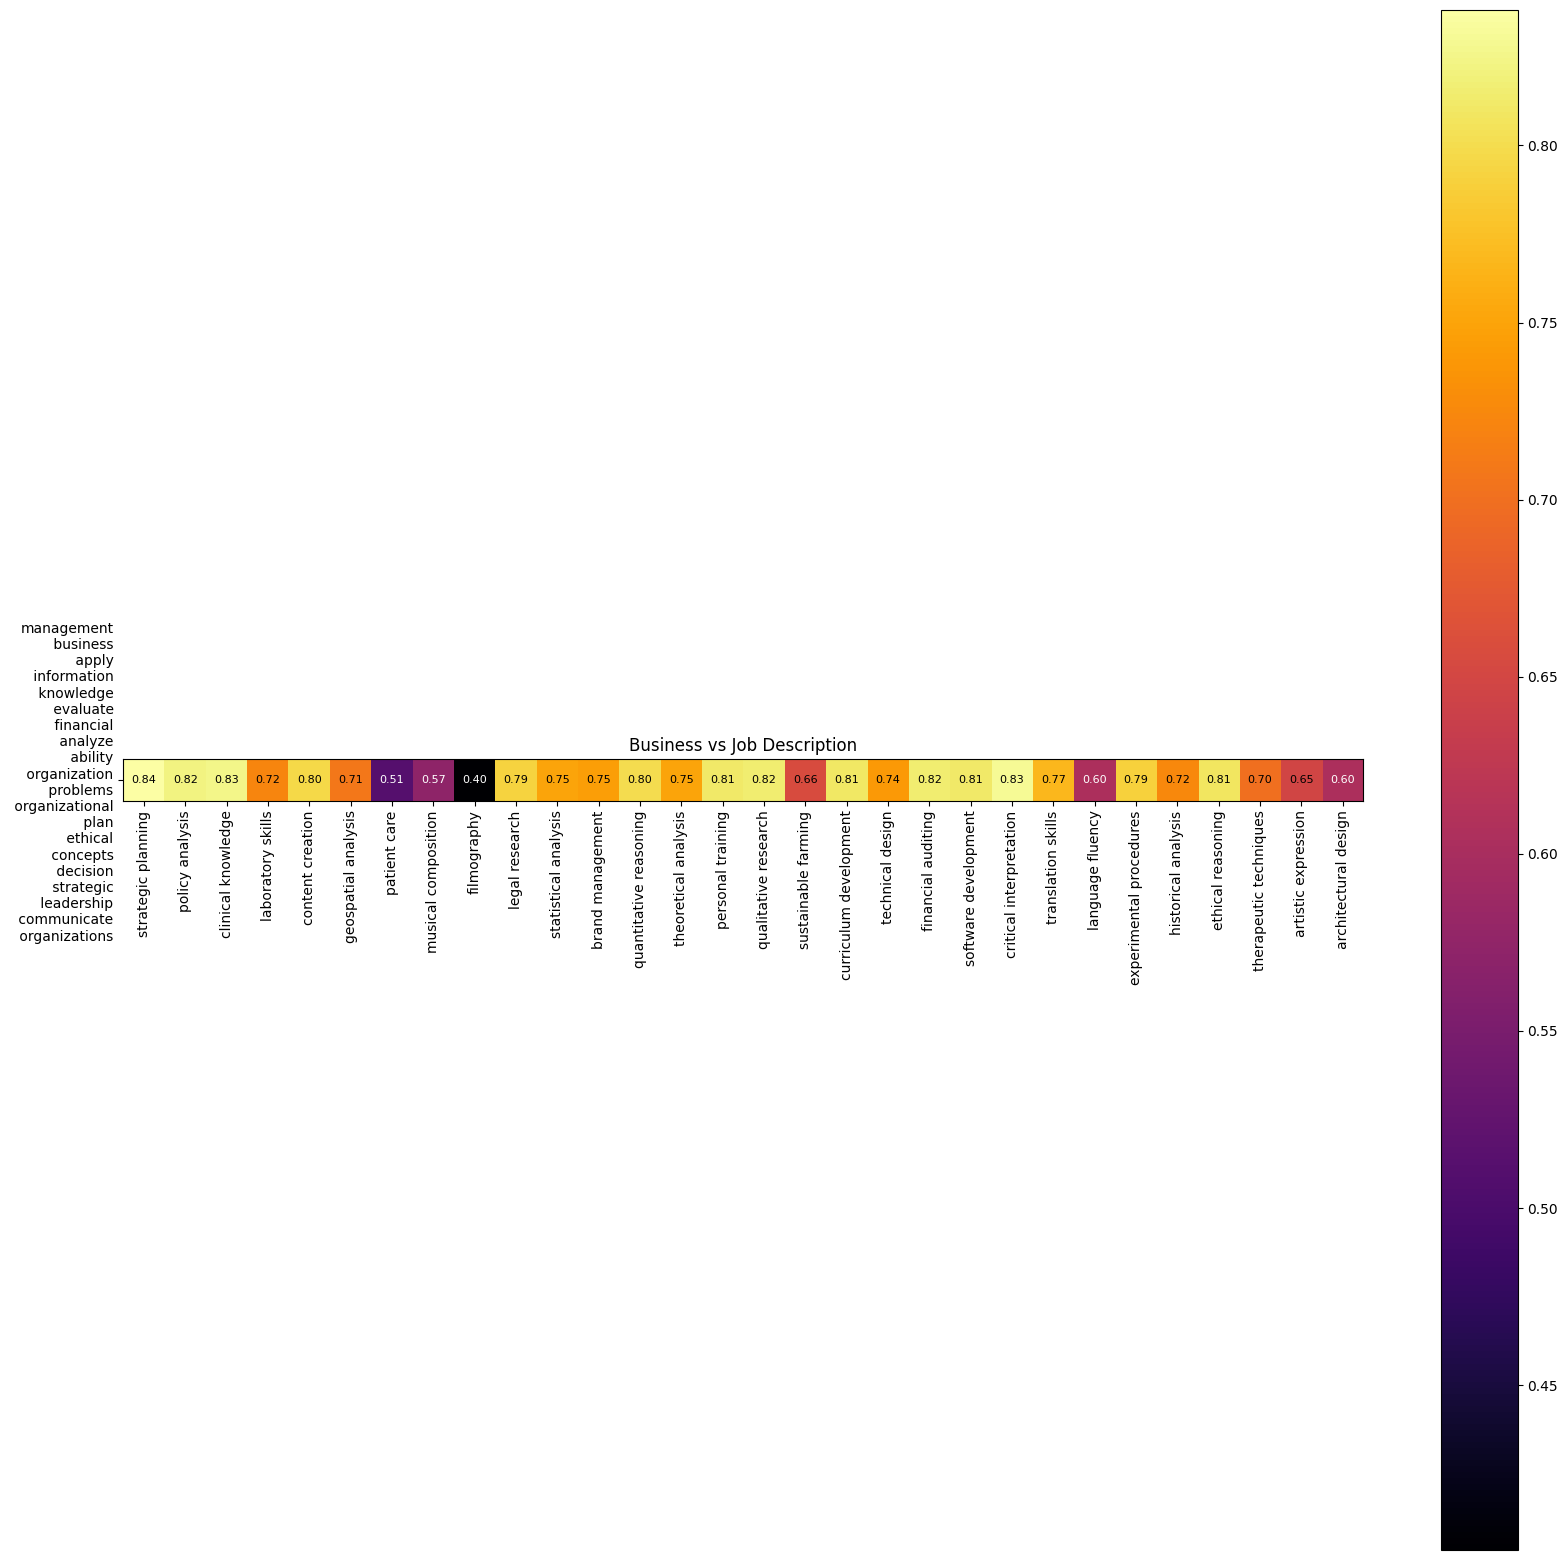

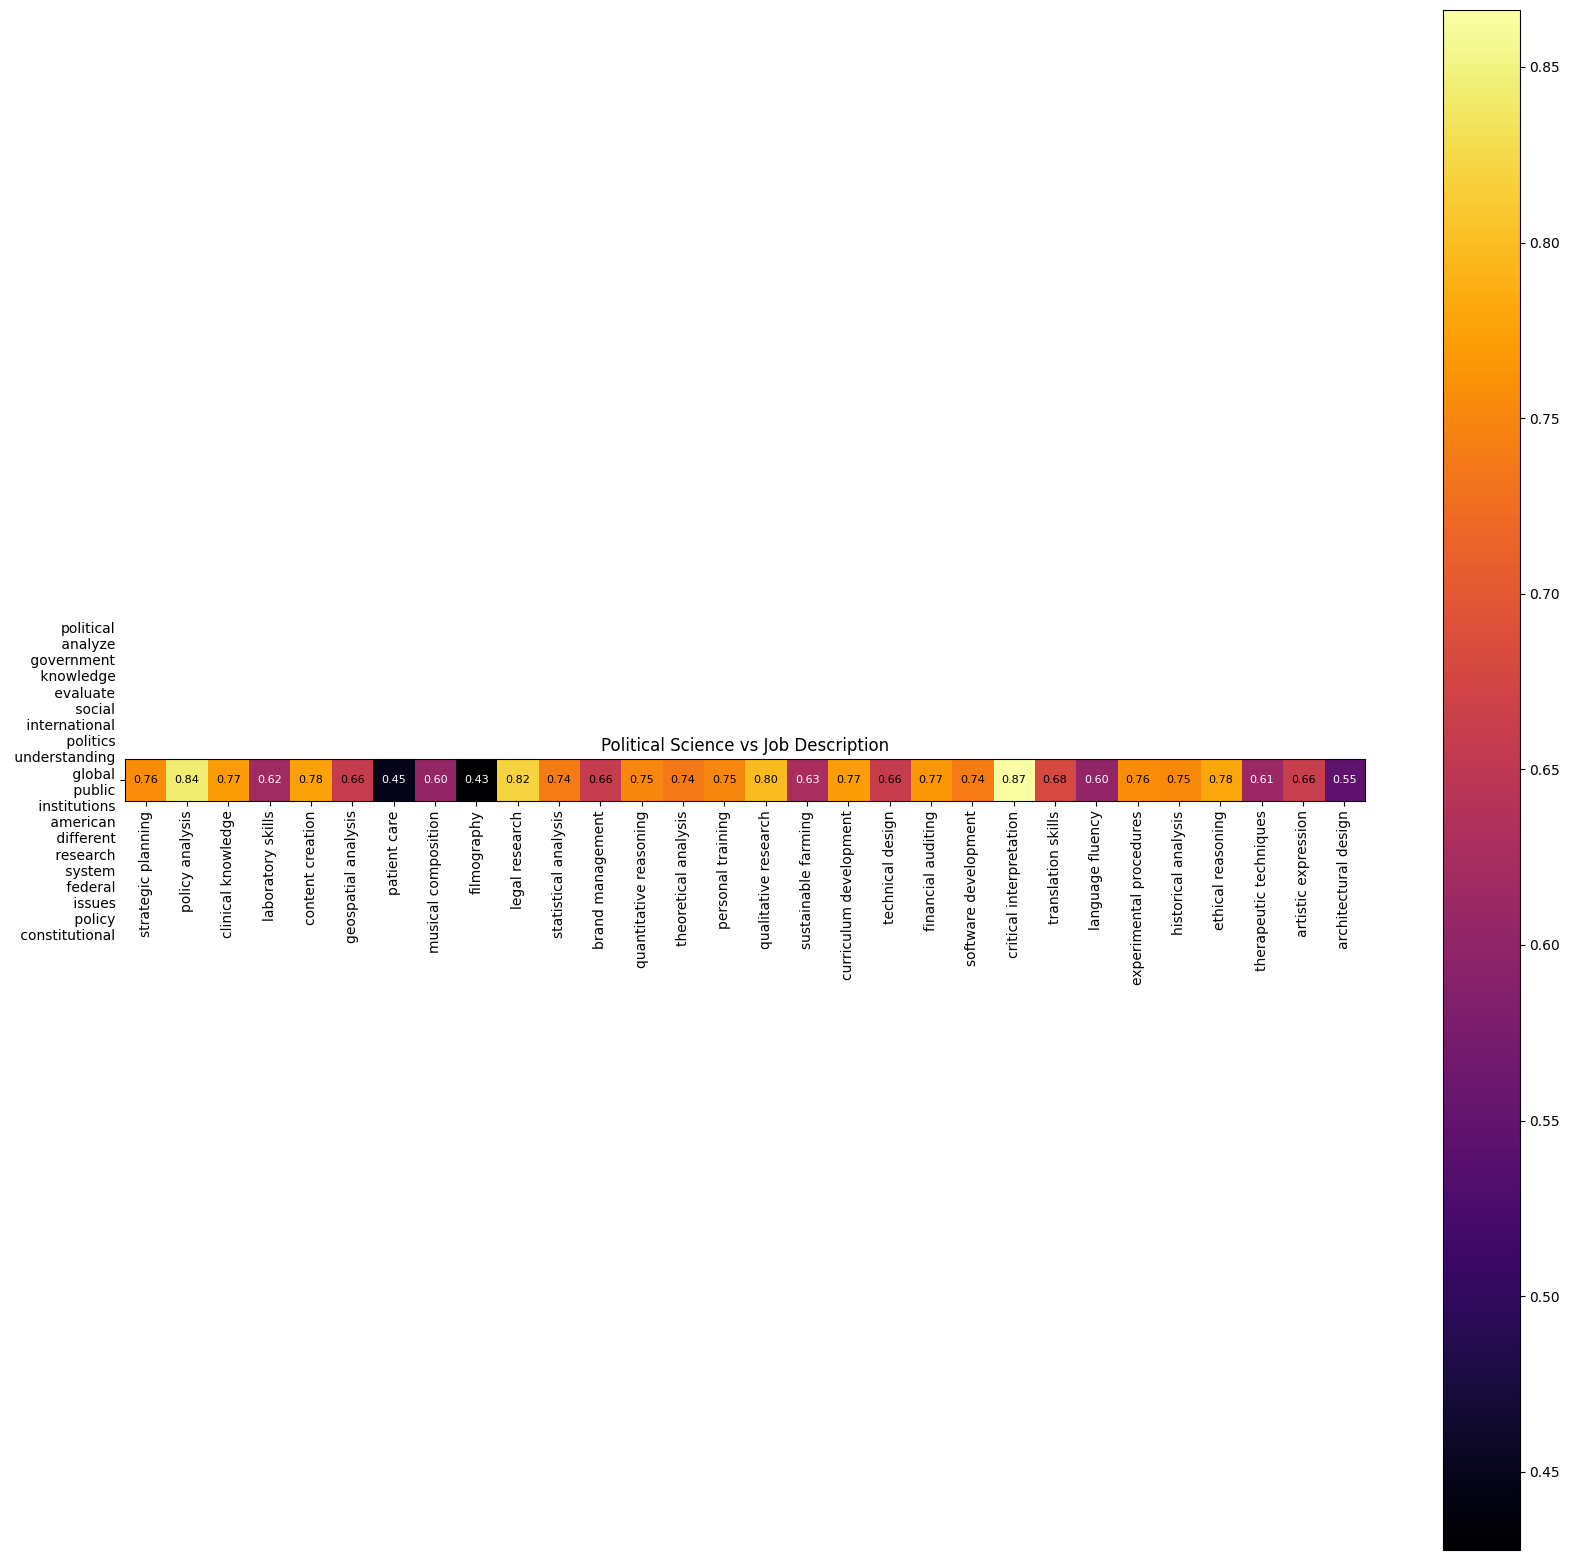

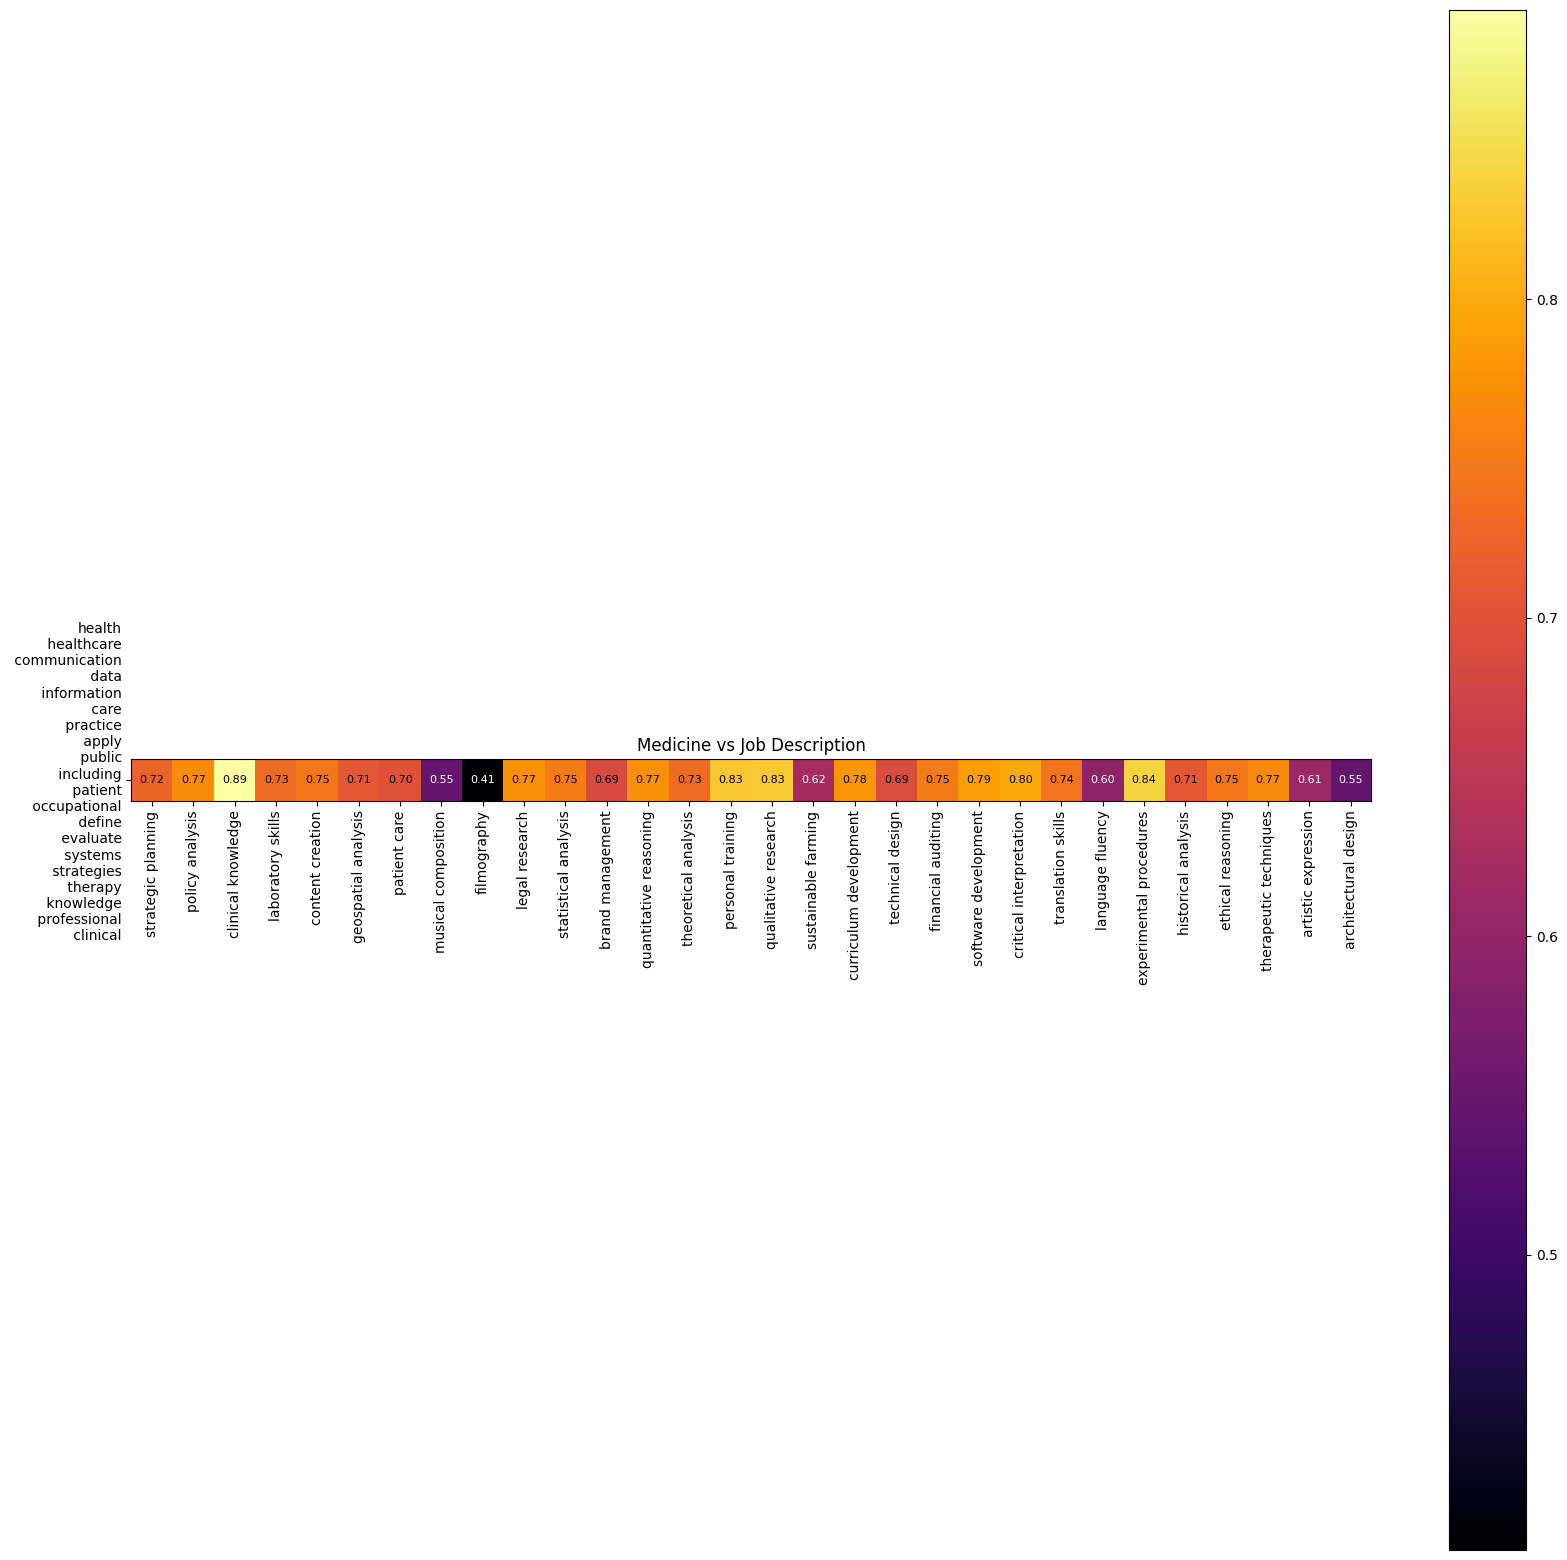

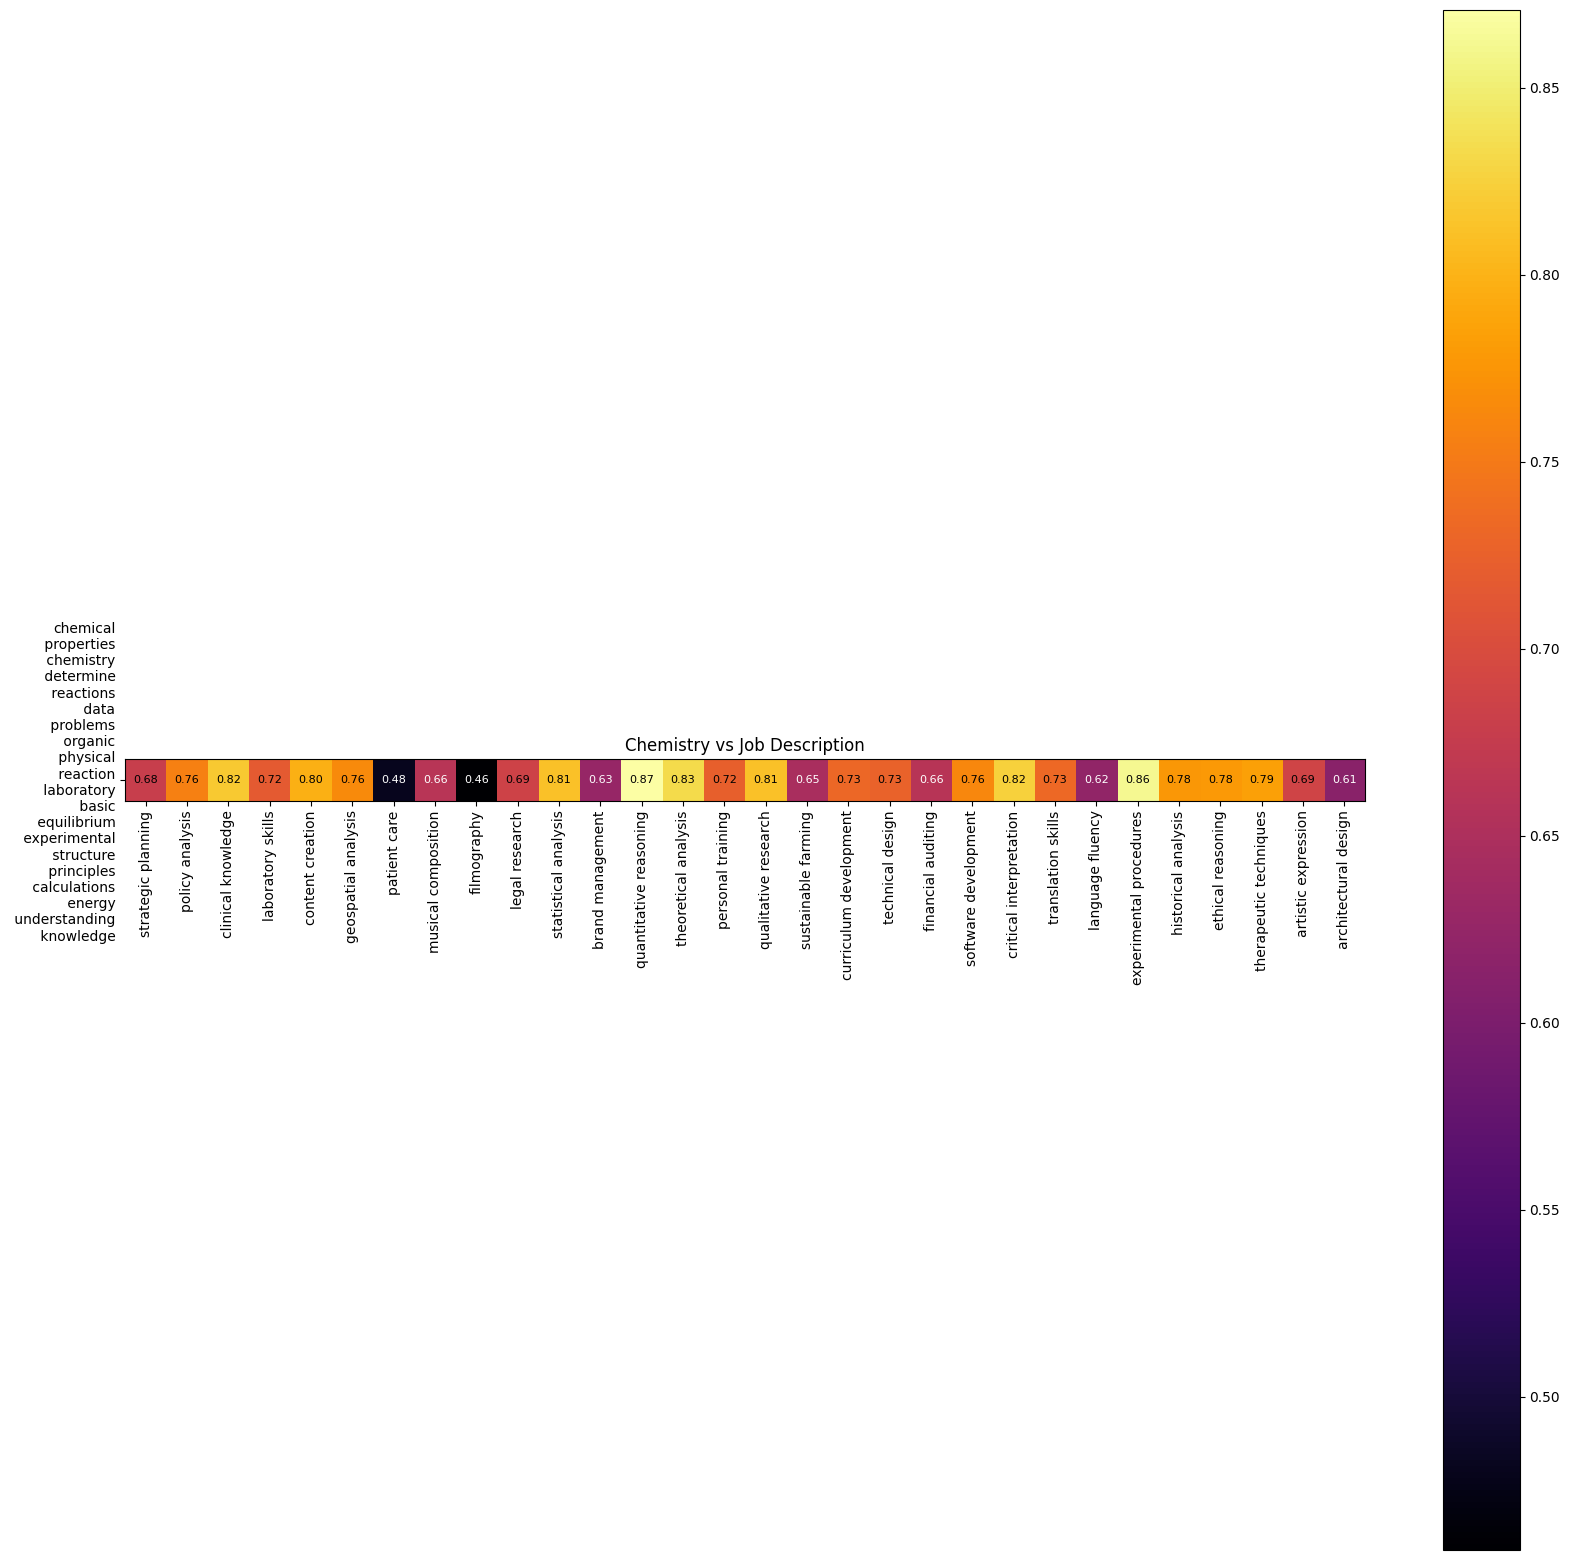

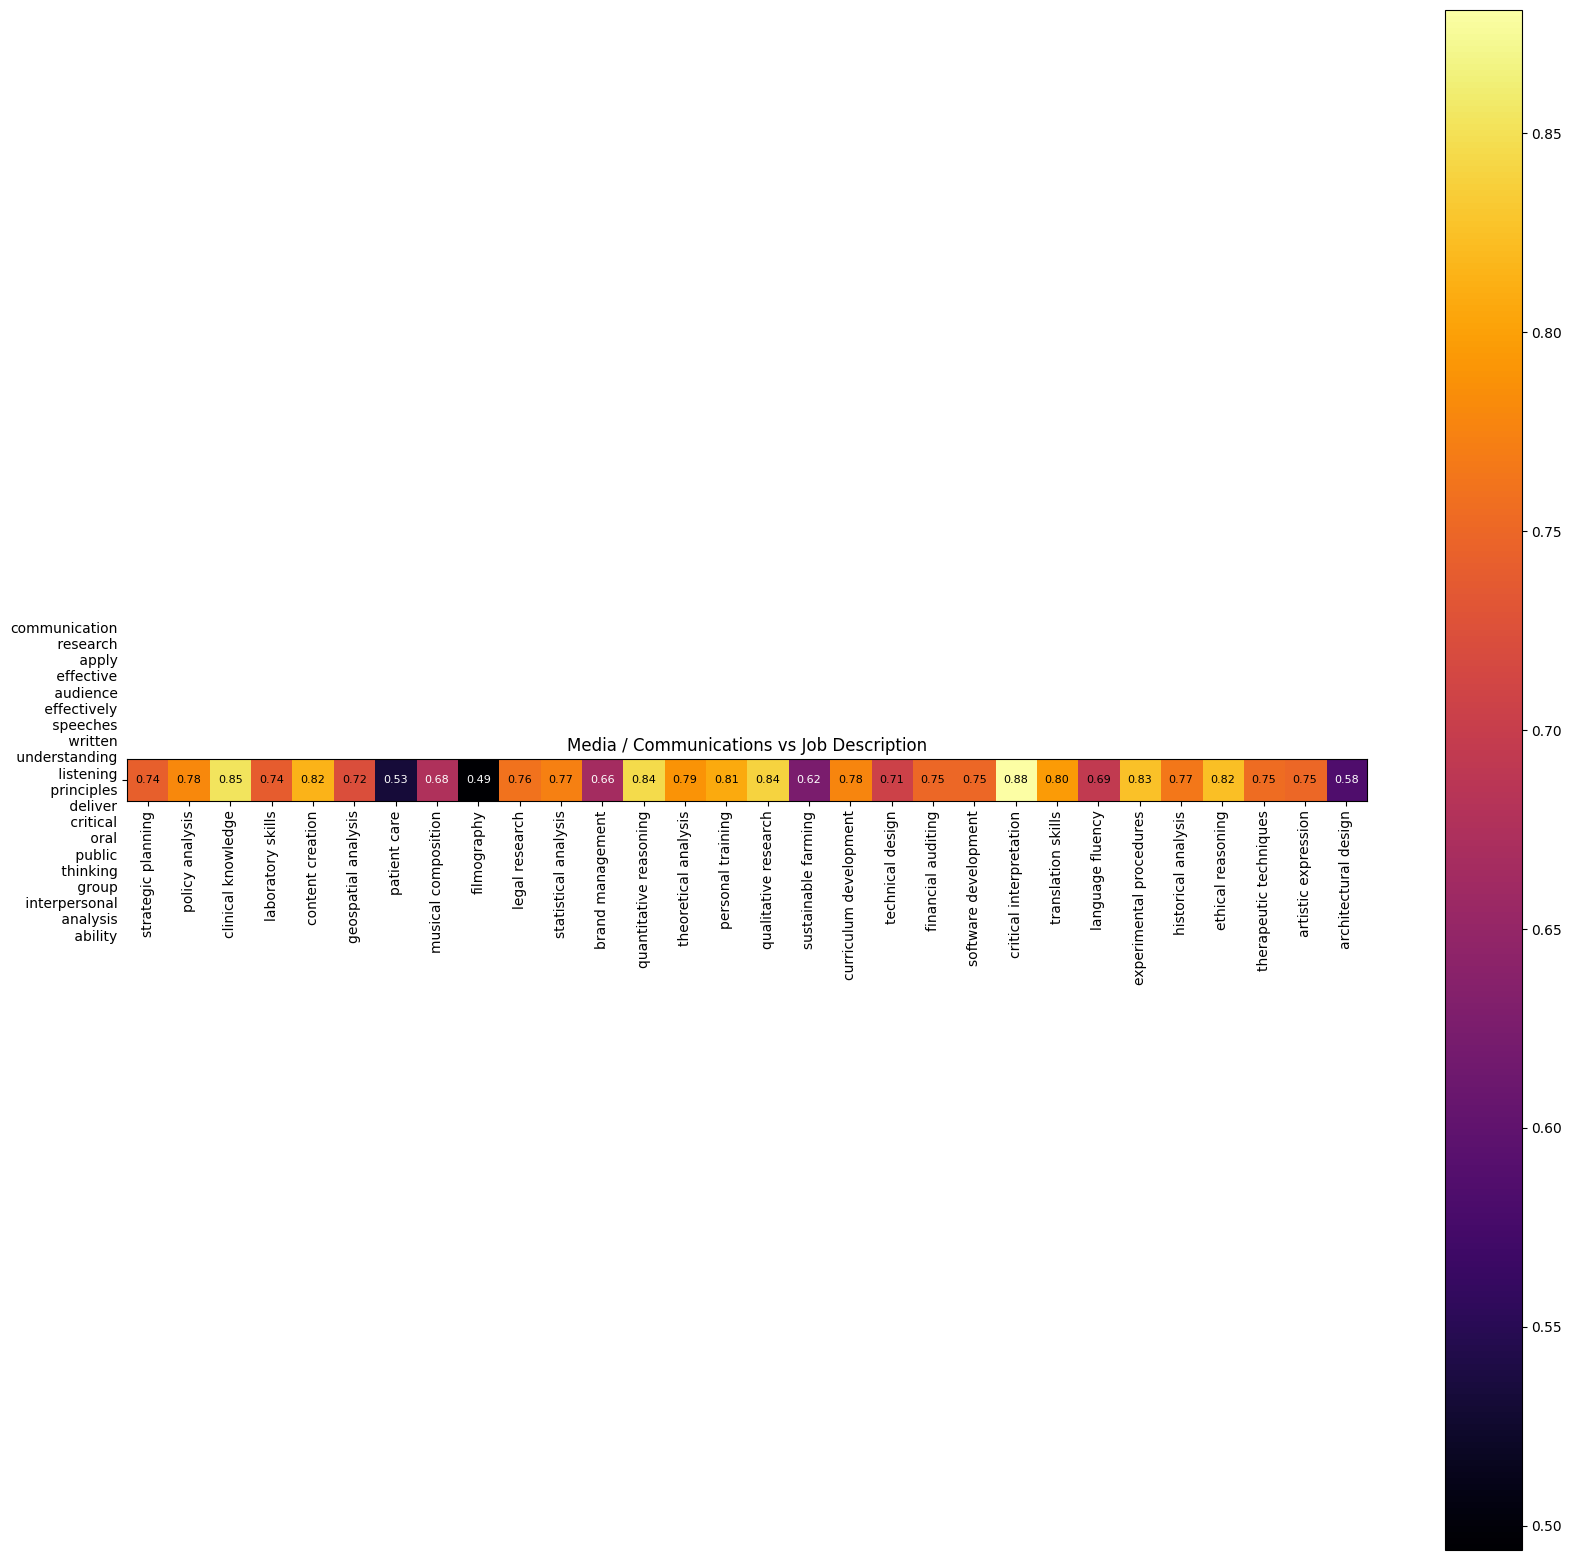

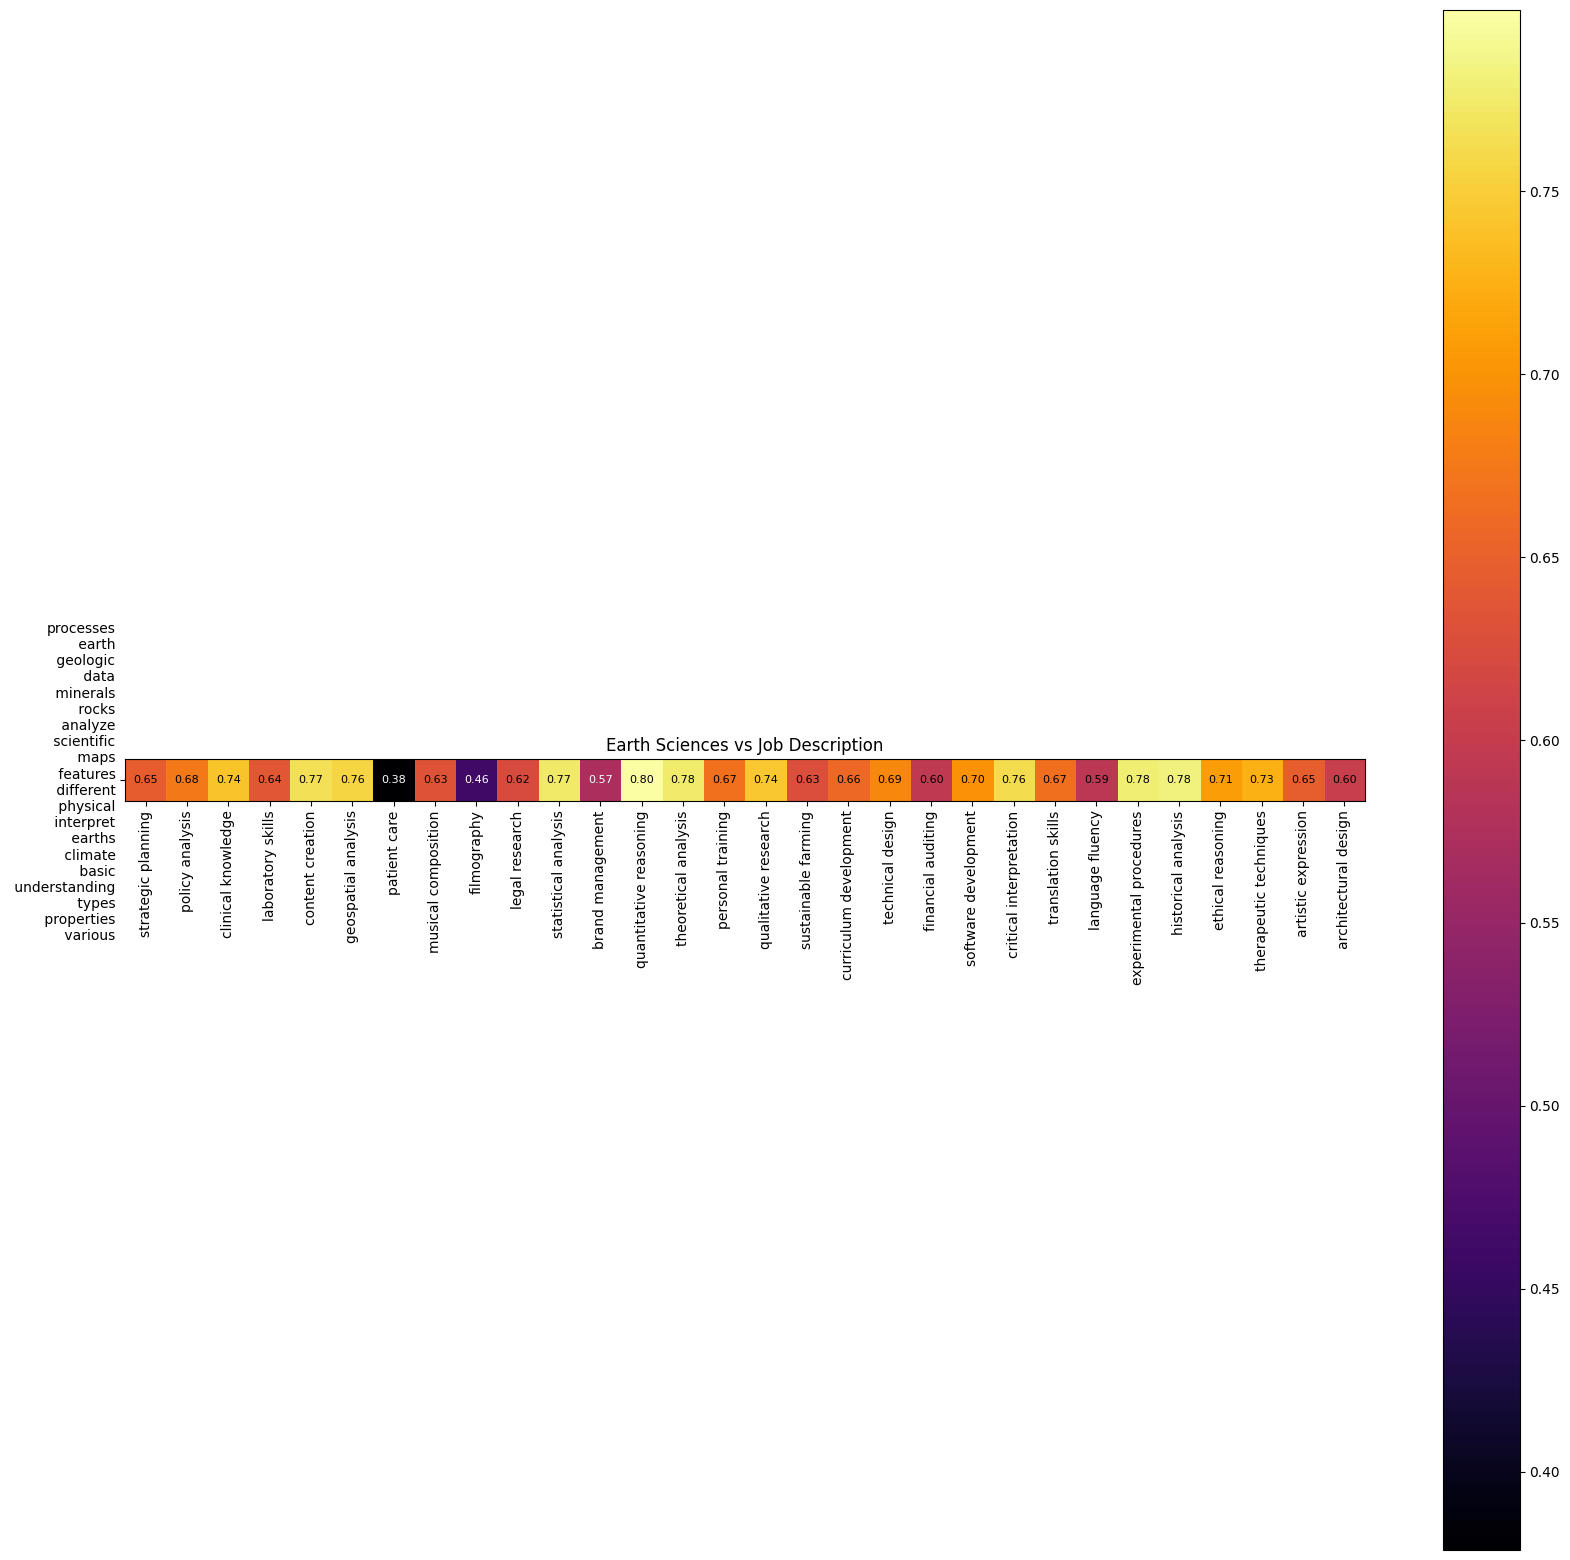

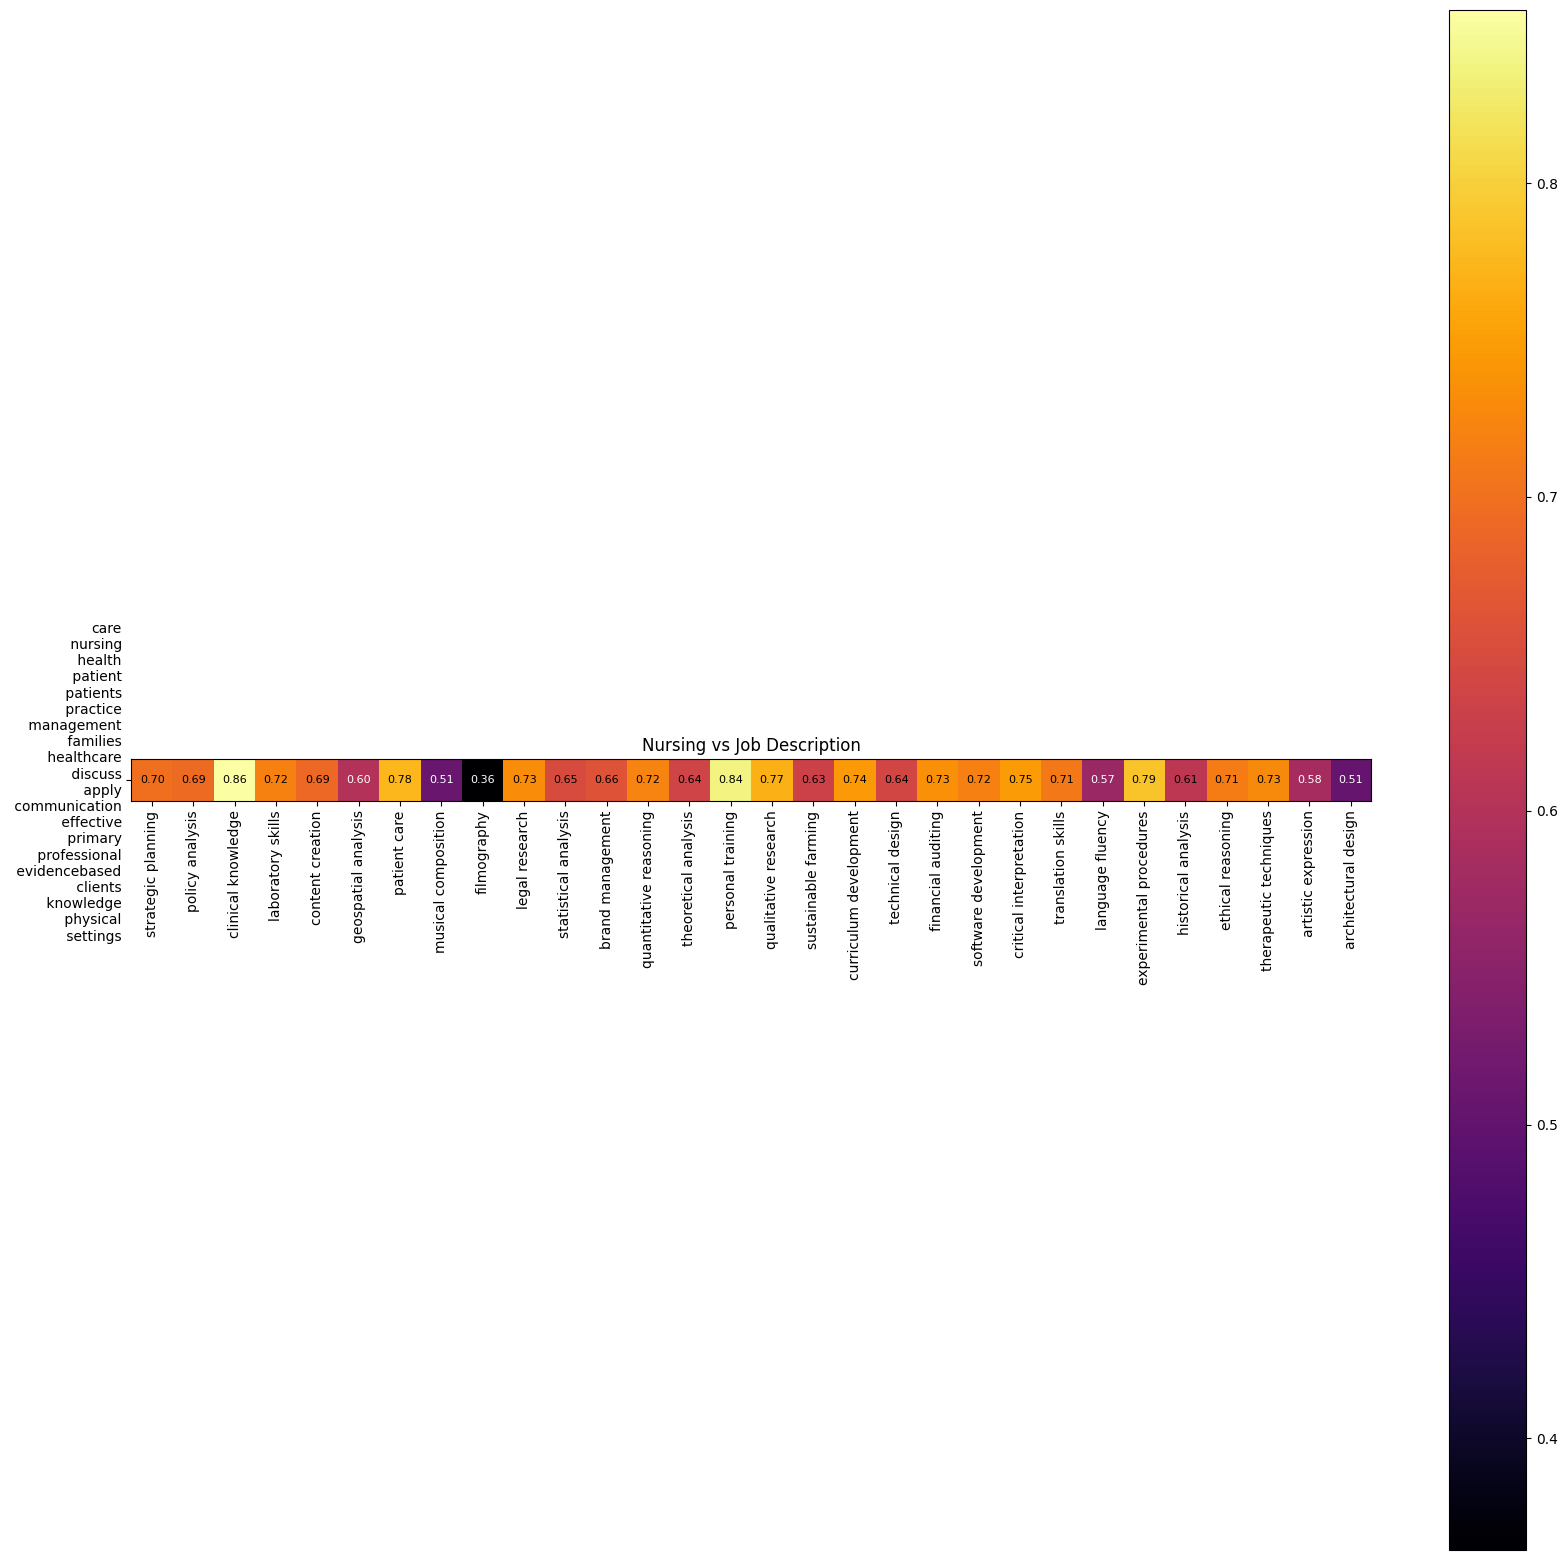

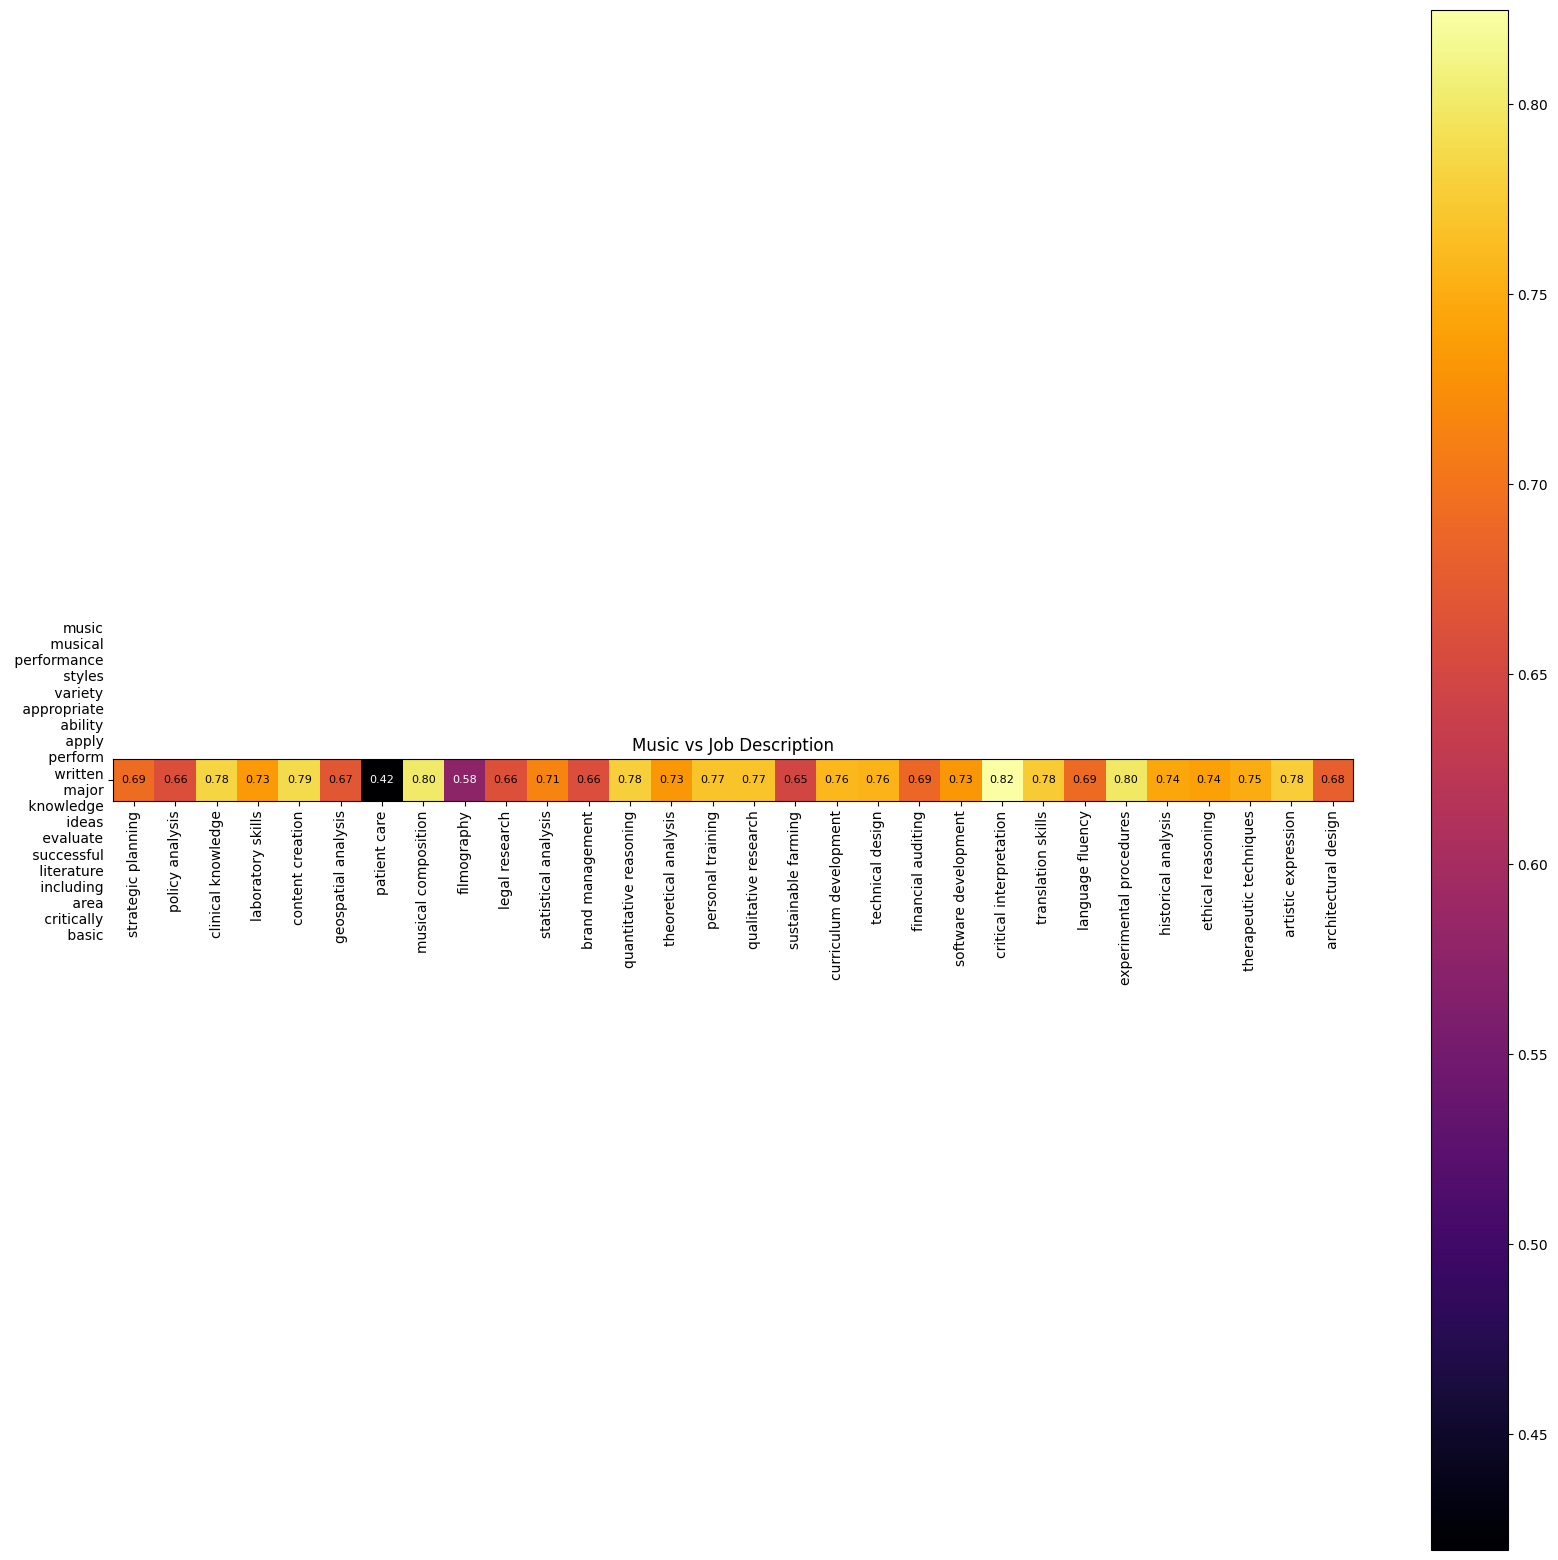

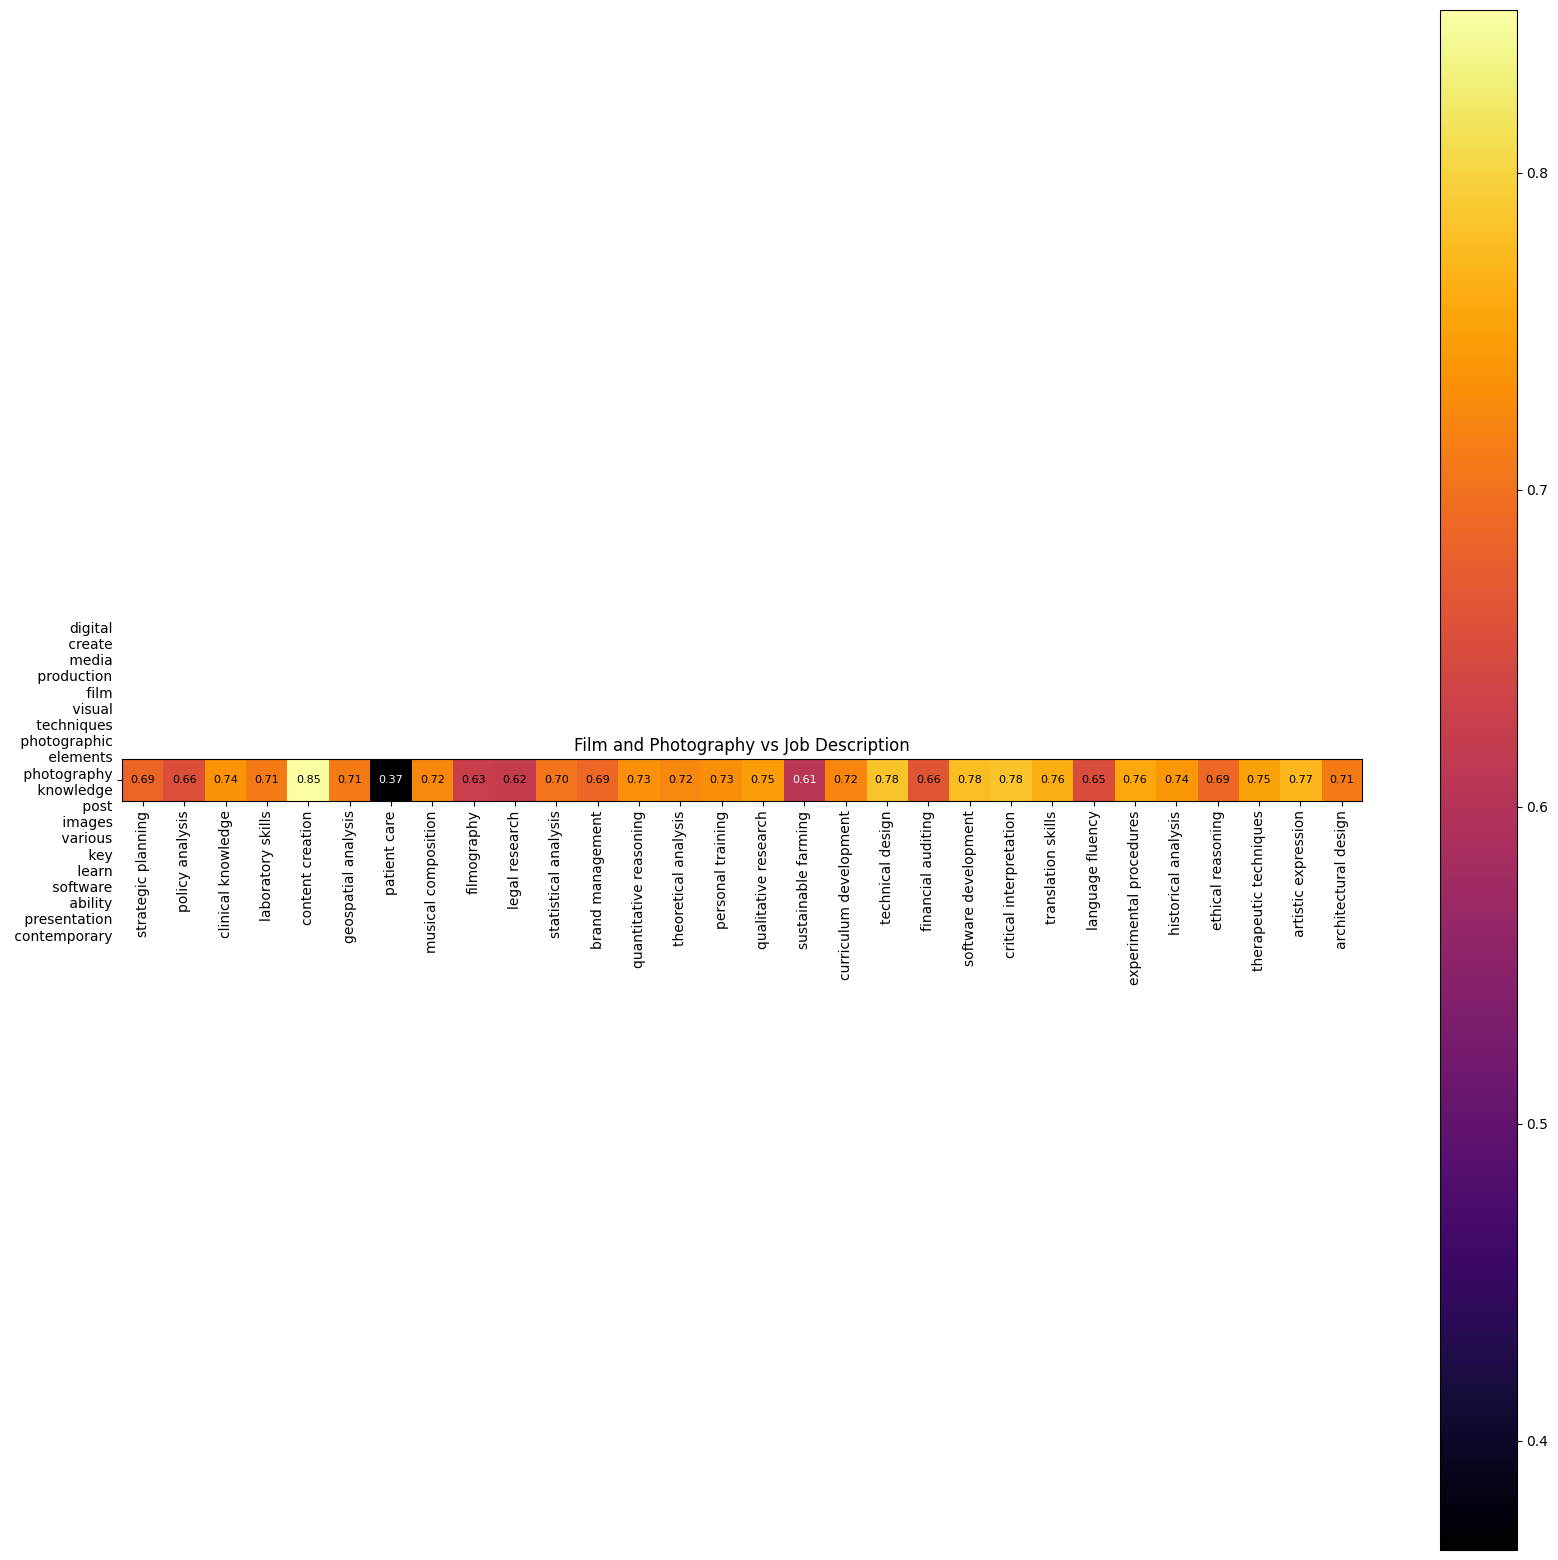

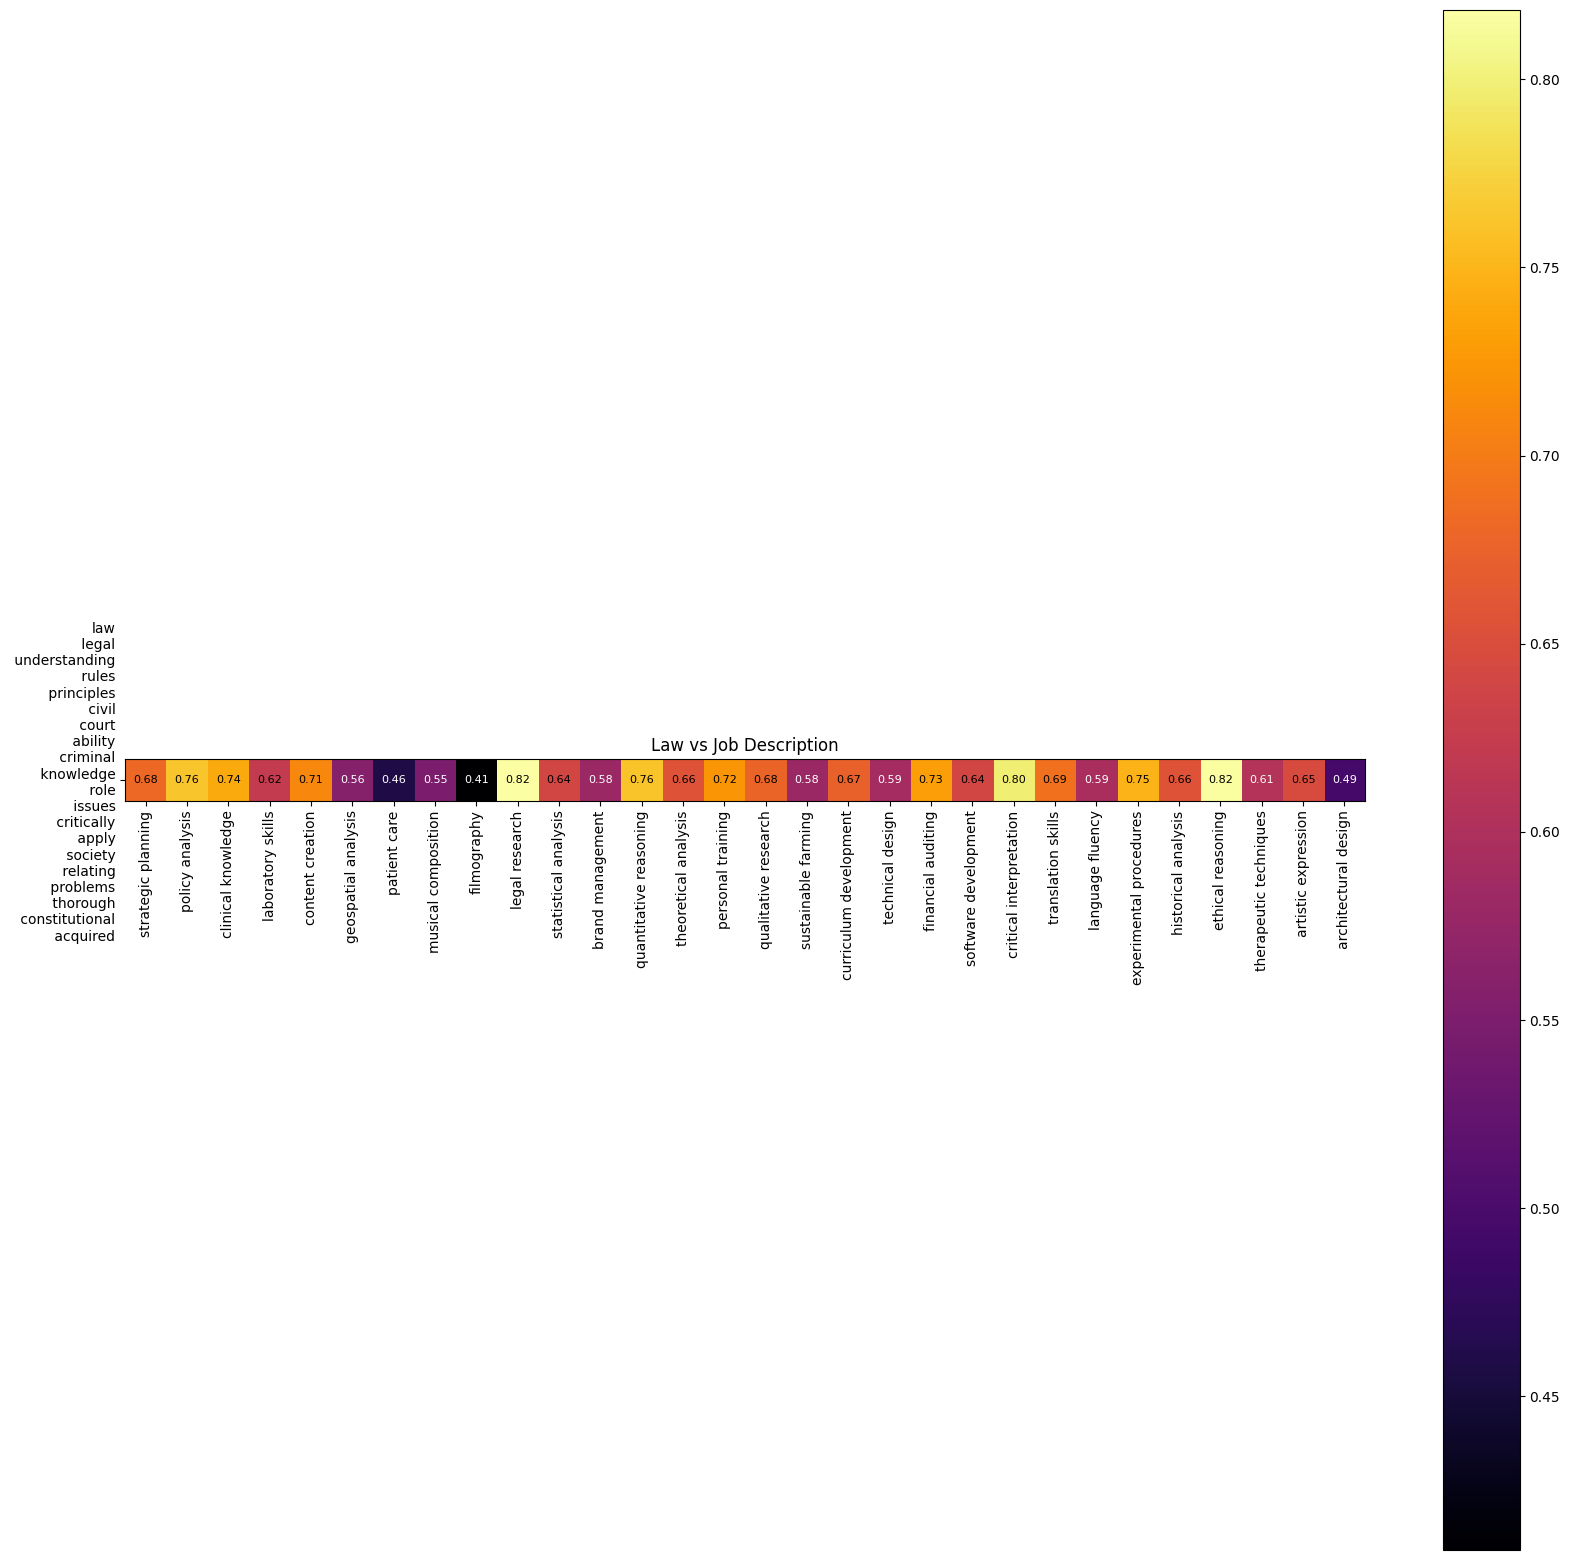

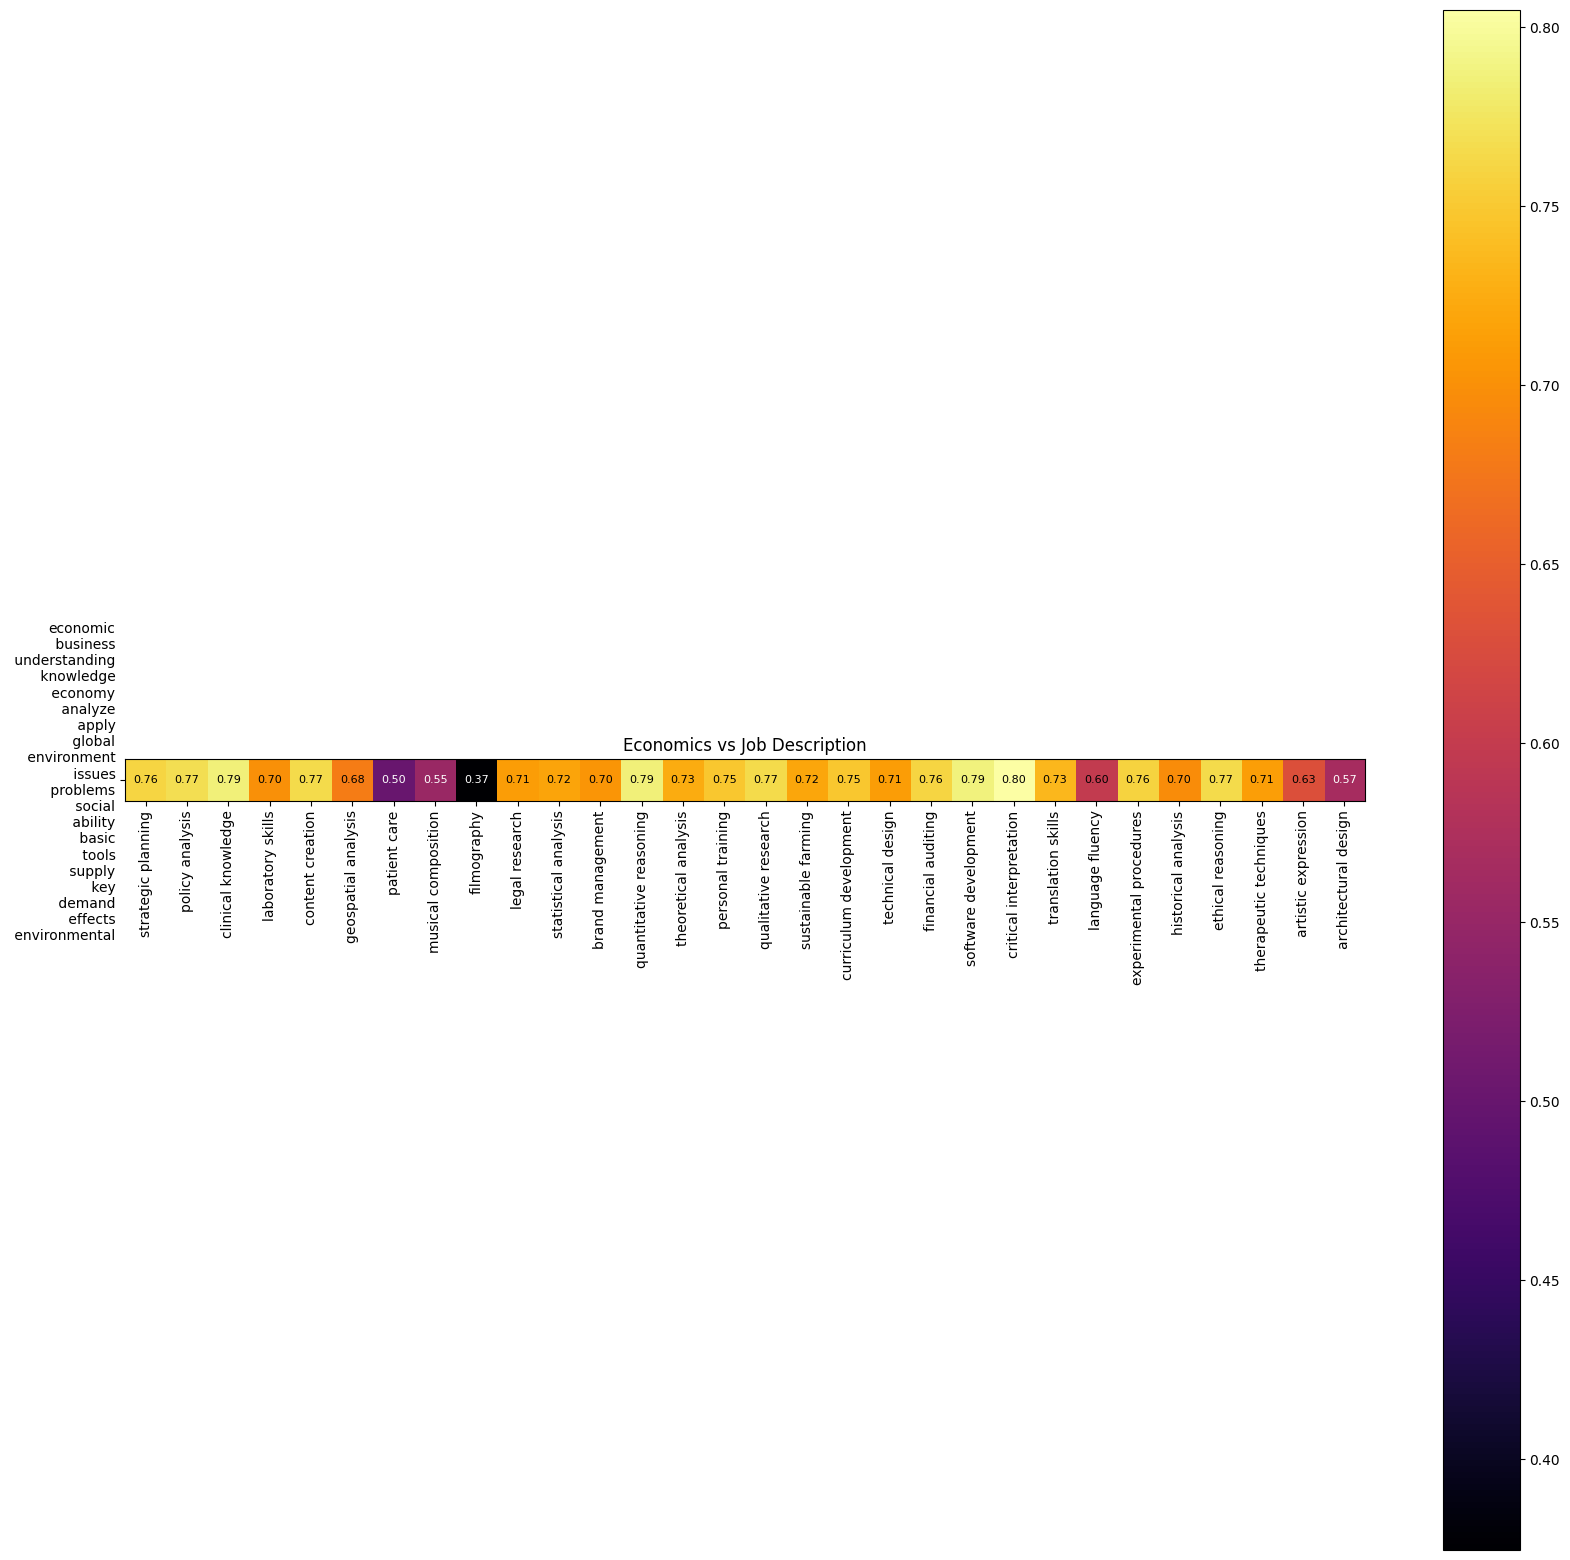

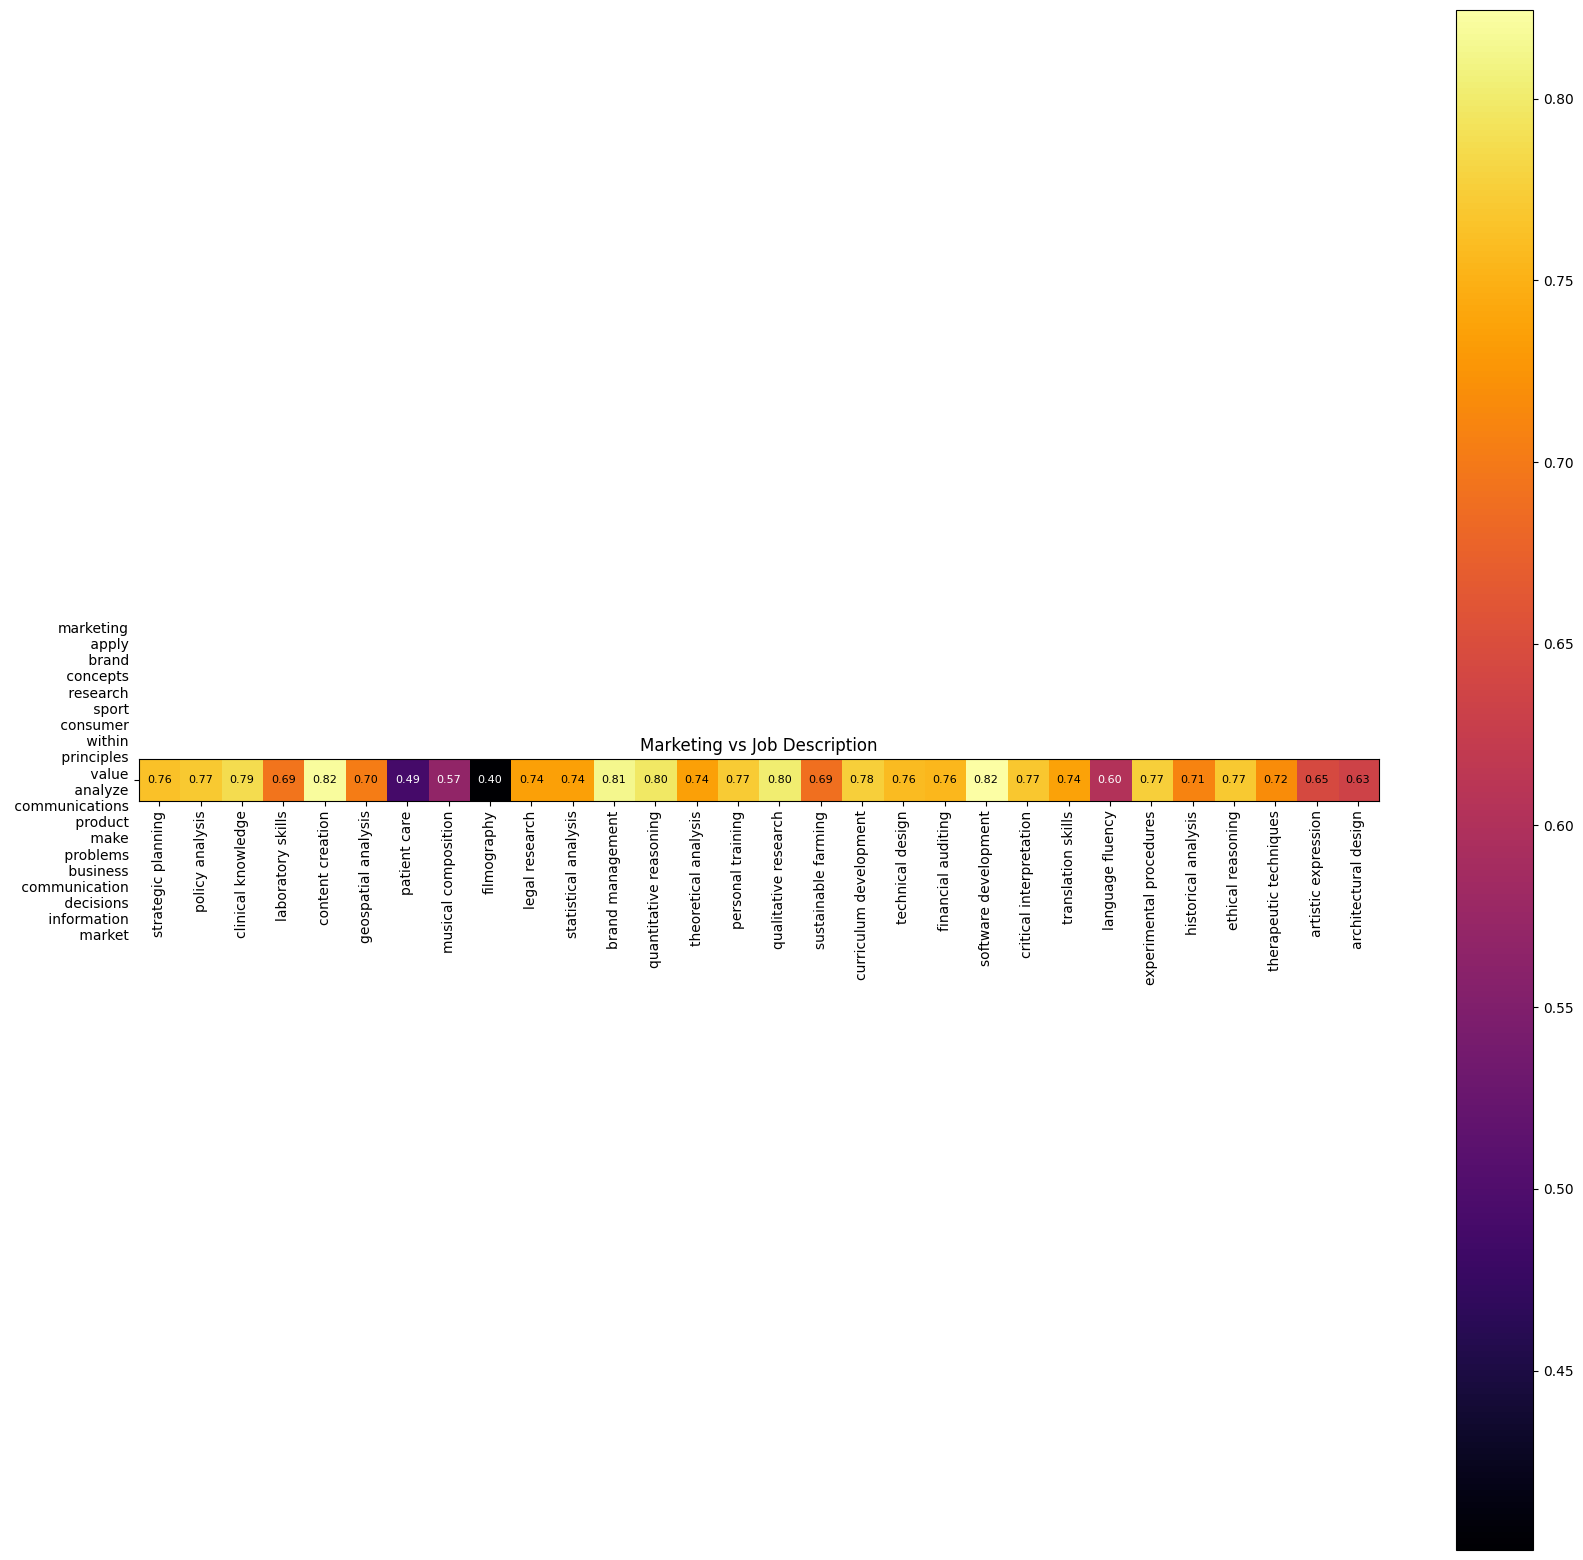

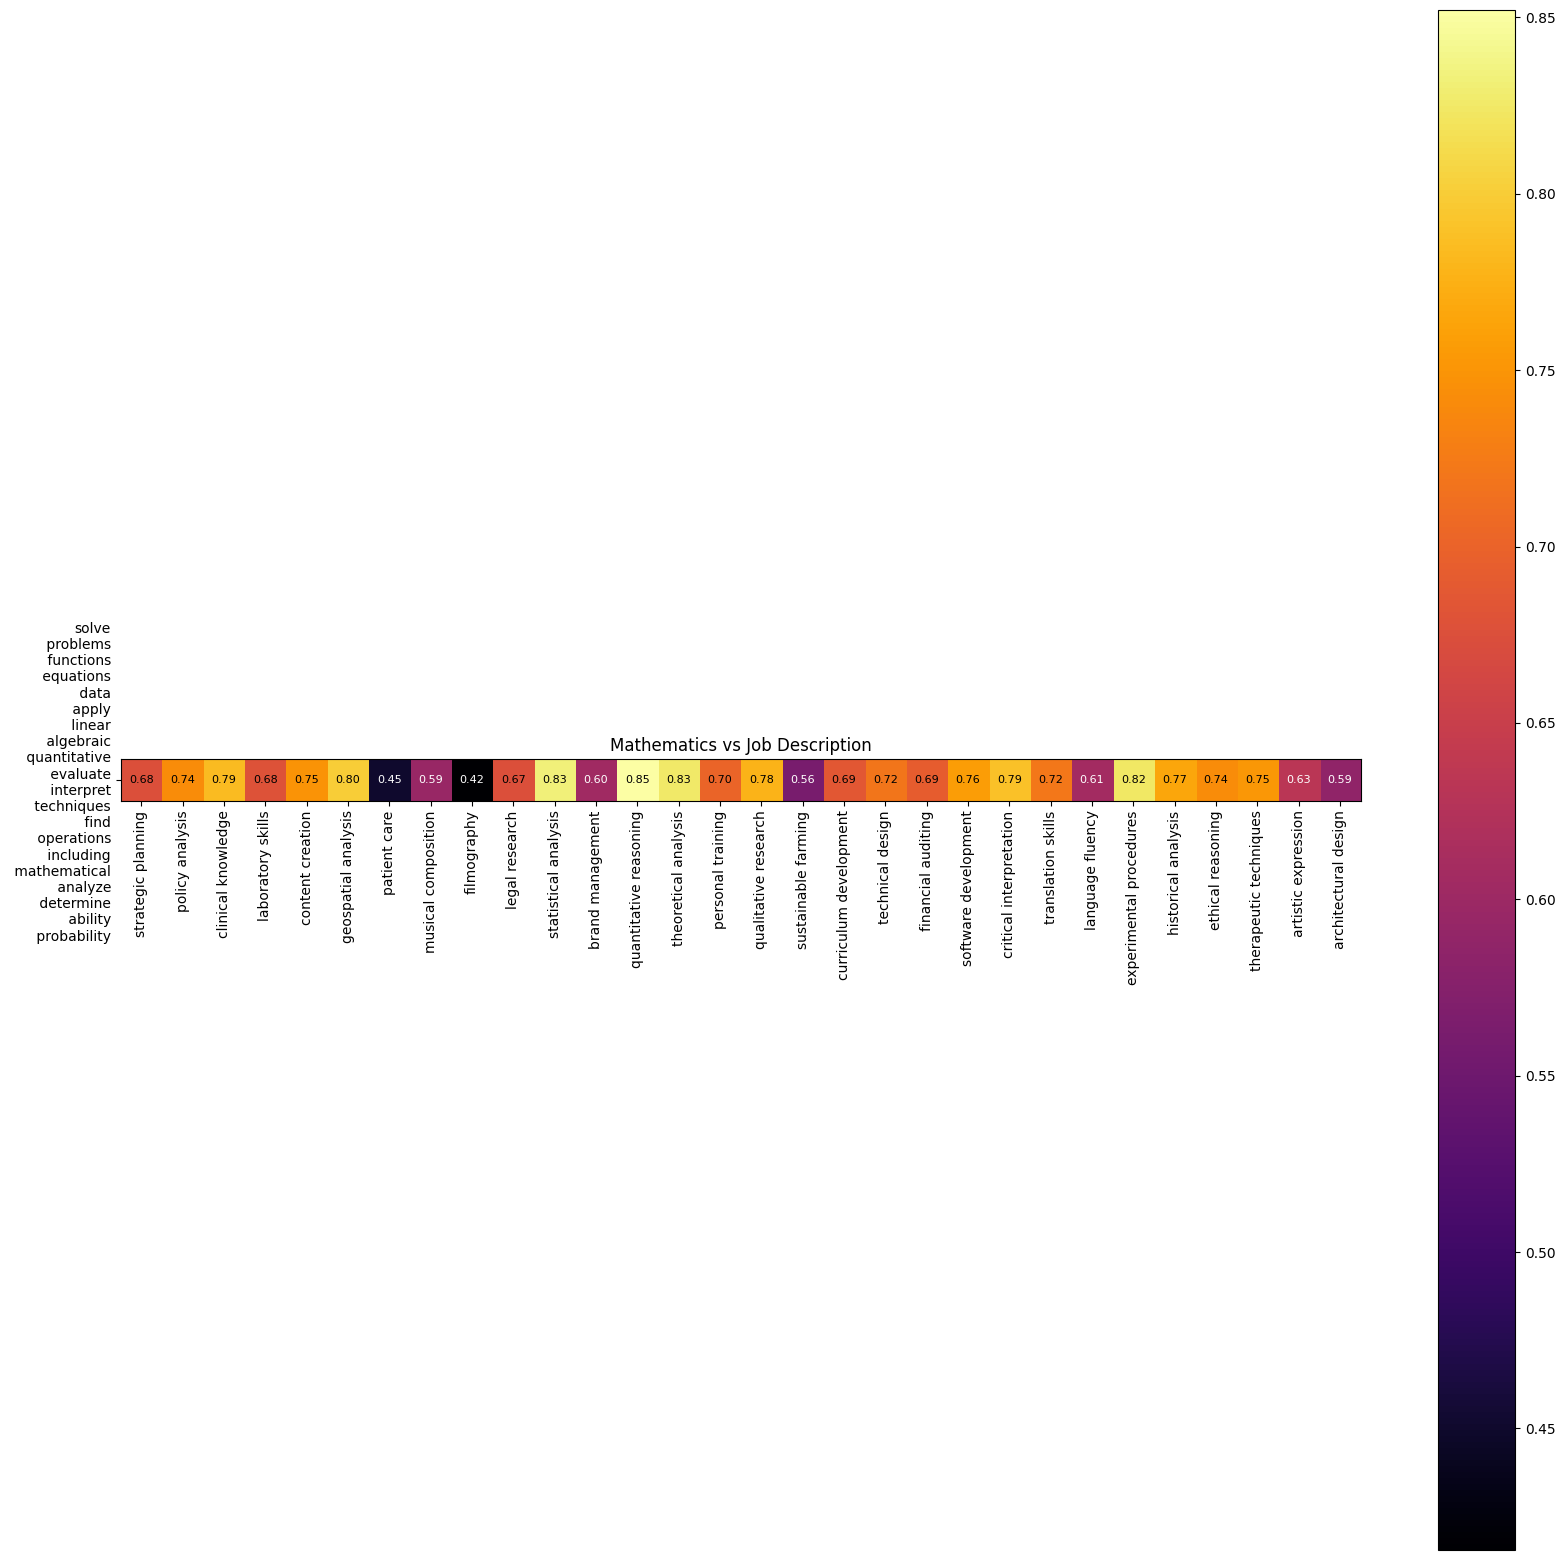

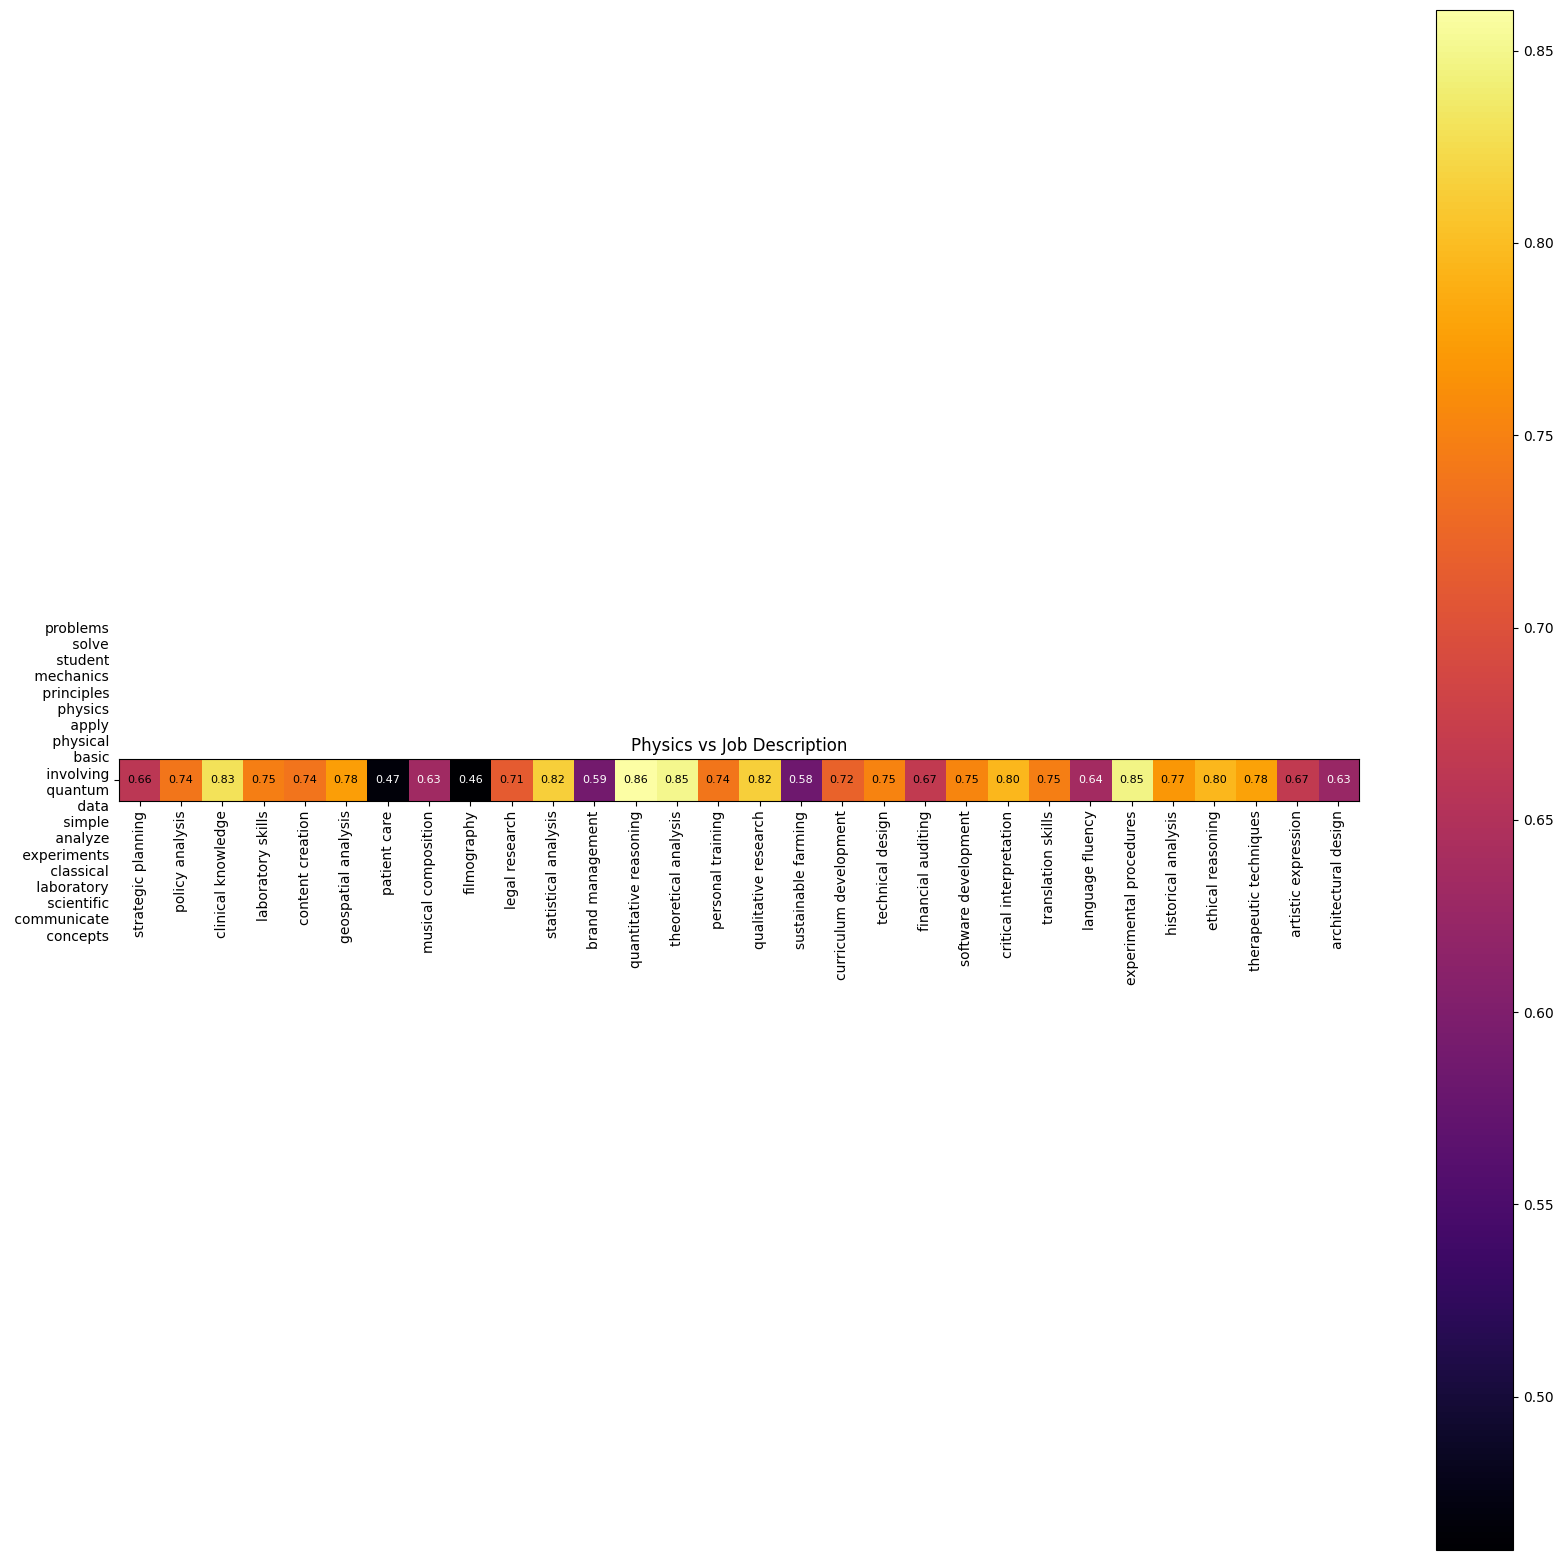

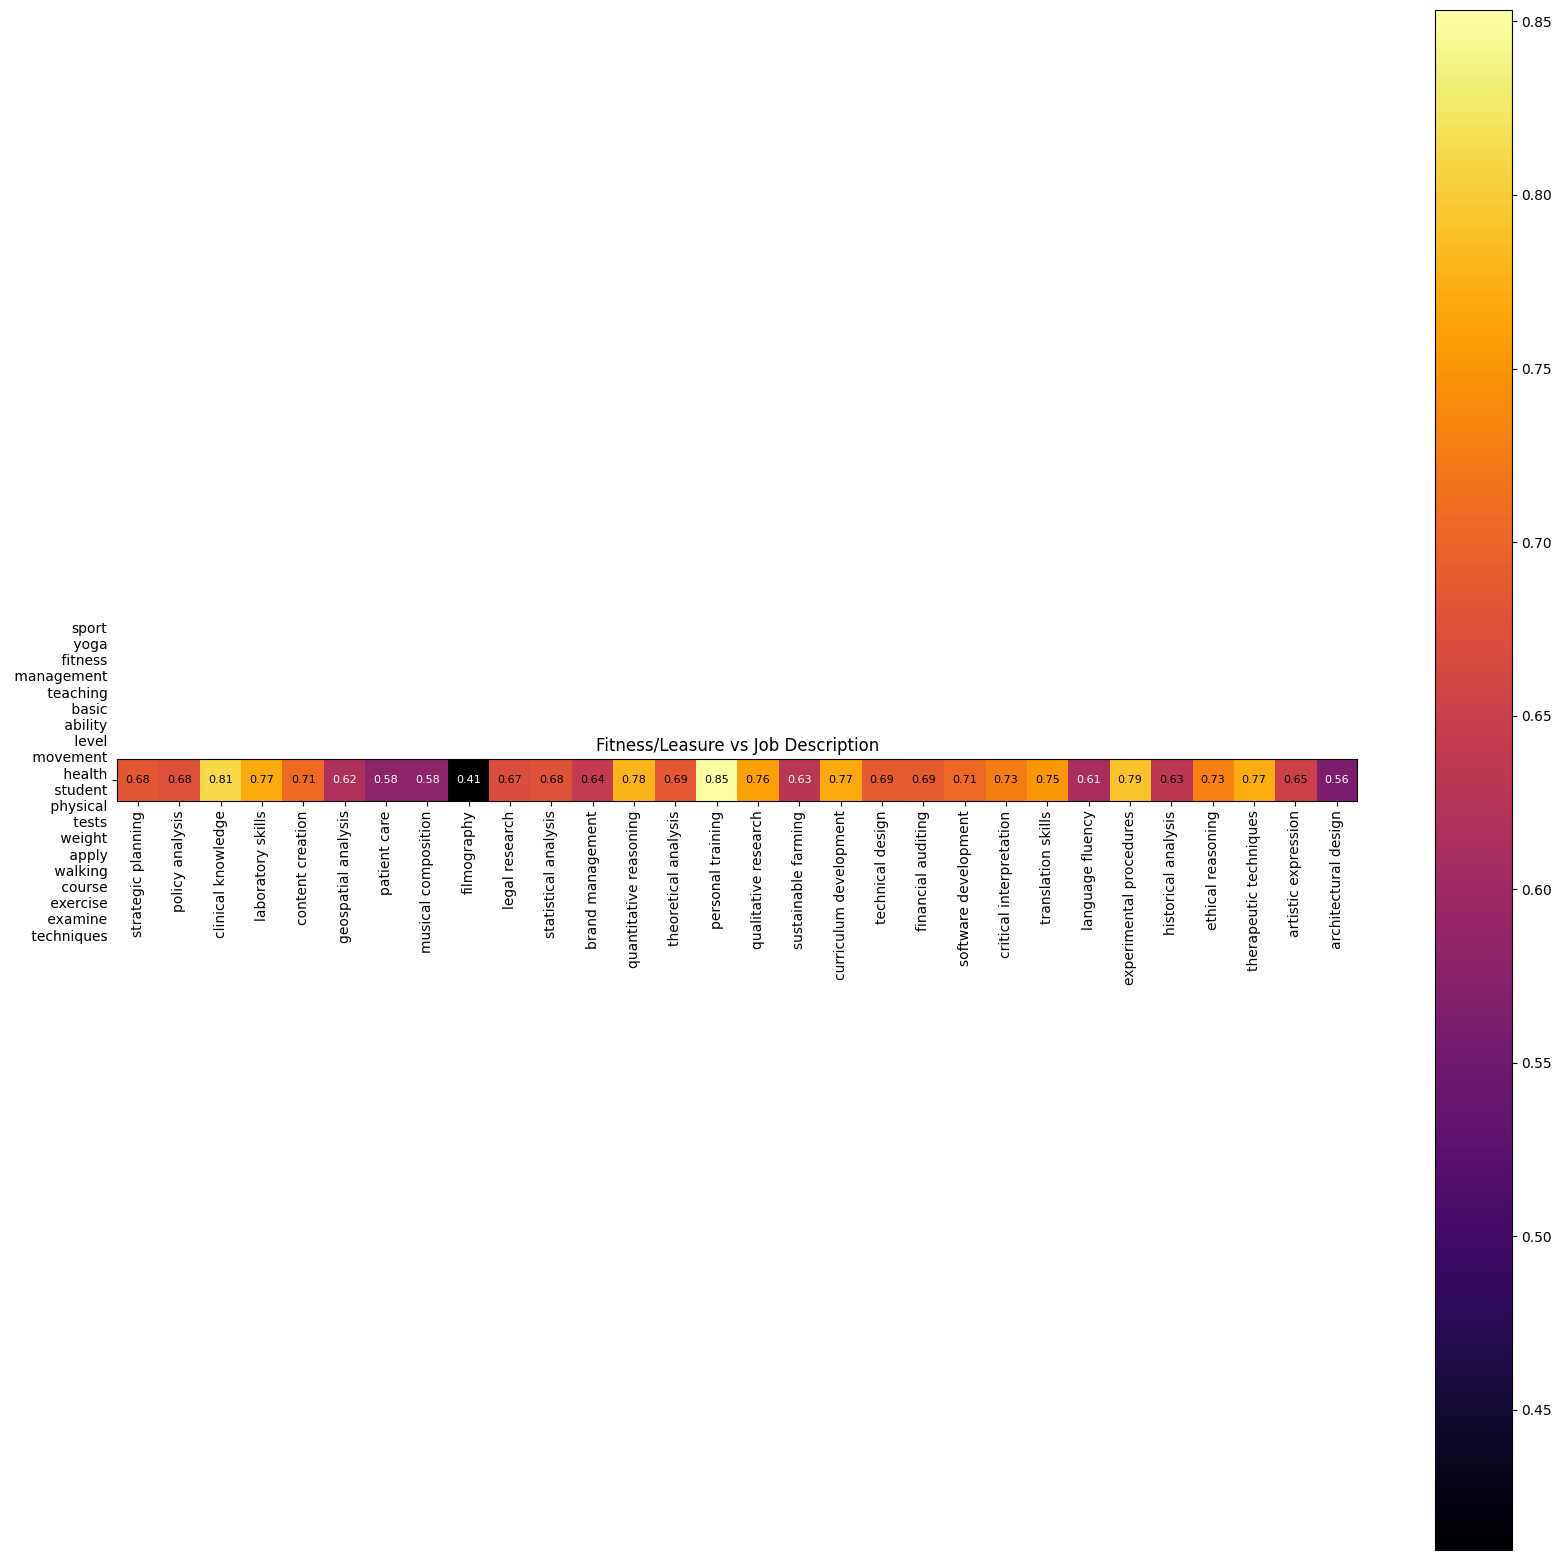

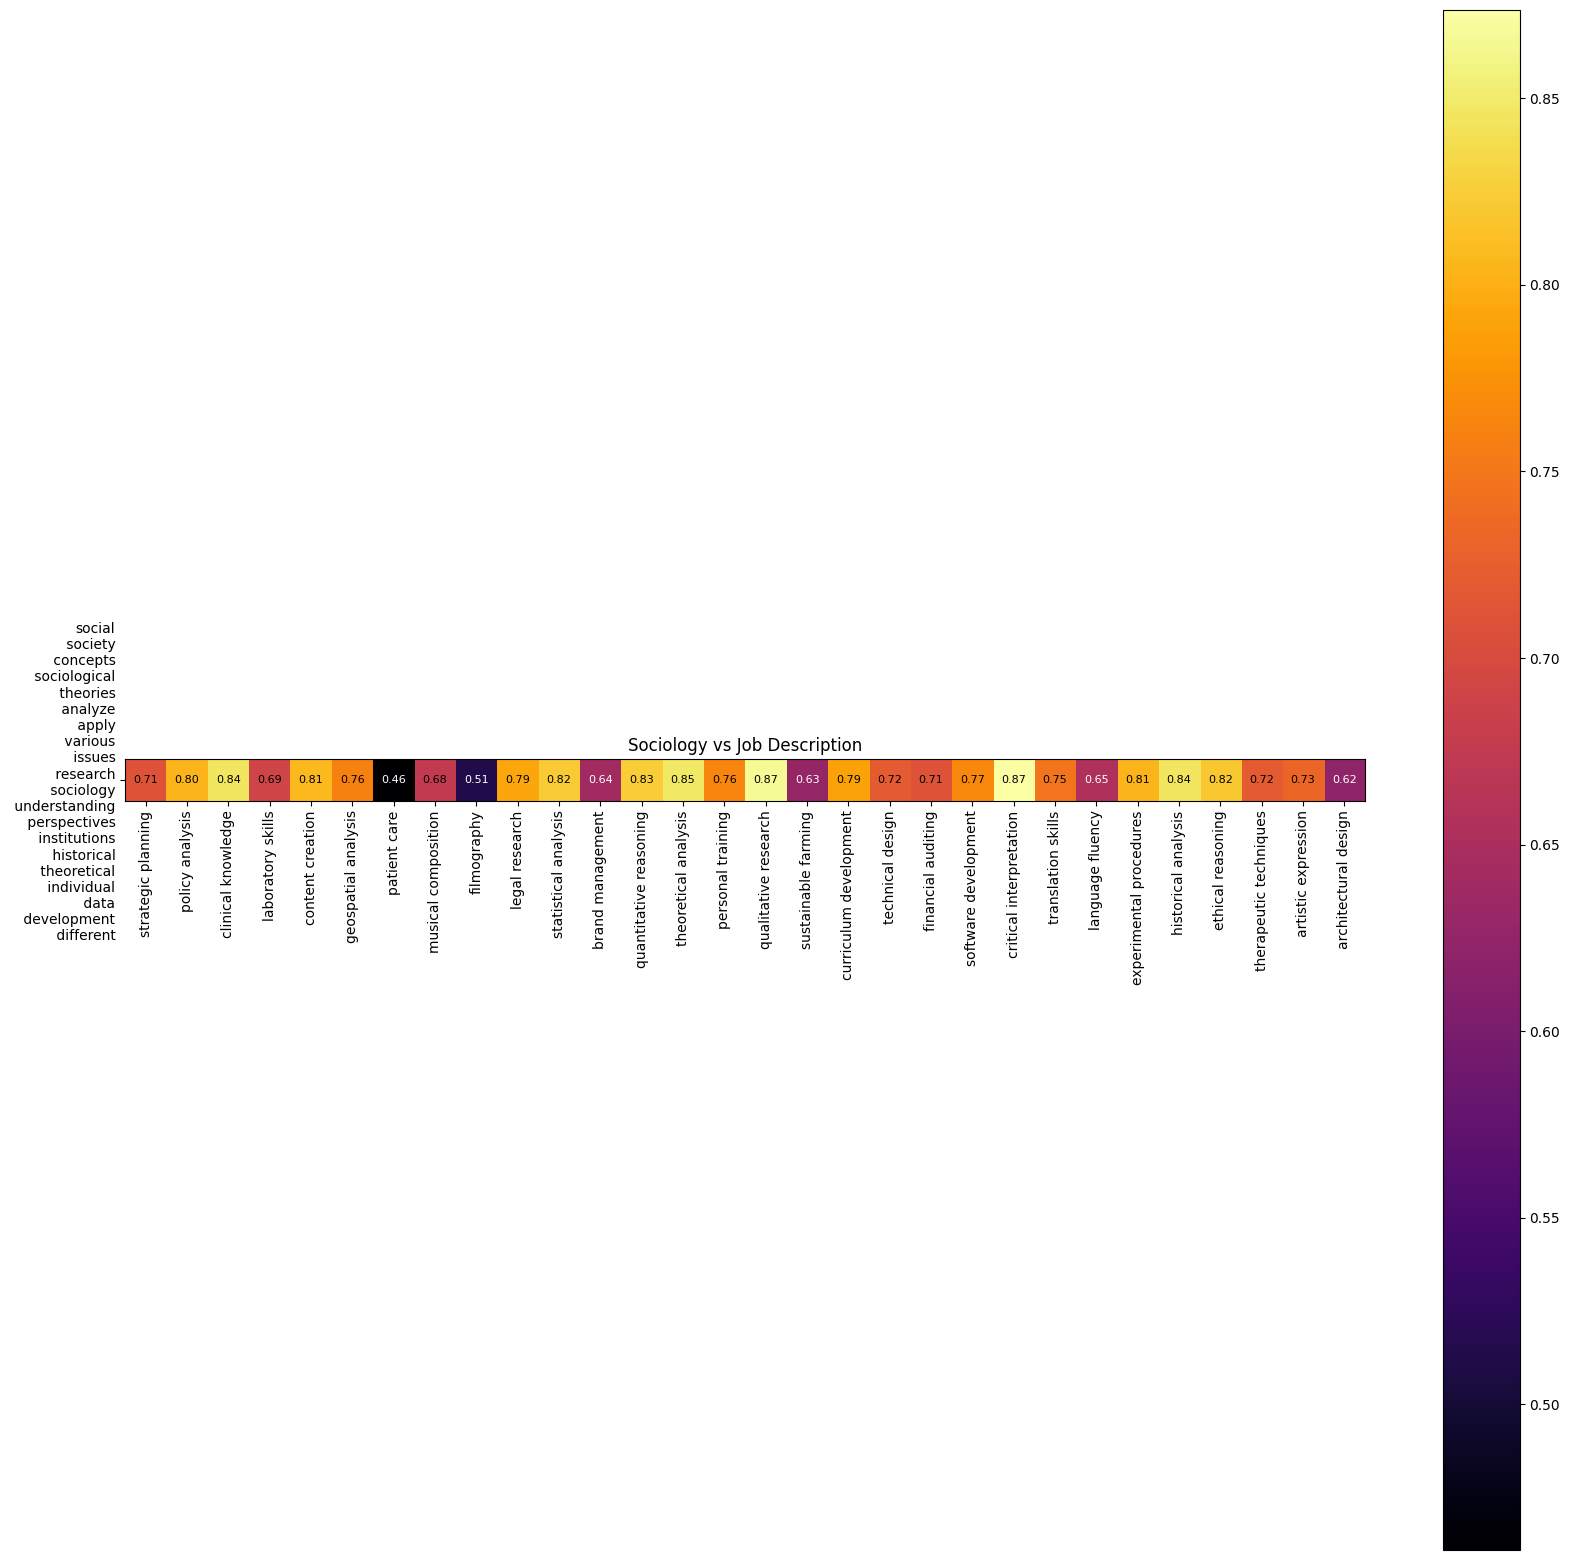

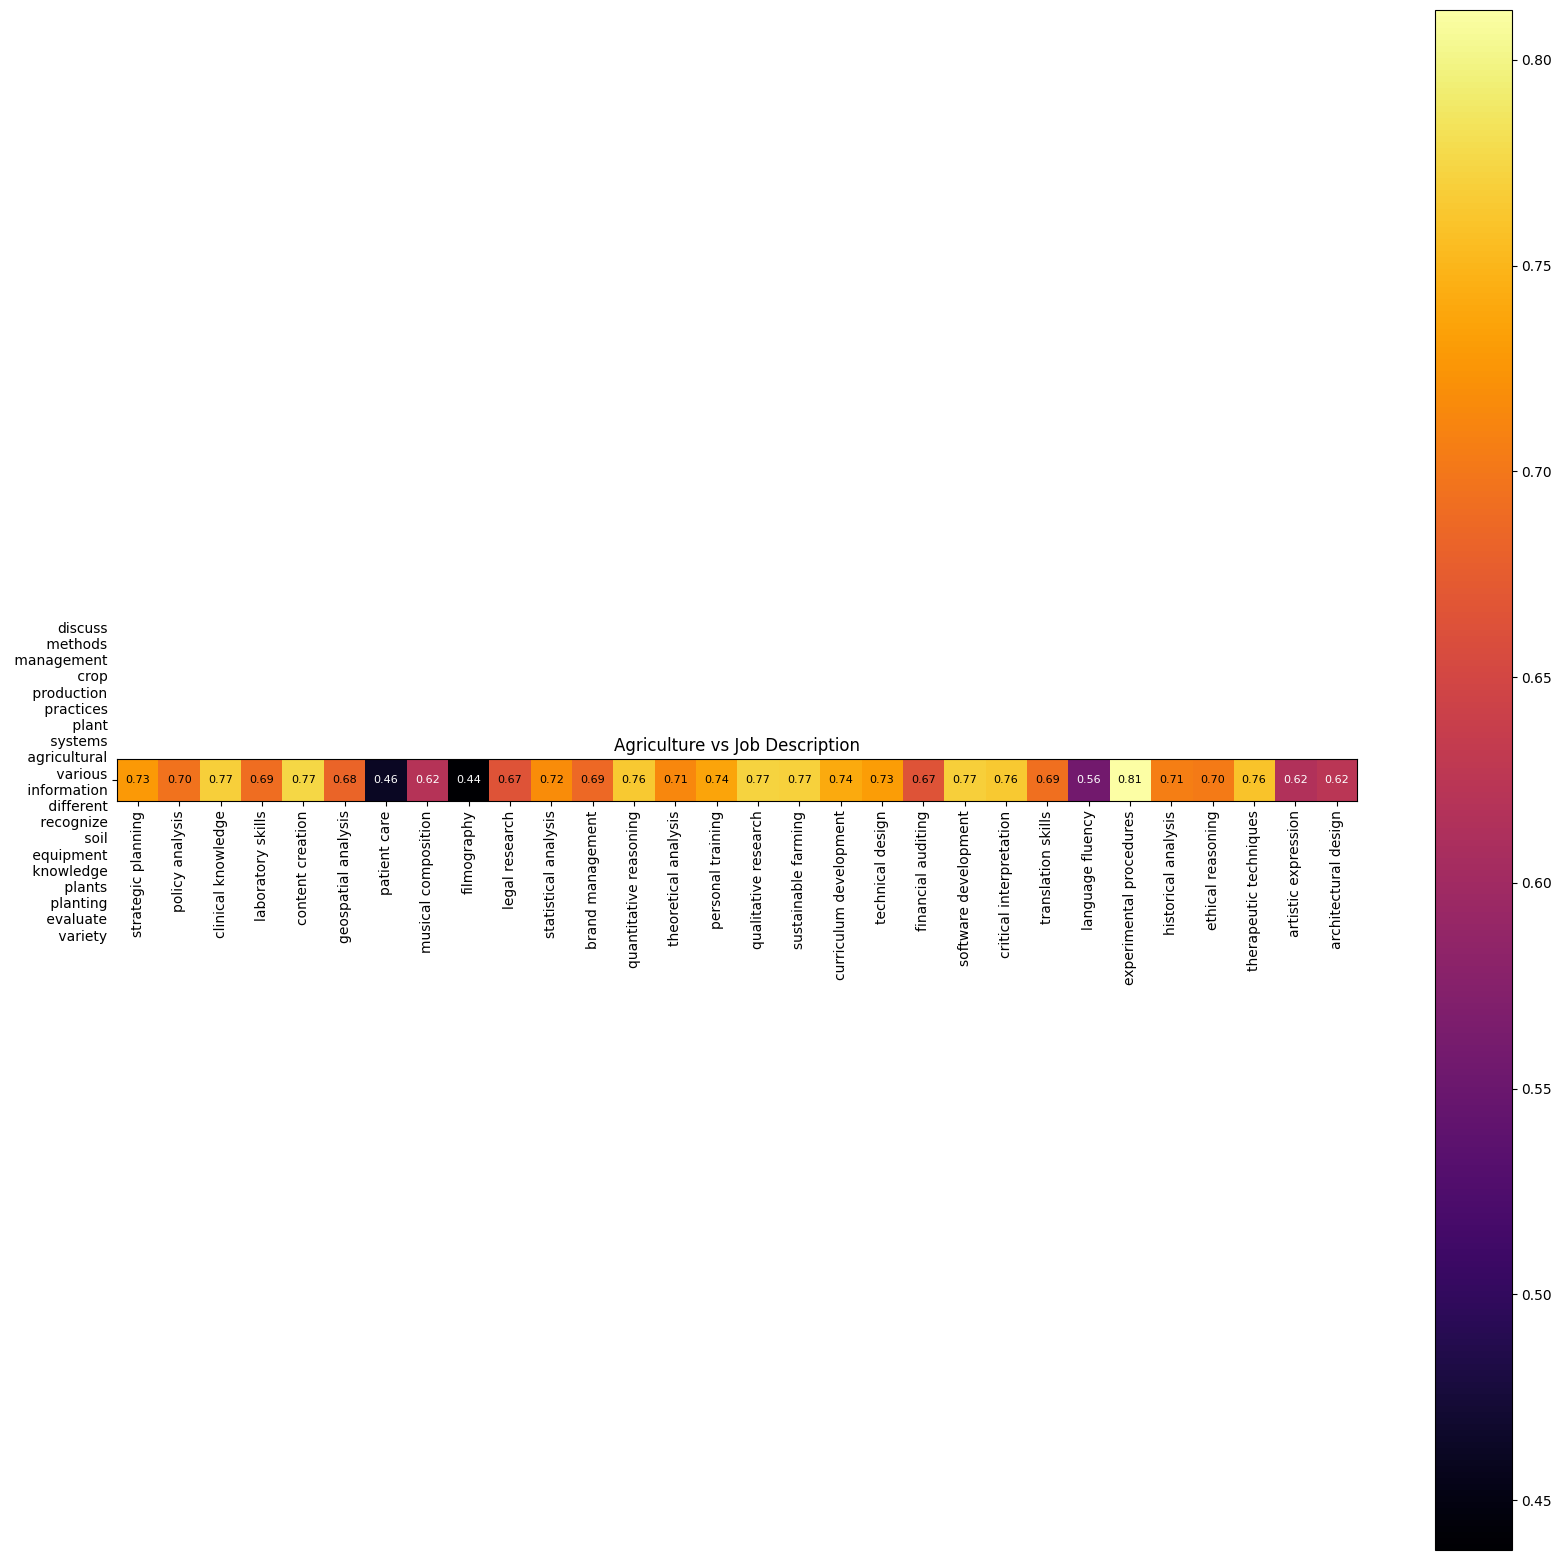

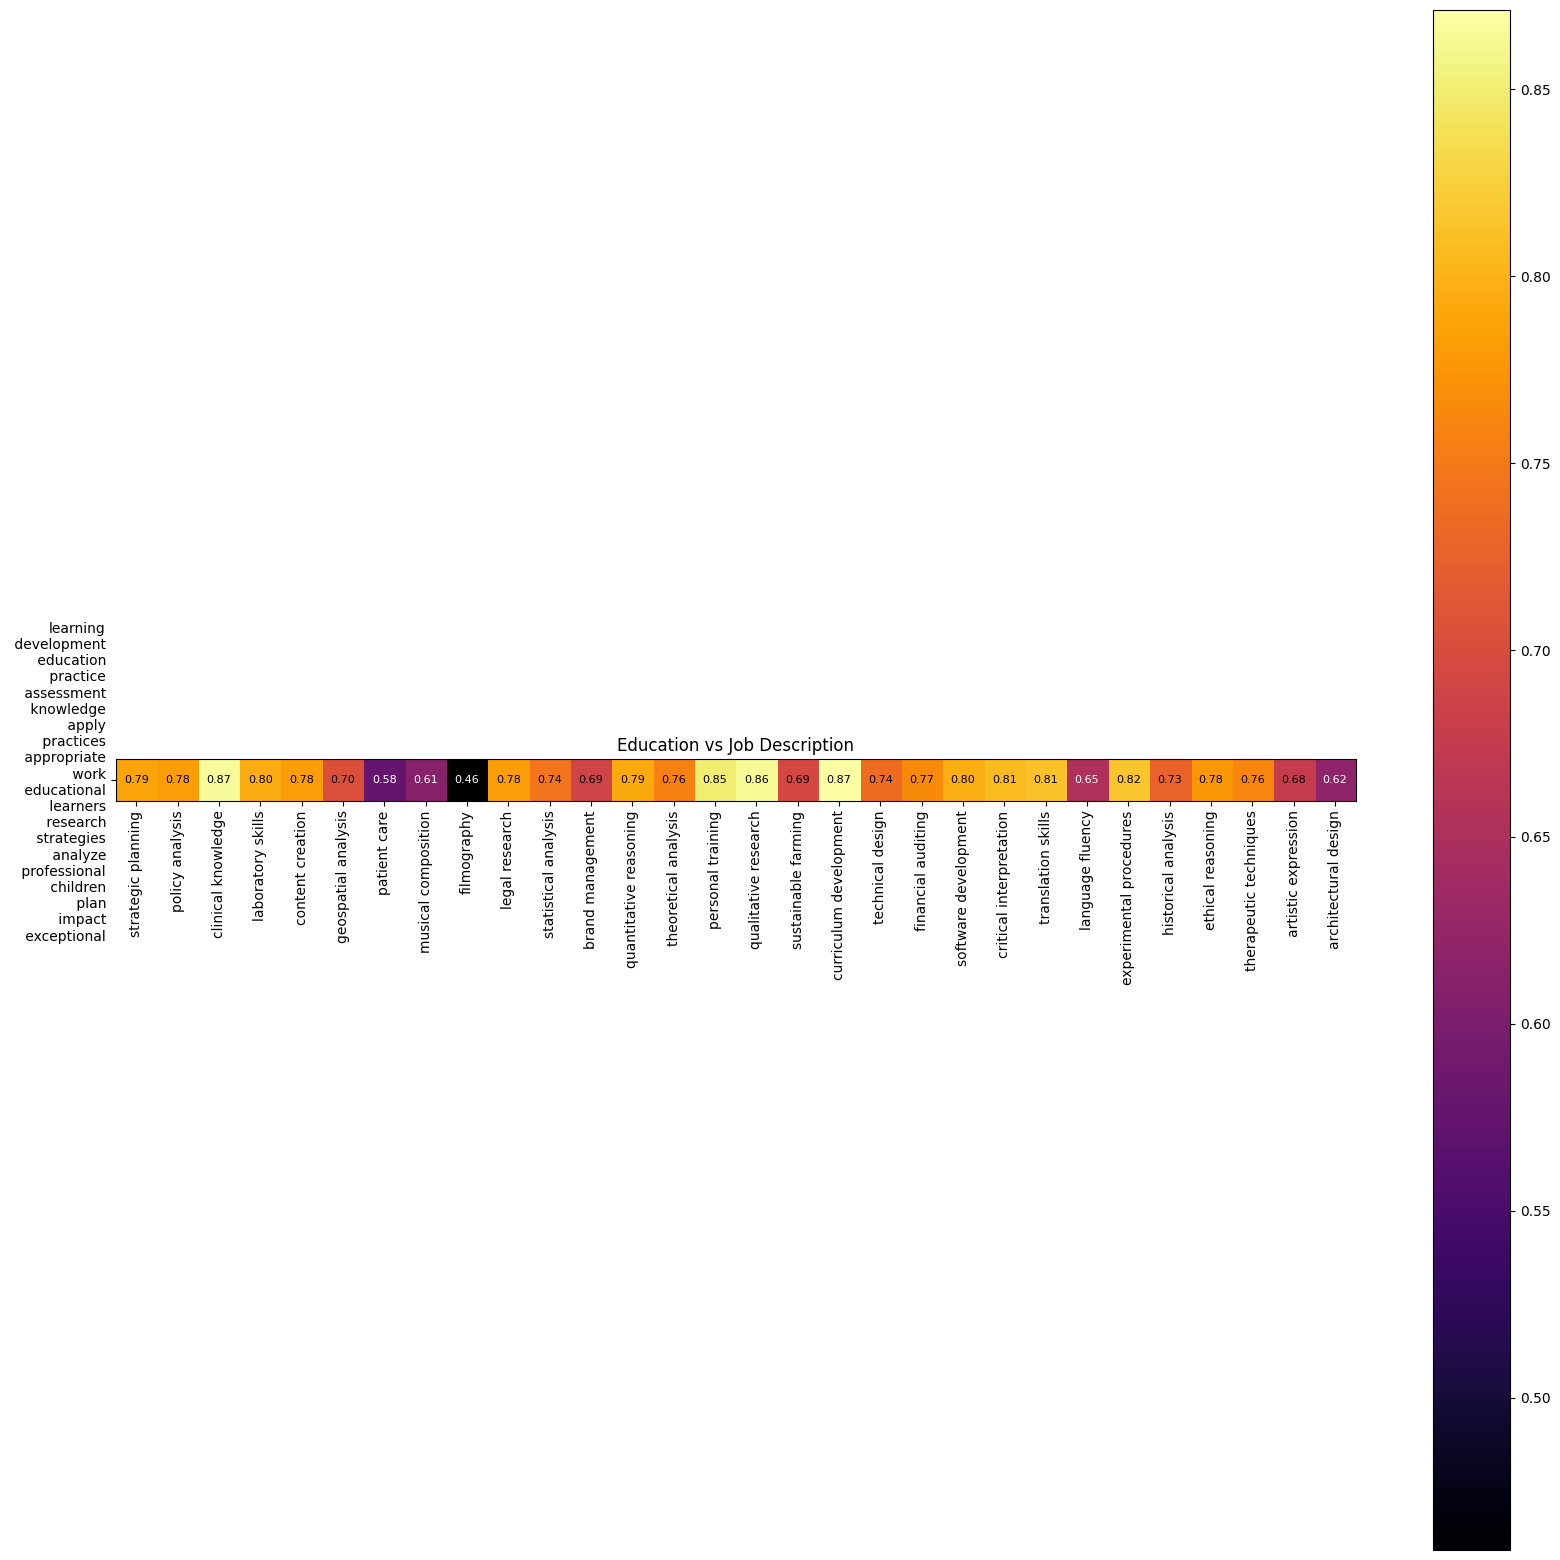

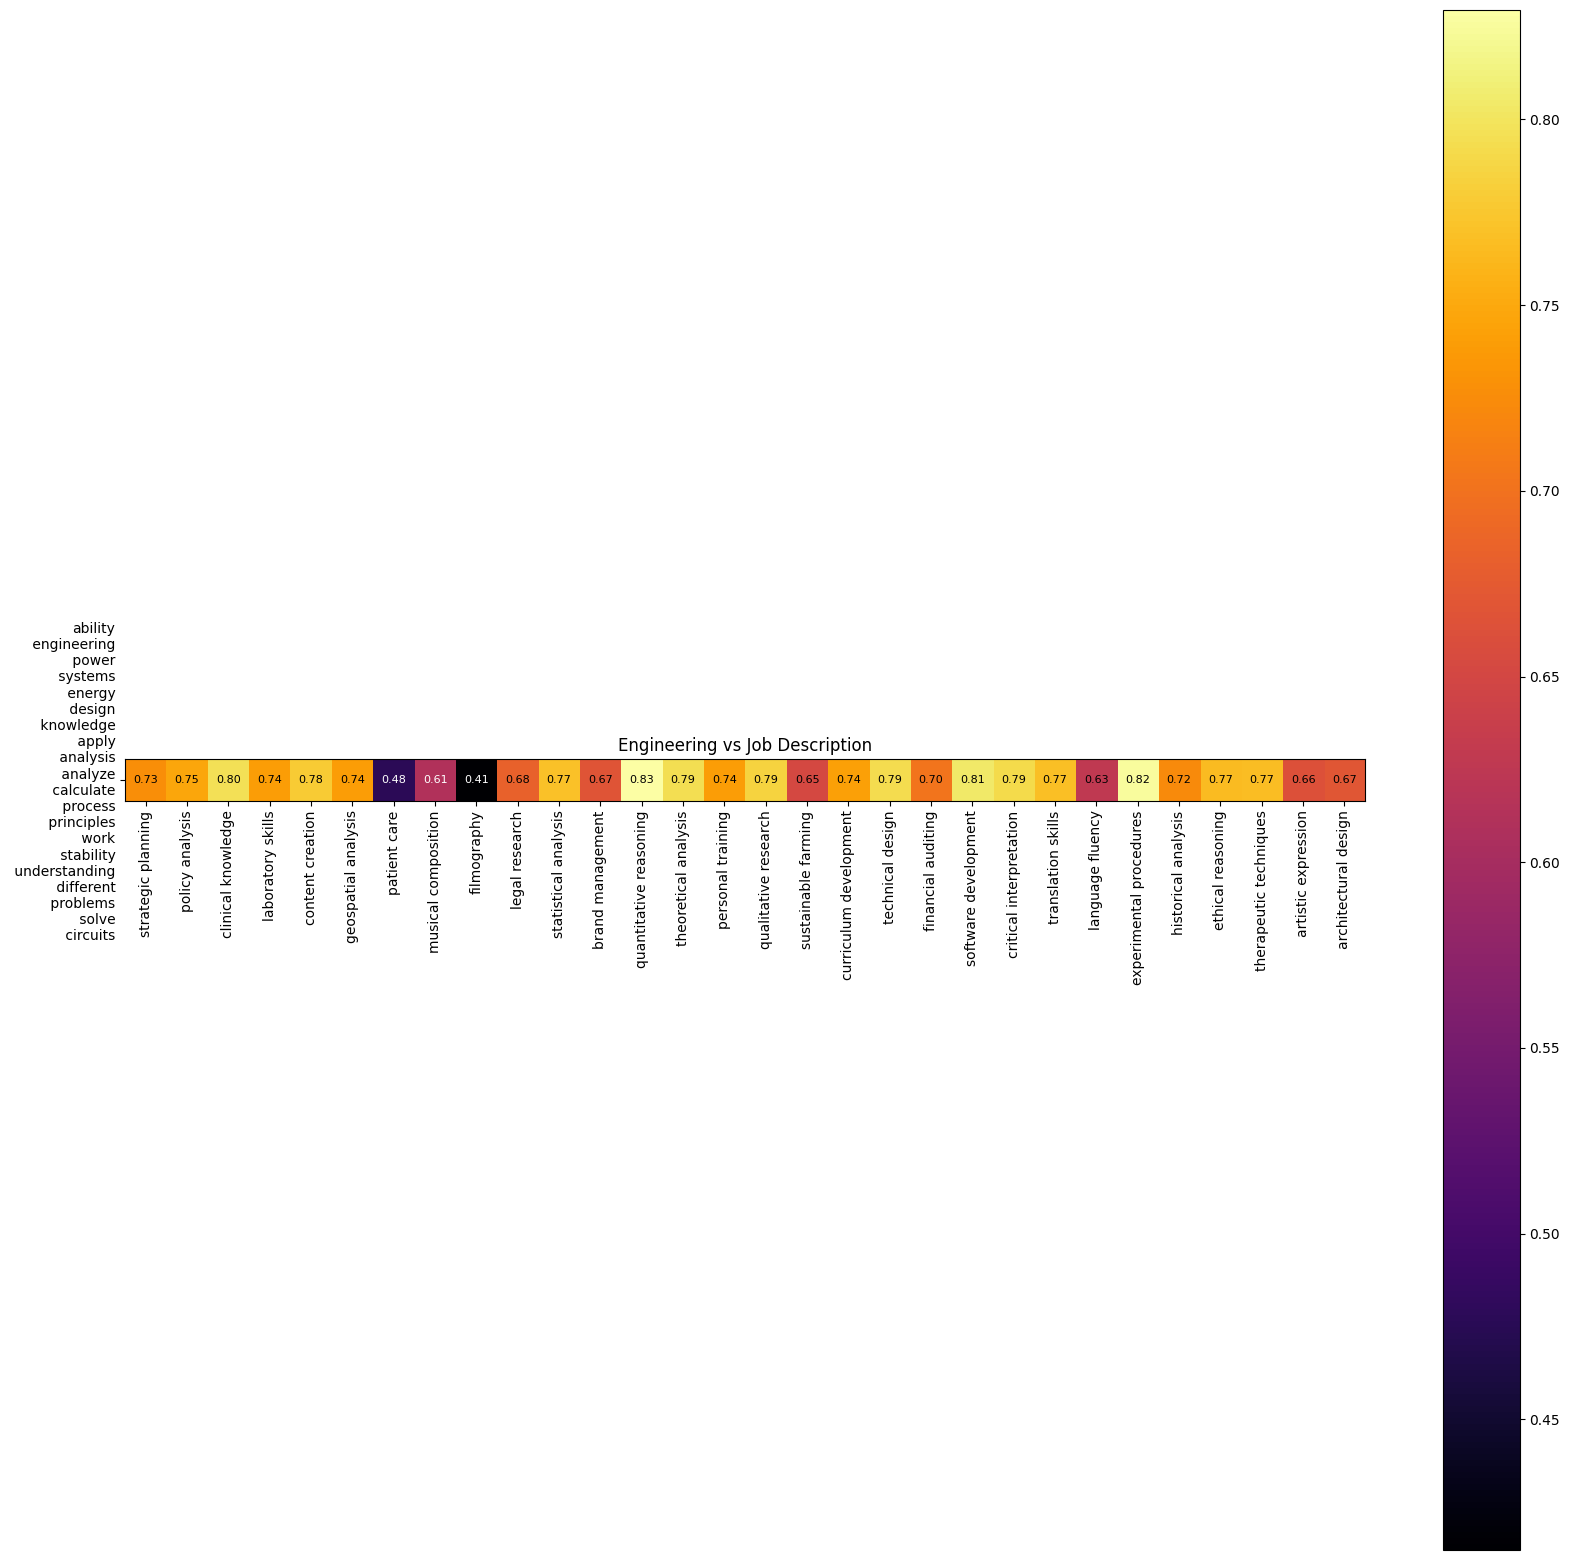

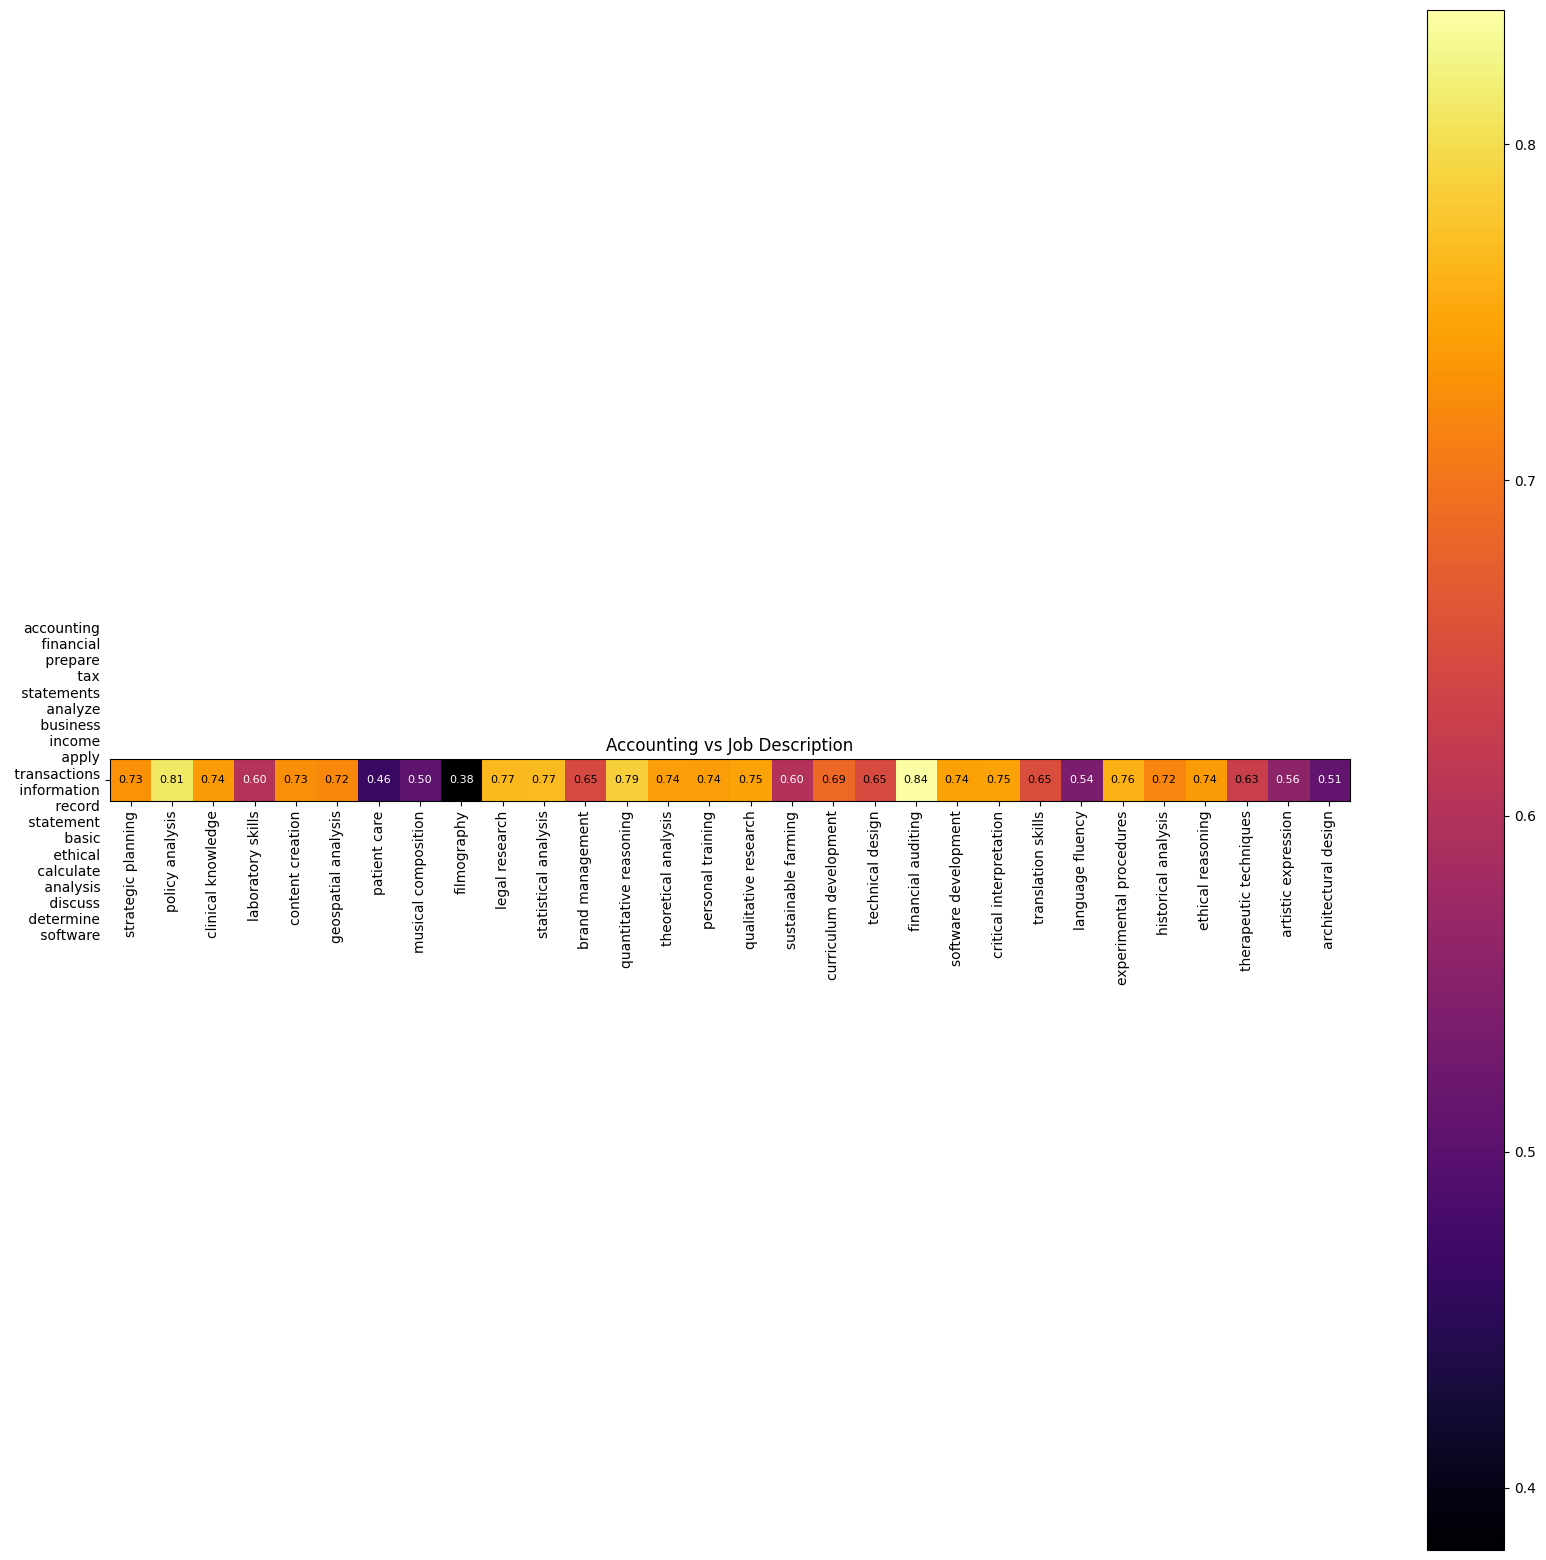

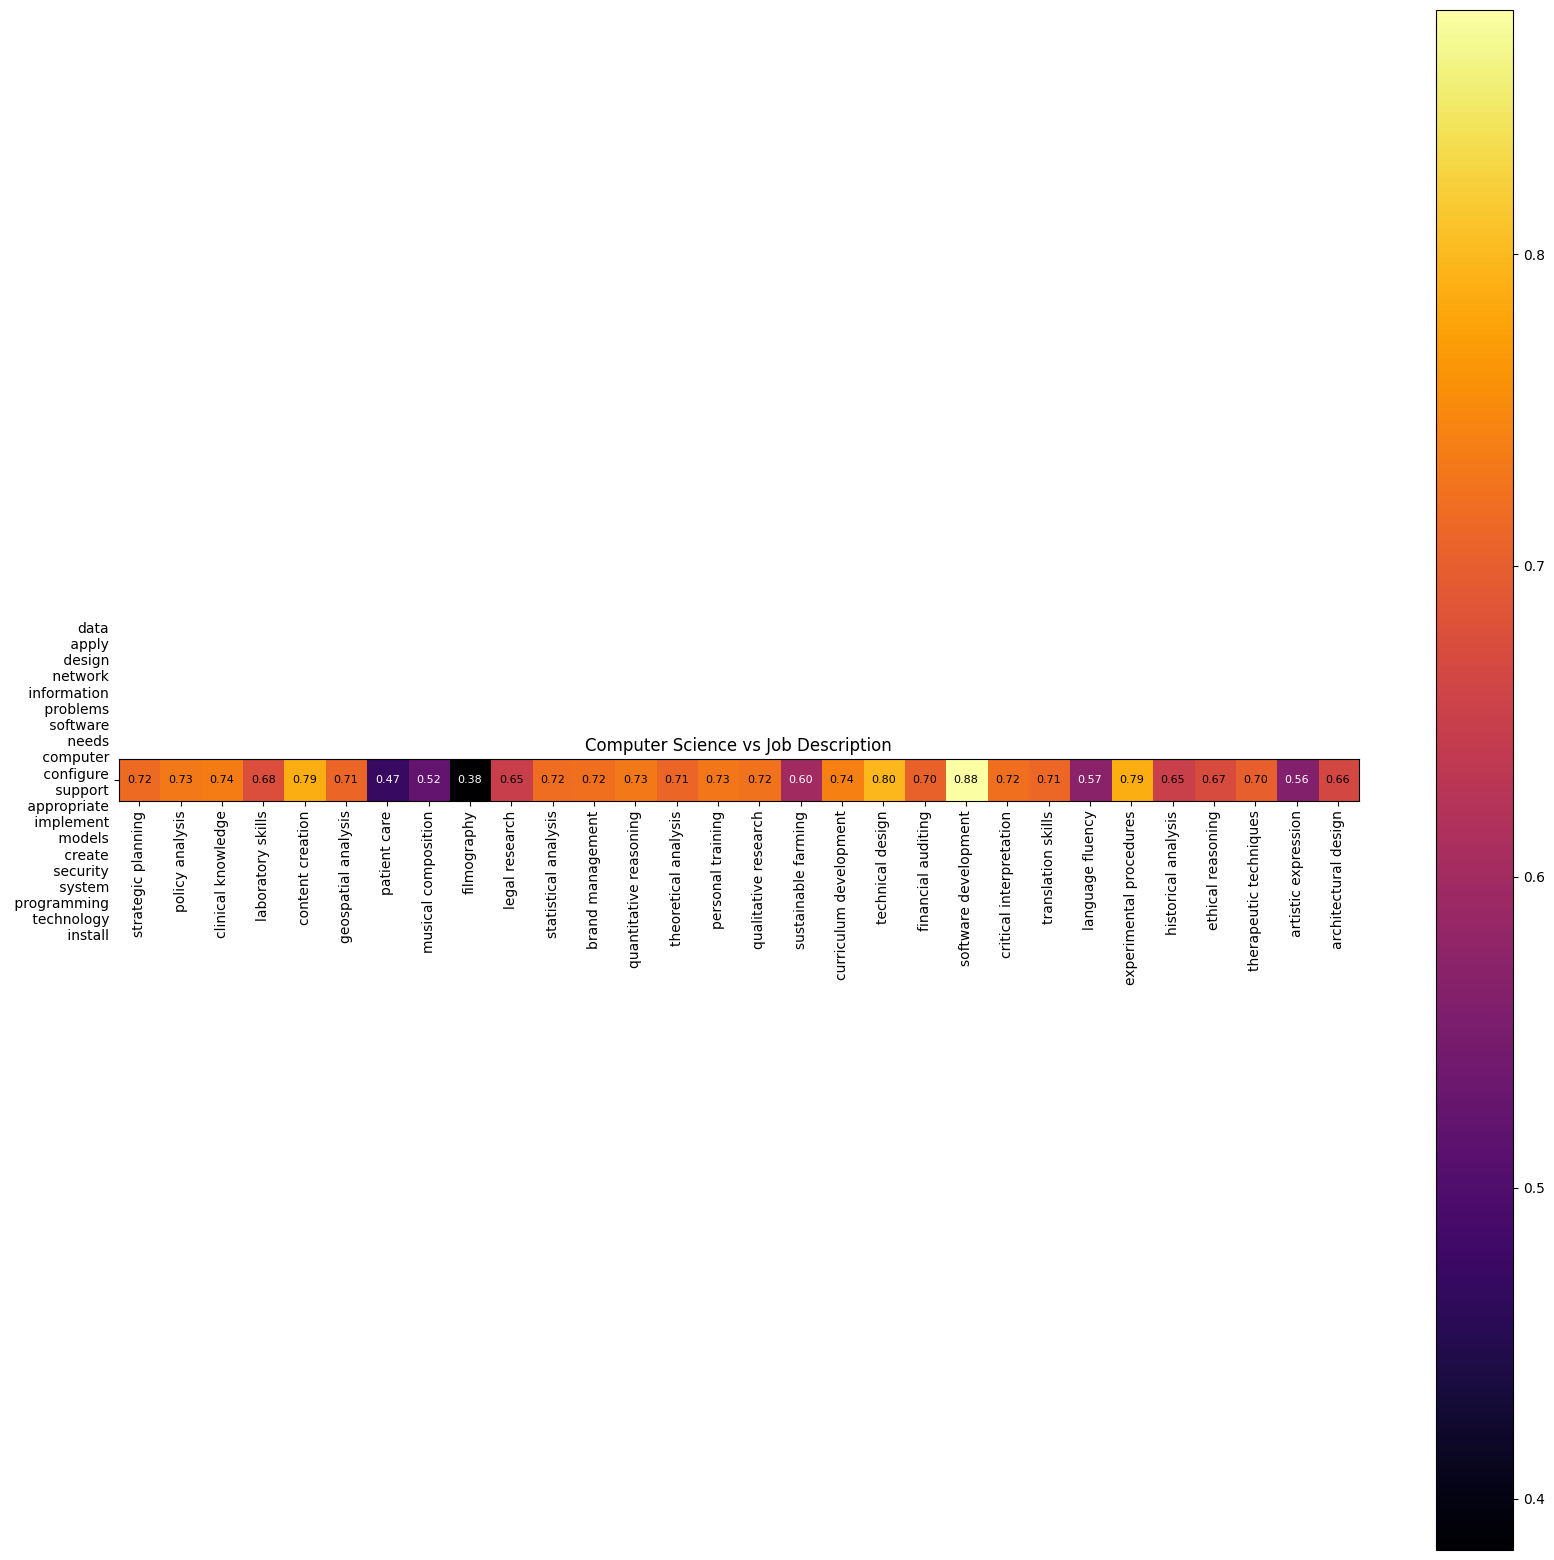

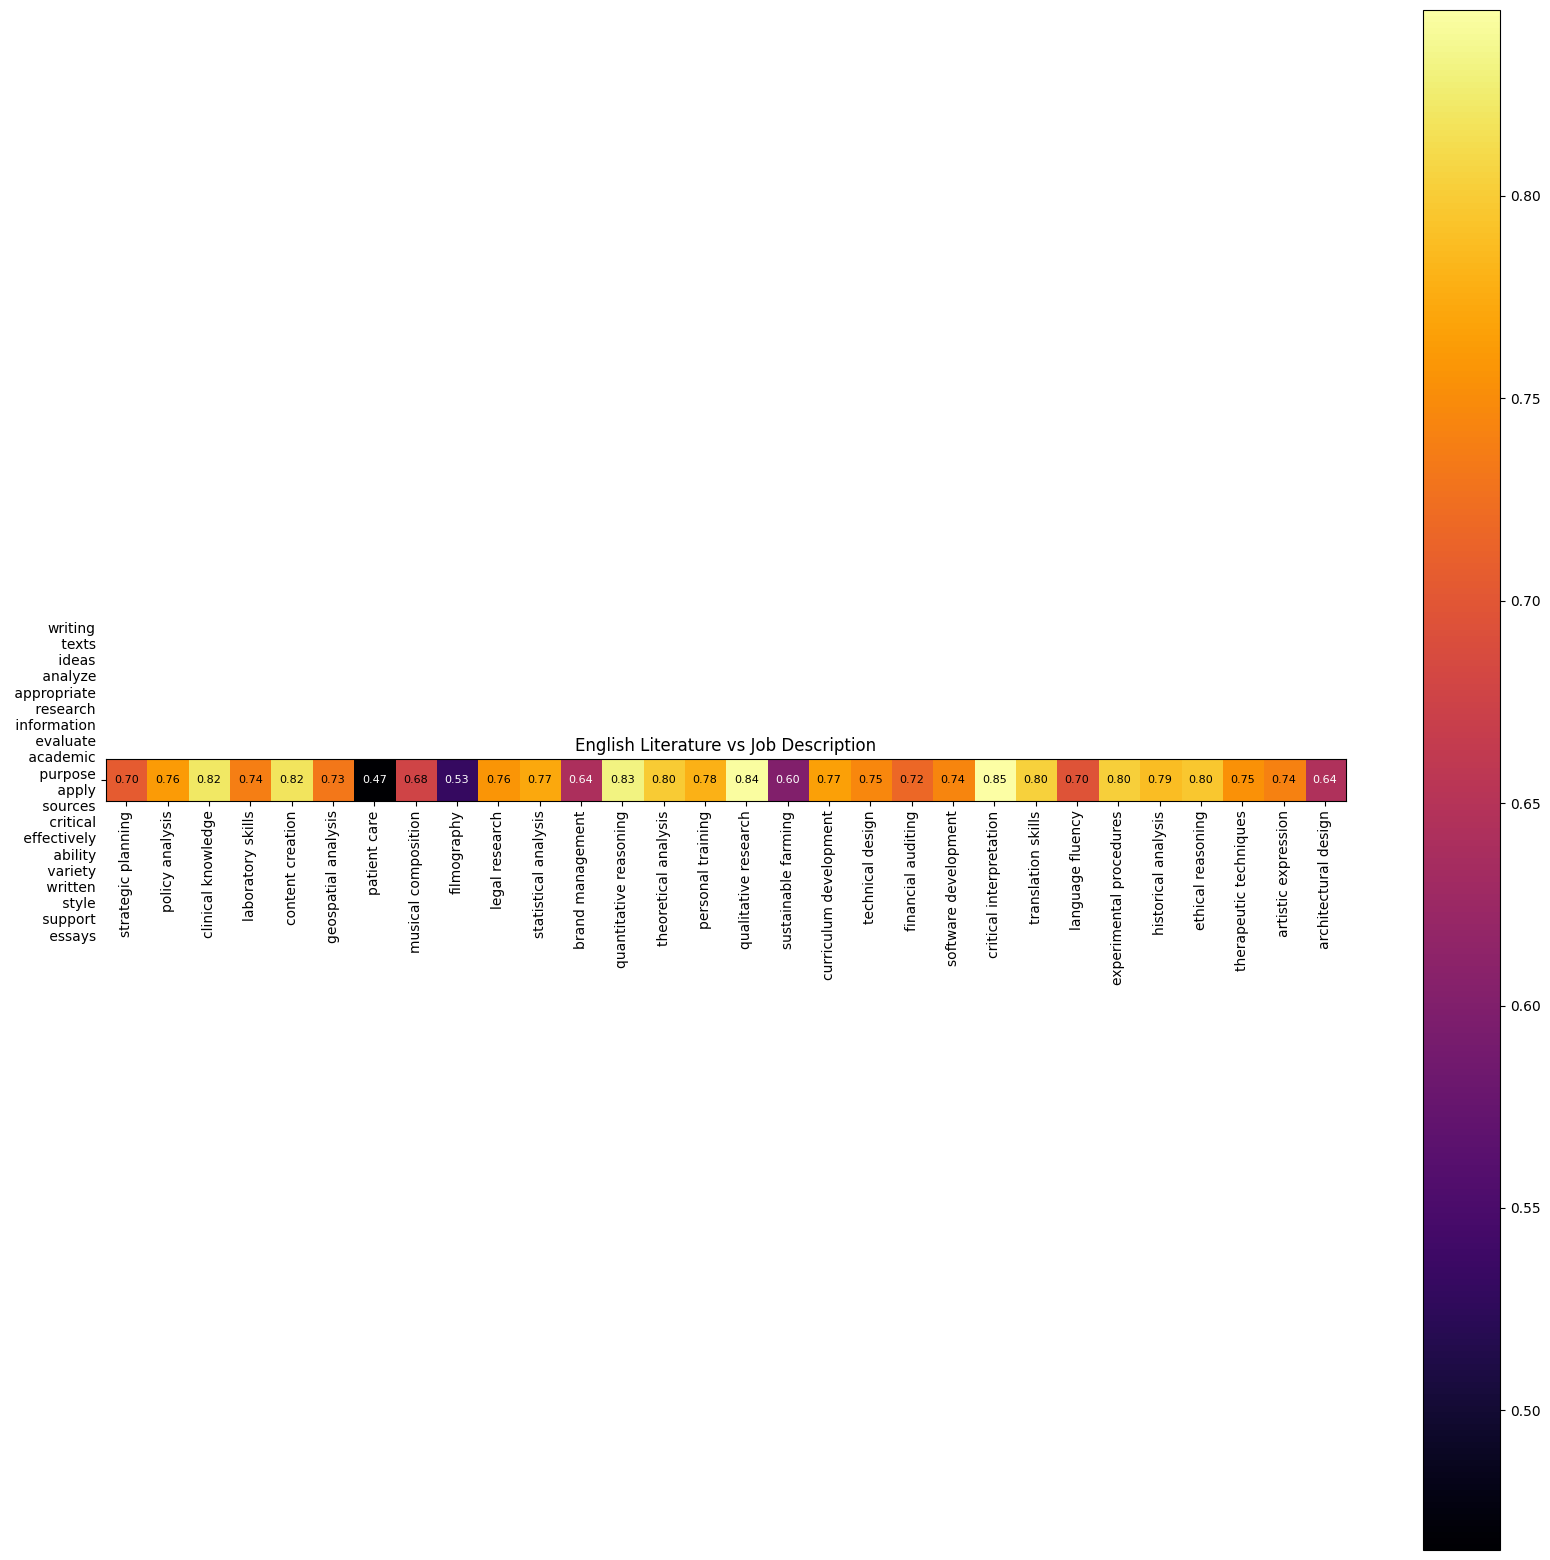

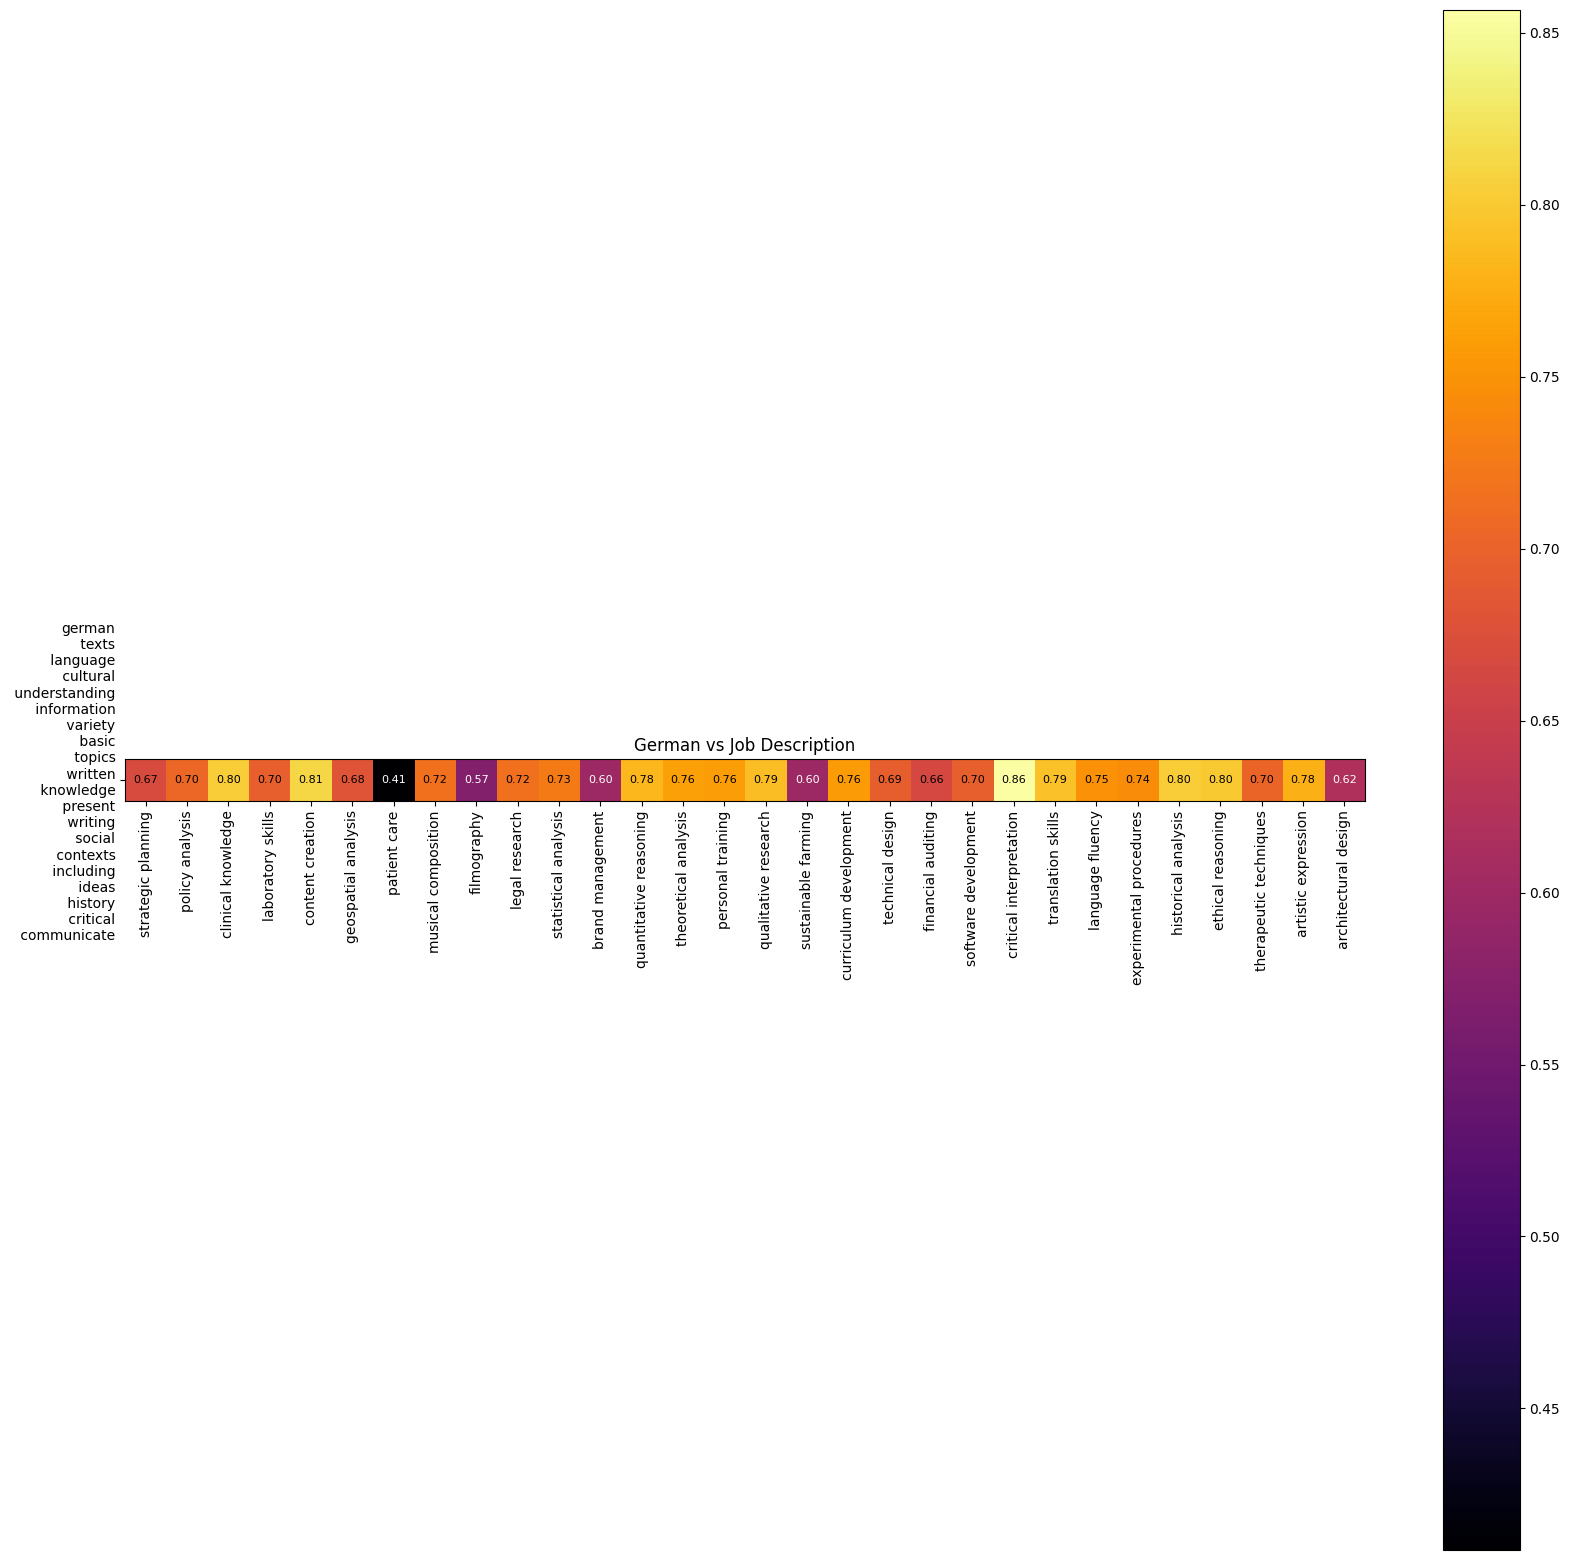

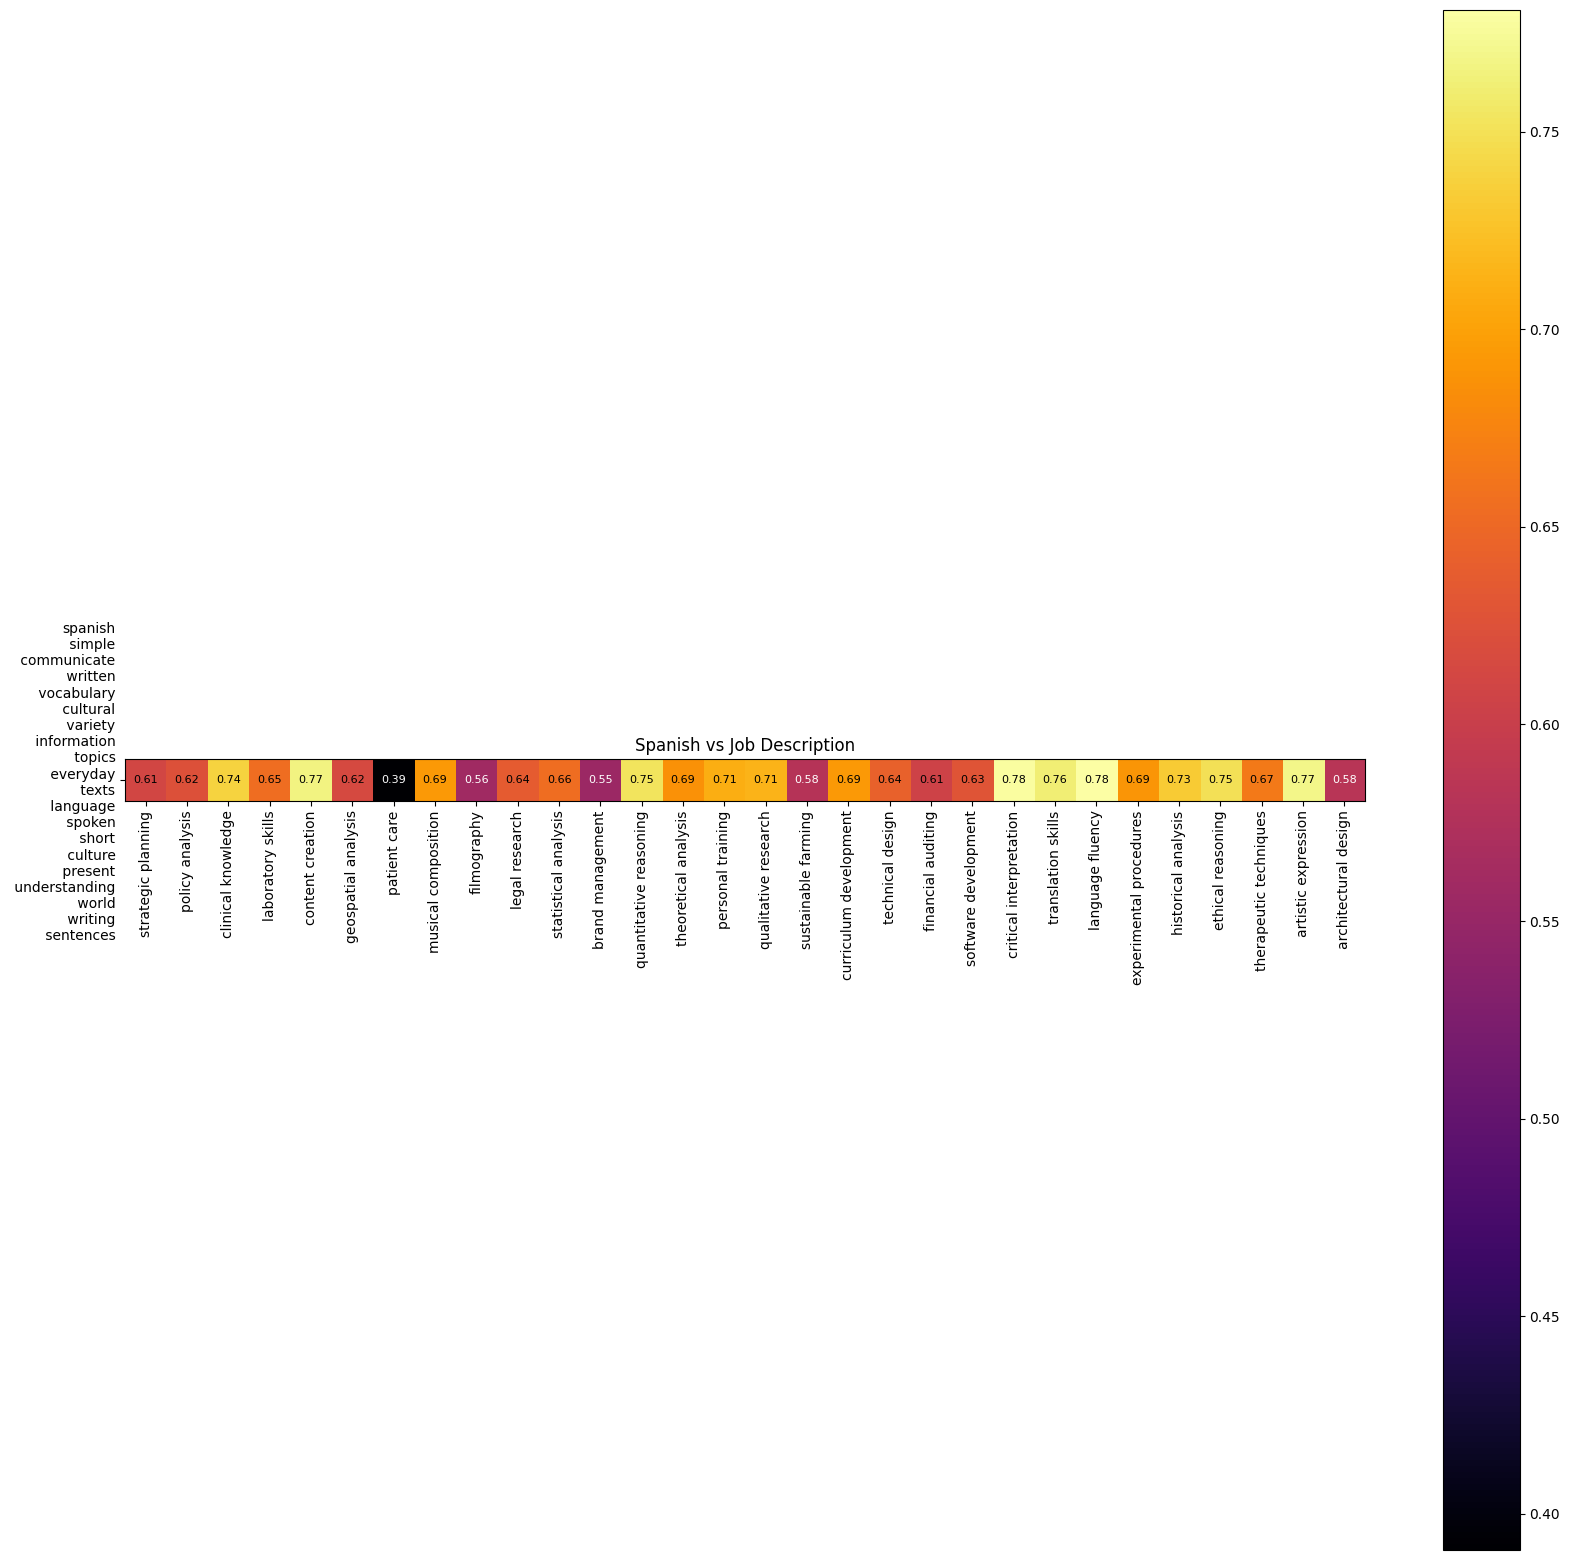

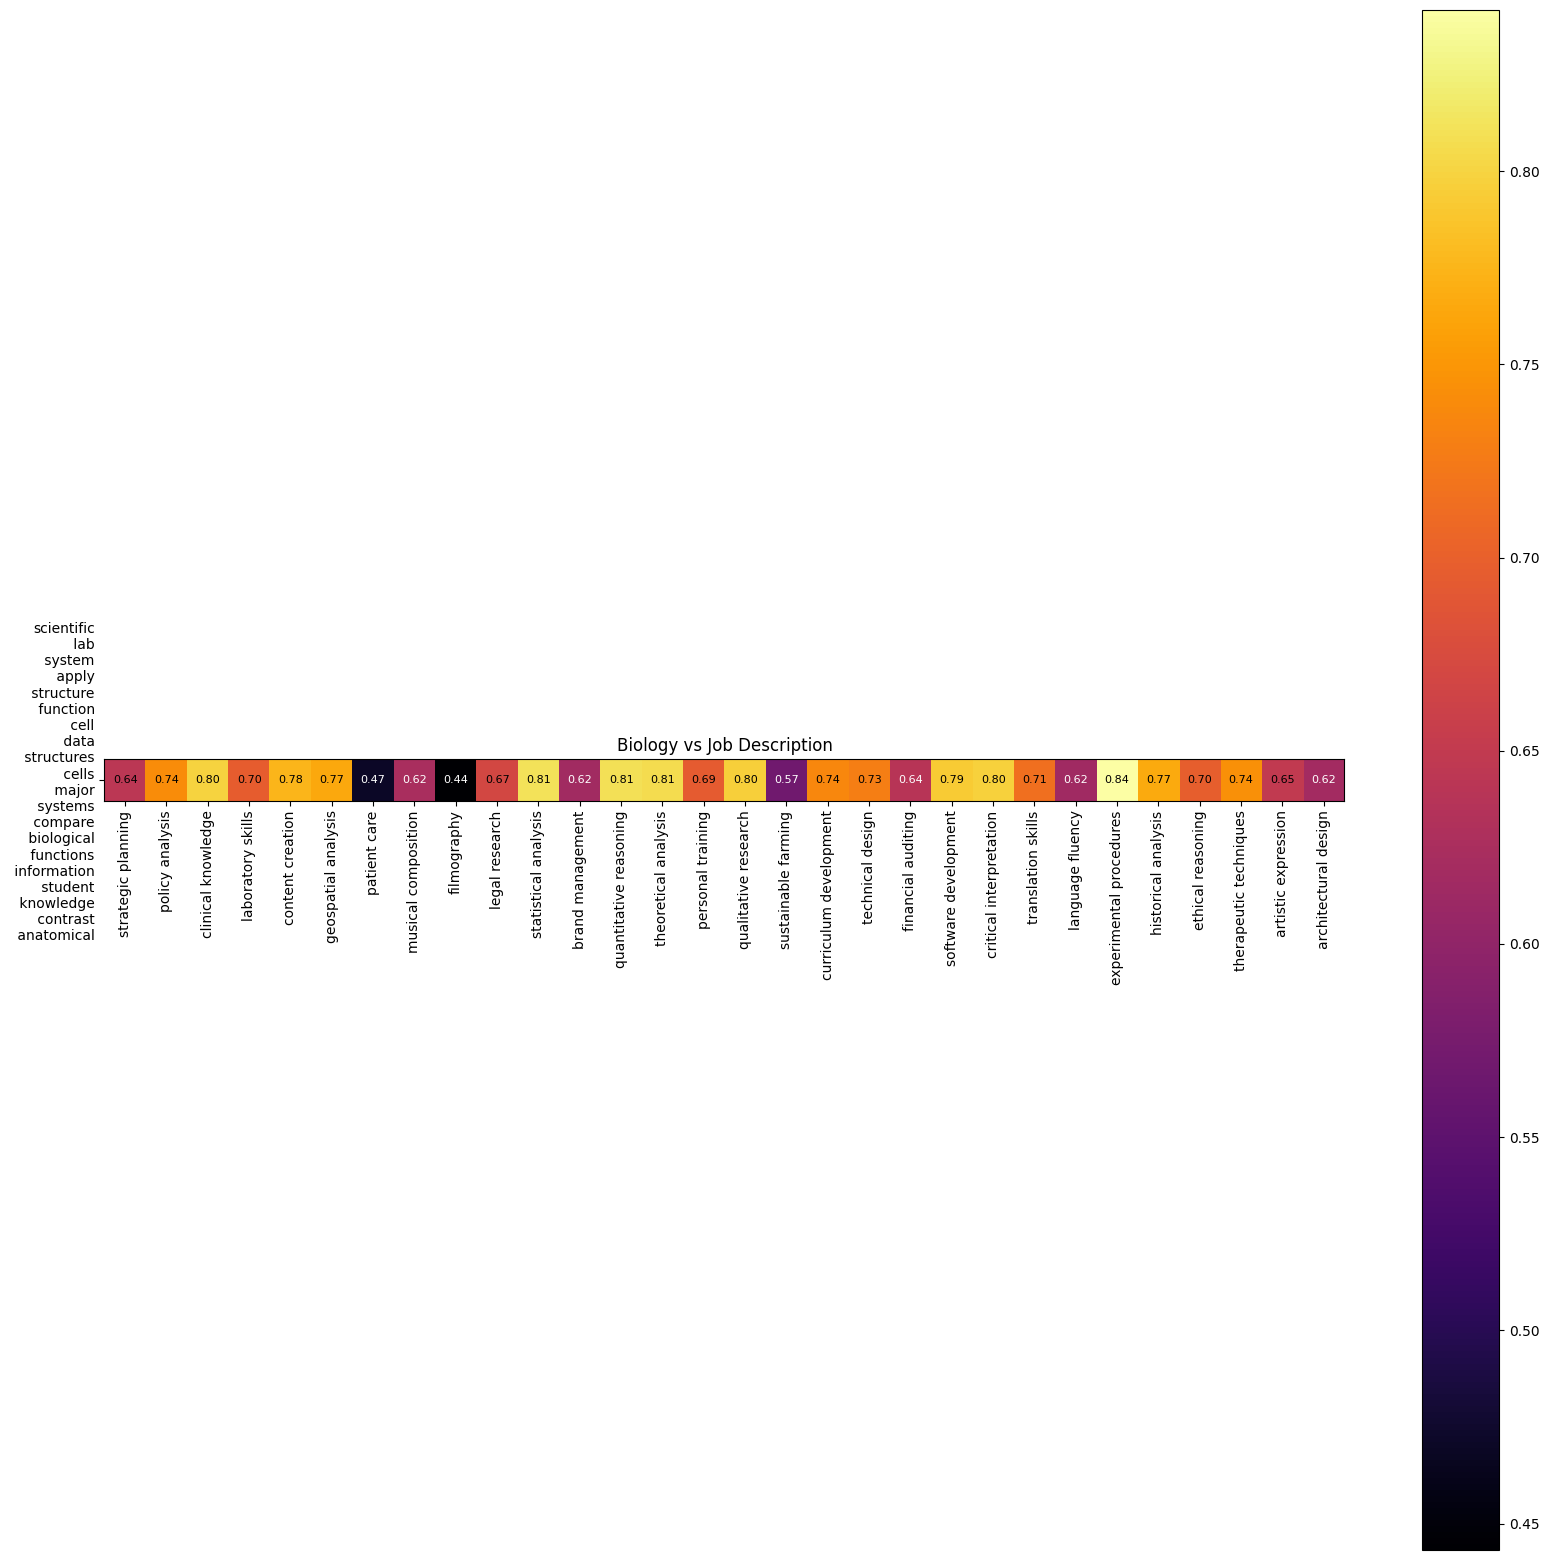

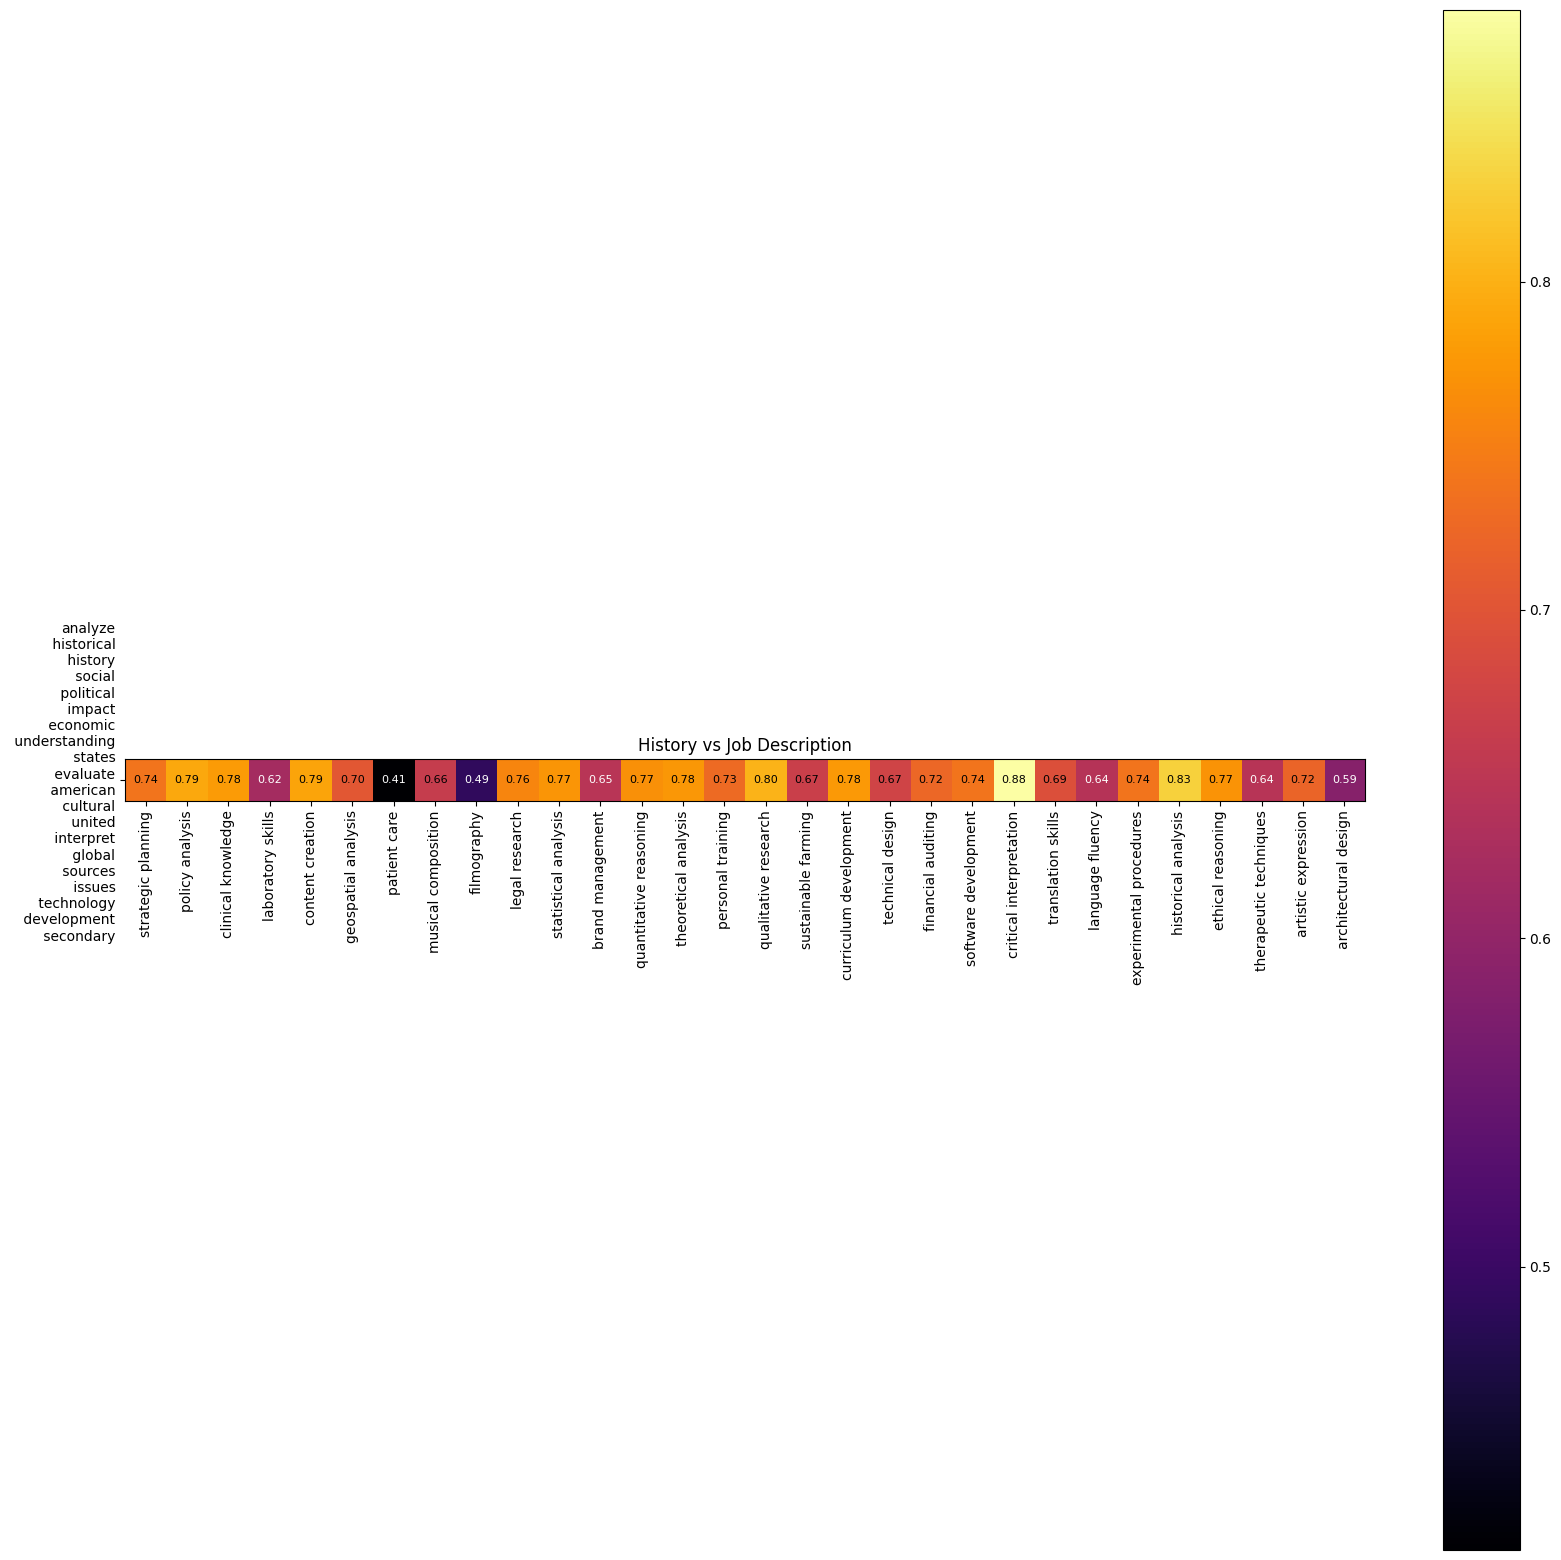

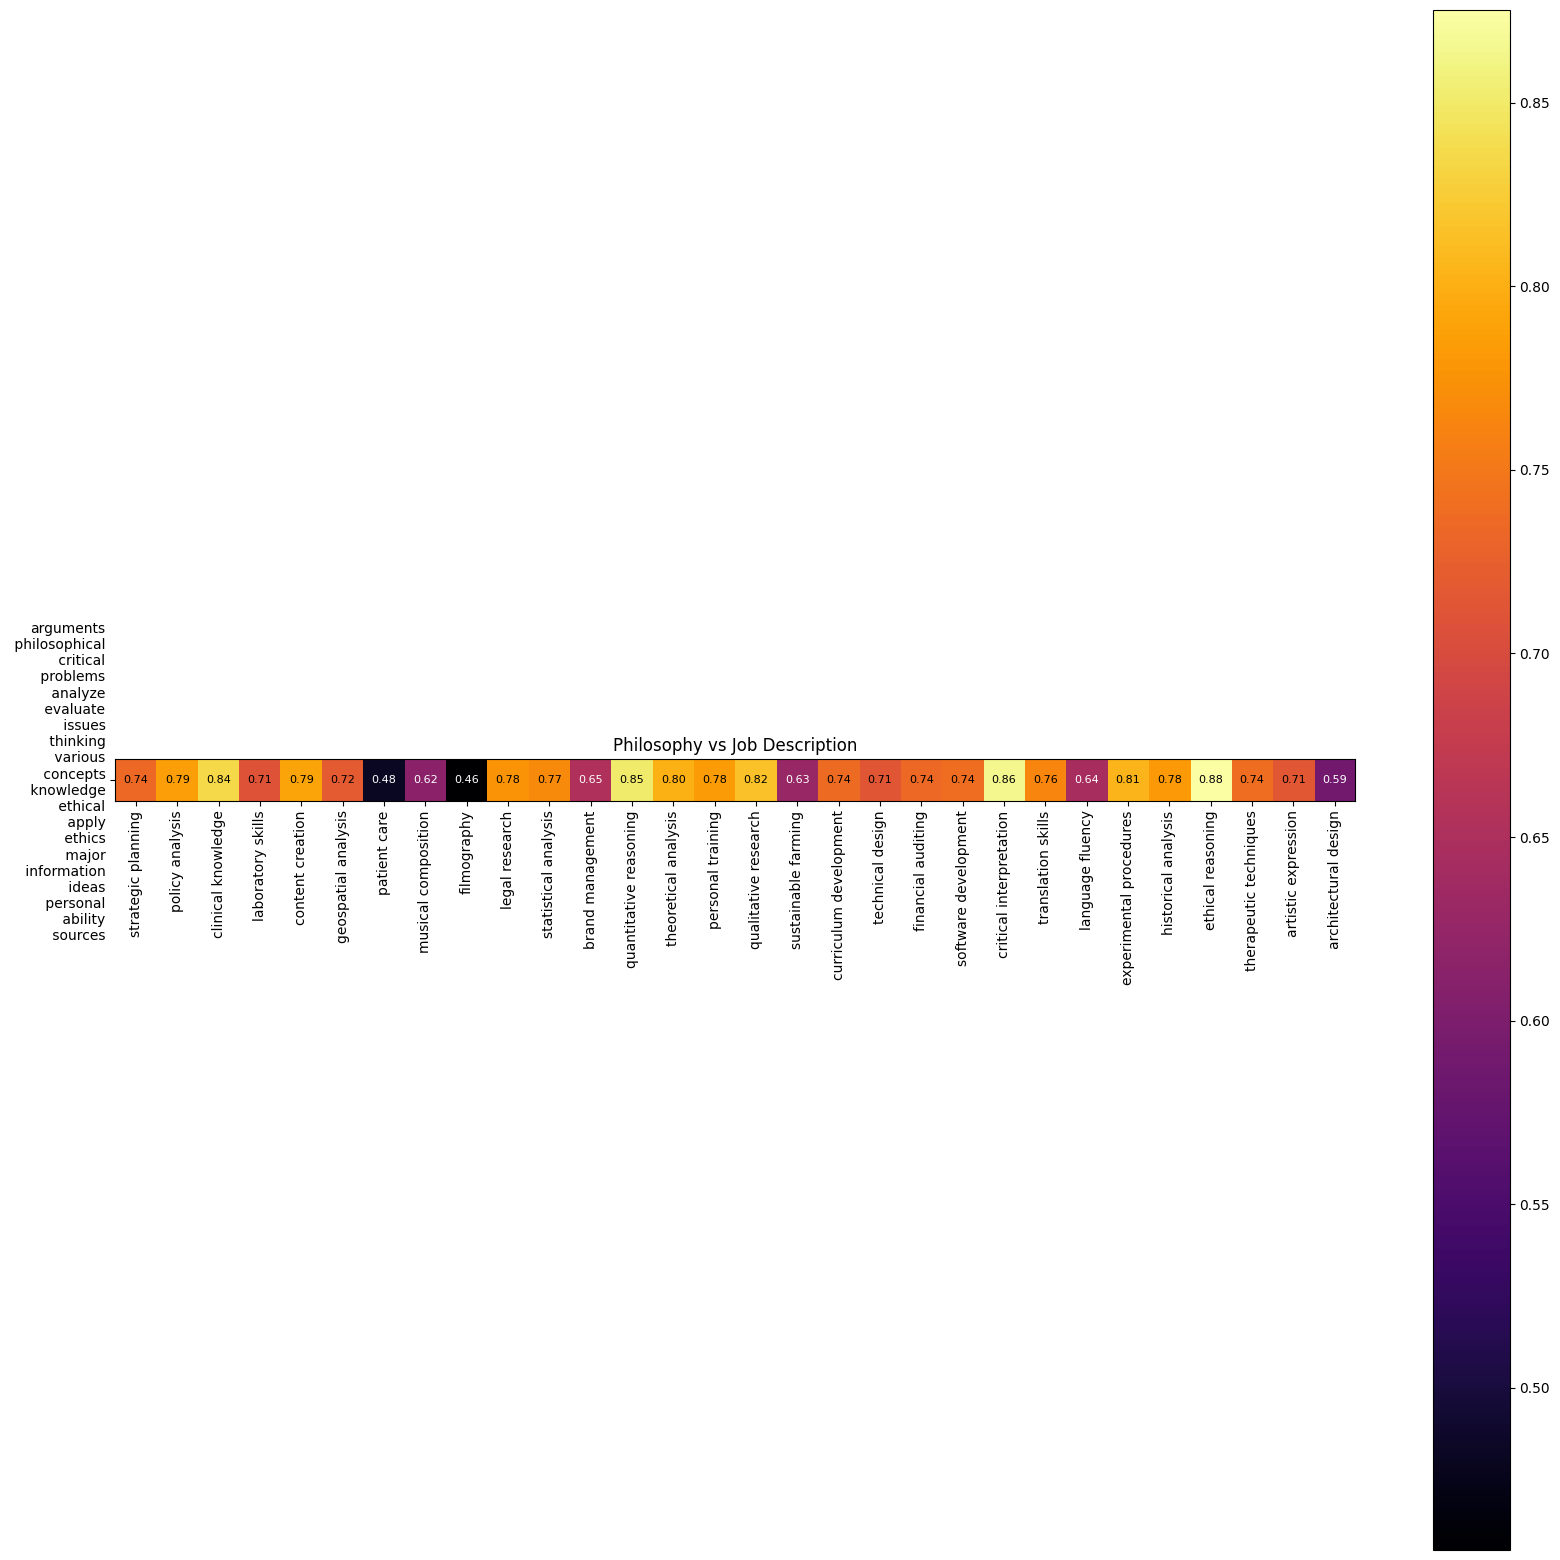

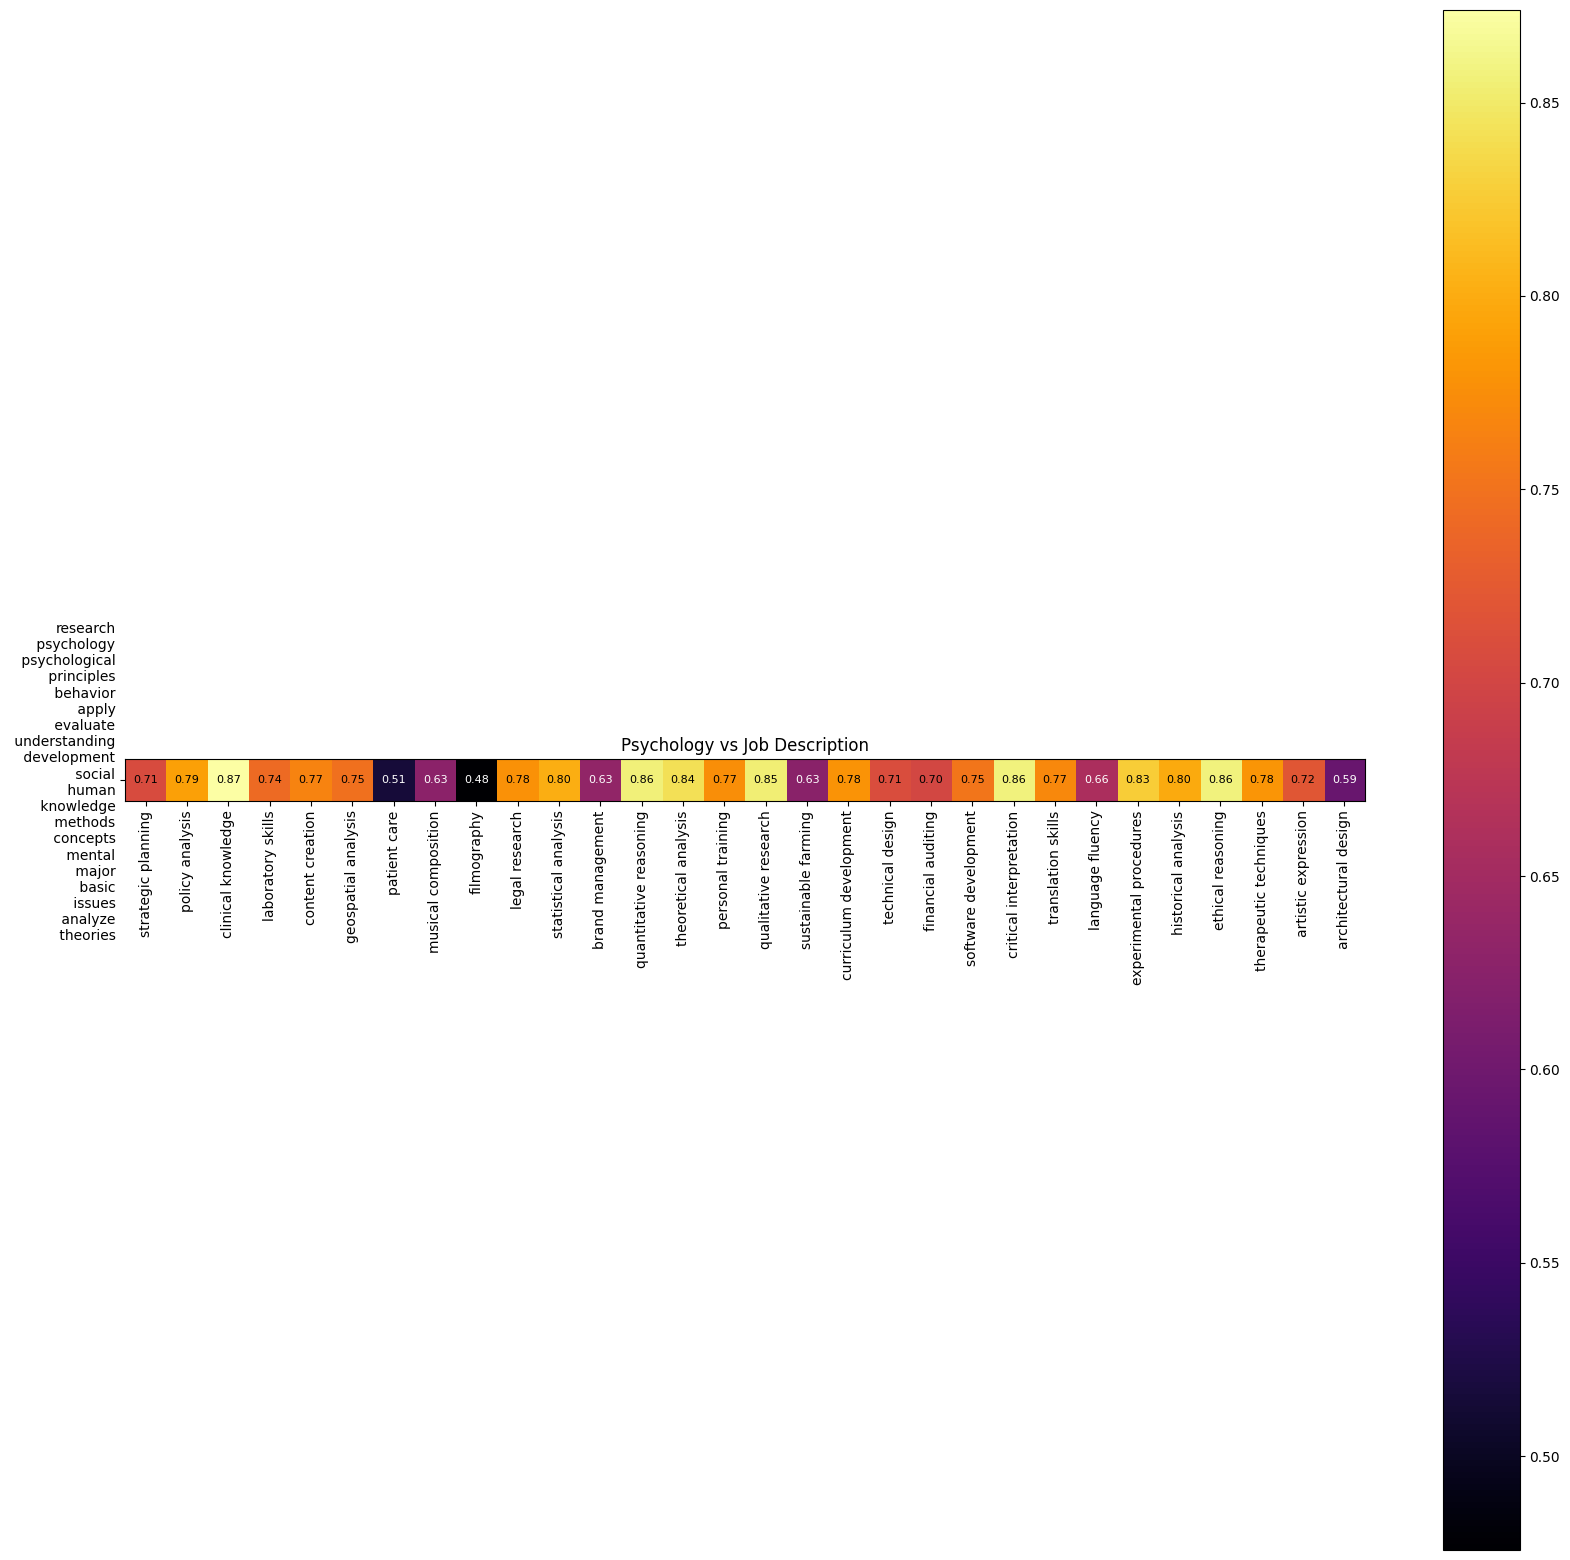

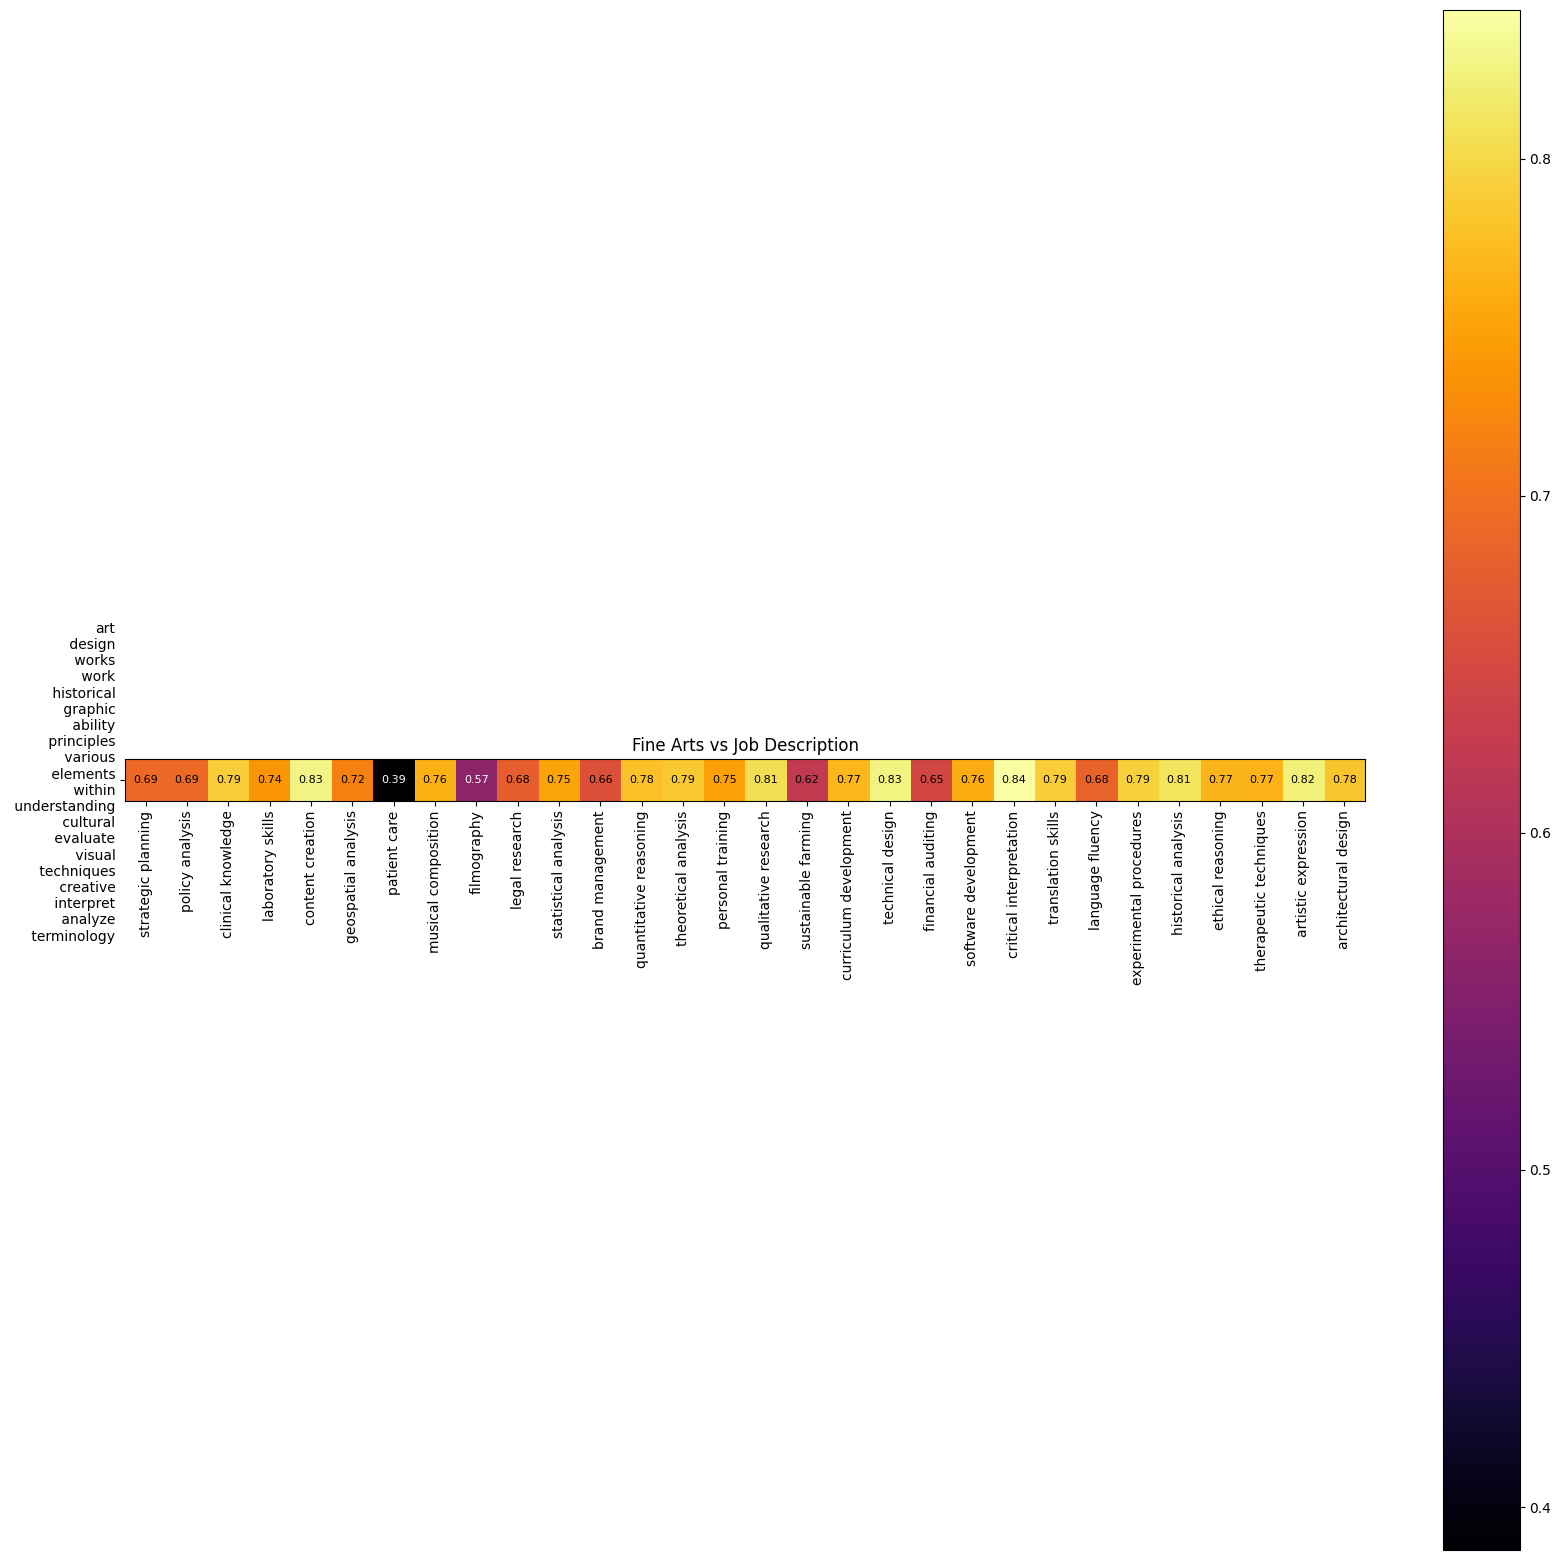

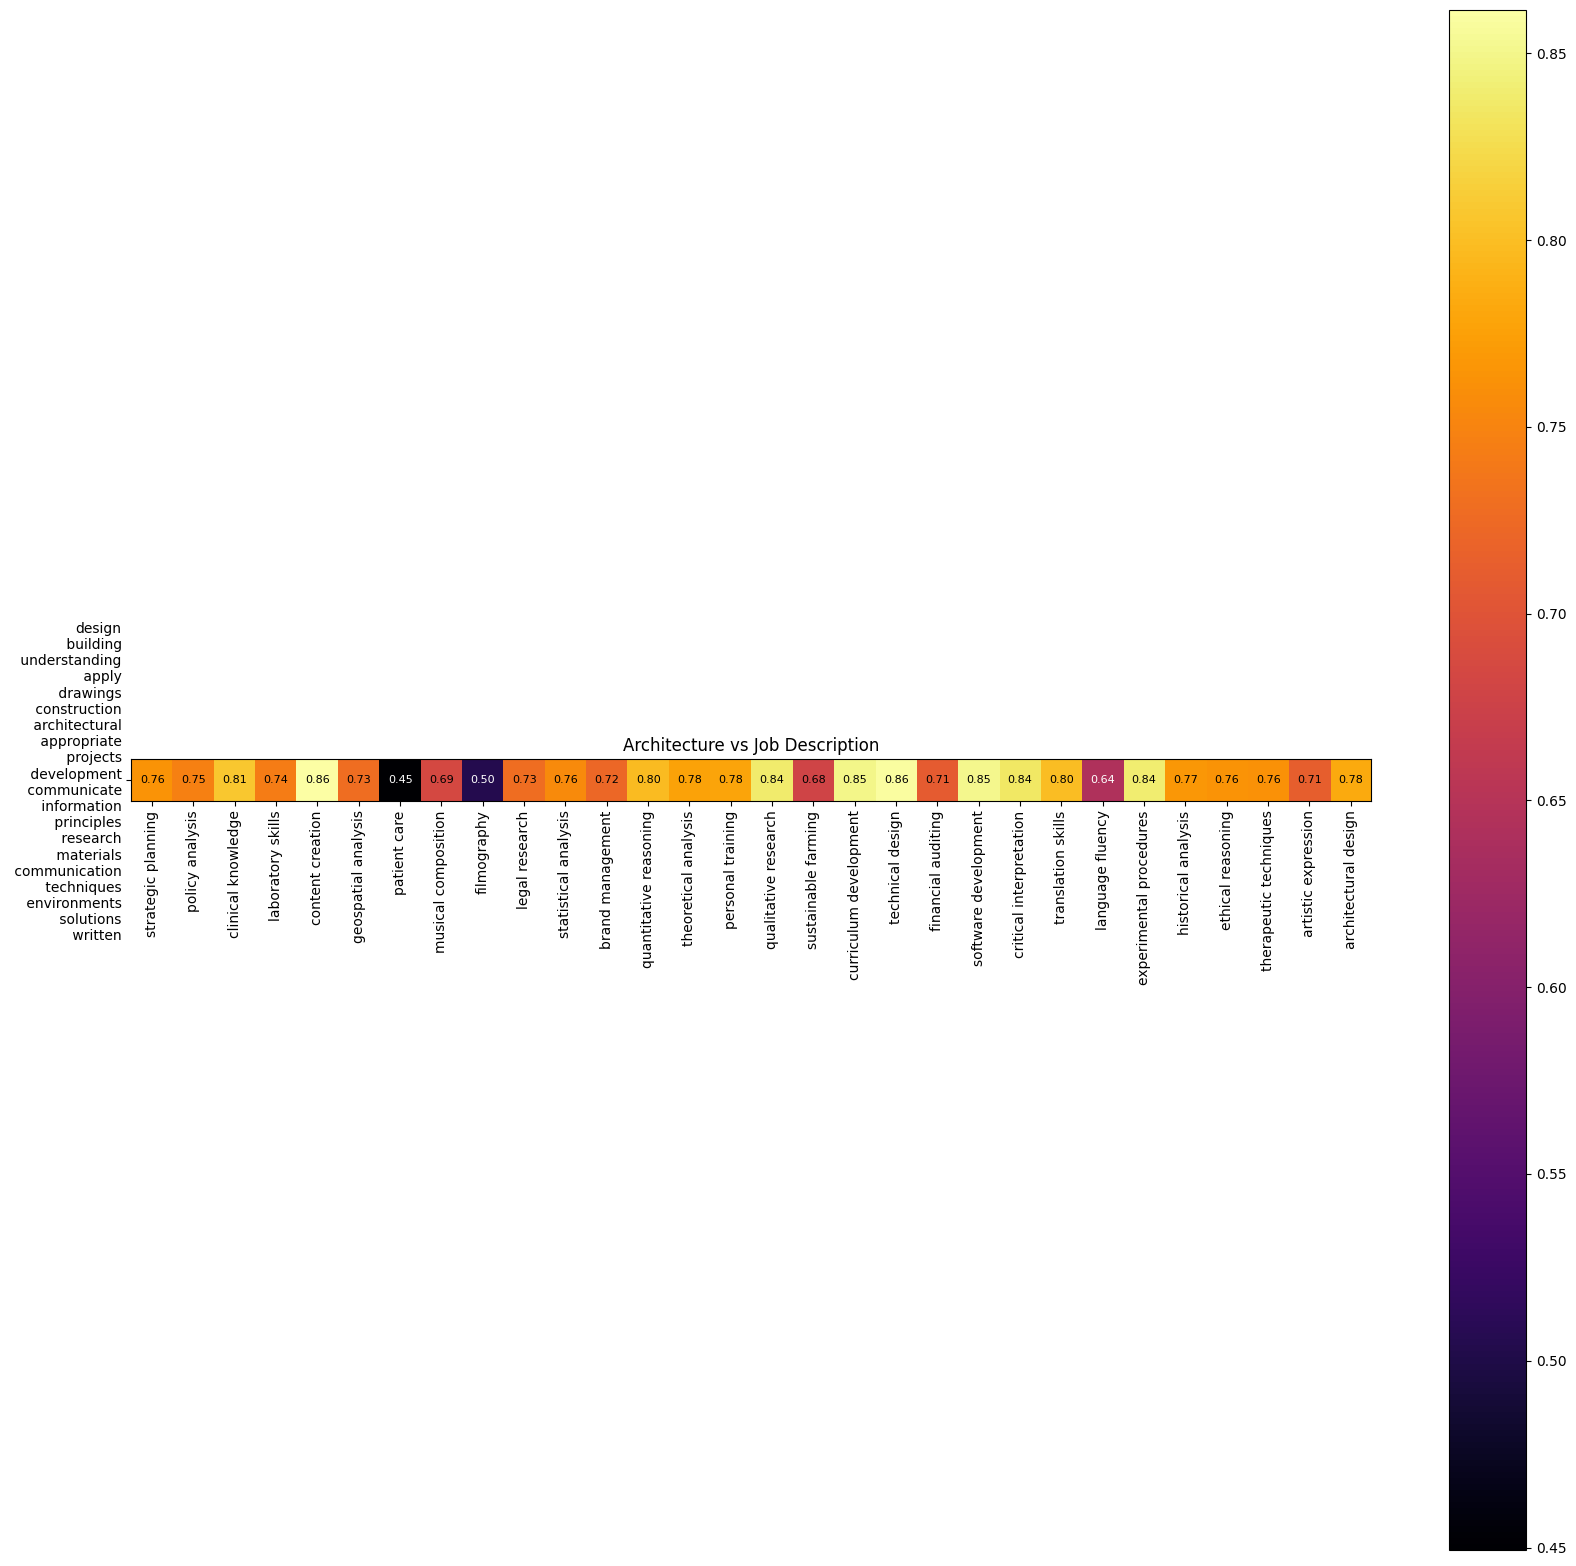

In [62]:
predefined_skills = [
    'strategic planning',          # Business
    'policy analysis',             # Political Science
    'clinical knowledge',          # Medicine
    'laboratory skills',           # Chemistry
    'content creation',            # Media / Communications
    'geospatial analysis',         # Earth Sciences
    'patient care',                # Nursing
    'musical composition',         # Music
    'filmography',                 # Film and Photography
    'legal research',              # Law
    'statistical analysis',        # Economics
    'brand management',            # Marketing
    'quantitative reasoning',      # Mathematics
    'theoretical analysis',        # Physics
    'personal training',           # Fitness/Leisure
    'qualitative research',        # Sociology
    'sustainable farming',         # Agriculture
    'curriculum development',      # Education
    'technical design',            # Engineering
    'financial auditing',          # Accounting
    'software development',        # Computer Science
    'critical interpretation',     # English Literature
    'translation skills',          # German
    'language fluency',            # Spanish
    'experimental procedures',     # Biology
    'historical analysis',         # History
    'ethical reasoning',           # Philosophy
    'therapeutic techniques',      # Psychology
    'artistic expression',         # Fine Arts
    'architectural design'         # Architecture
]

skill_vectors = [get_average_vector([skill]) for skill in predefined_skills]


def create_cosine_similarity_heatmap(title, avg_vector1, avg_vector2, labels1, labels2, cmap='inferno'):
    plt.figure(figsize=(20, 20))
    plt.title(title)
    similarities = cosine_similarity(avg_vector1, avg_vector2)

    plt.imshow(similarities, cmap=cmap, interpolation='nearest')

   # Calculate the midpoint of the colormap range
    min_val, max_val = similarities.min(), similarities.max()
    midpoint = (max_val + min_val) / 2.0

    for i in range(similarities.shape[0]):
        for j in range(similarities.shape[1]):
            # Choose text color based on comparison with midpoint
            text_color = 'white' if similarities[i, j] < midpoint else 'black'
            plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', fontsize=8, color=text_color)


    plt.yticks(range(len(labels1)), labels1, rotation=0)
    plt.xticks(range(len(labels2)), labels2, rotation=90)
    plt.colorbar()
    plt.show()


subject_labels = [subject for subject, _, _ in subject_lda_models]
# create a heatmap for each subject code vs job description topic
for subject, lda, vectorizer in subject_lda_models:
    feature_names_lo = vectorizer.get_feature_names_out()
    top_words_lo = get_topic_keywords(lda, feature_names_lo)
    average_vector_lo = [get_average_vector(words) for words in top_words_lo]
    lo_labels = topic_labels(top_words_lo)

    create_cosine_similarity_heatmap(f'{subject} vs Job Description', average_vector_lo, skill_vectors, lo_labels, predefined_skills)